In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp
import random
import gillespie 
from scipy.interpolate import interp1d
import bisect

### average mutant number can increase depsite higher death rate 


In [31]:
mu=0.05
c=0.01
rho=0.5
K=500
T=500
sto_realisations=200
eps=0.01

In [32]:
def F(X,t):
    w,m=X[0],X[1]
    return (c*w*(K-w-rho*m), c*m*(K-w-rho*m) - eps*m)

temps=np.linspace(0,500,500)
sol=odeint(F,[87,58],temps)

In [33]:
w=sol[:,0]
m=sol[:,1]
h=m/(w+m)
#w

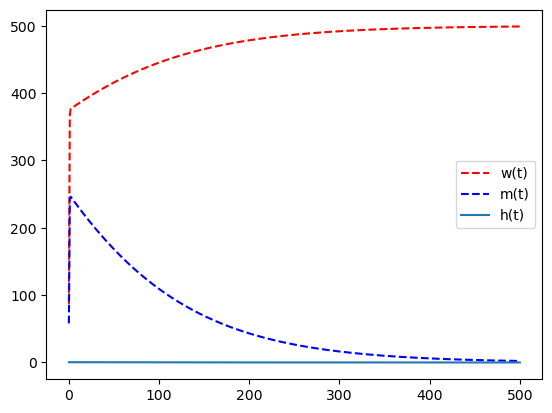

In [34]:
plt.plot(temps, w, "r--",label='w(t)')
plt.plot(temps, m,"b--",label="m(t)")

plt.plot(temps,h,label='h(t)')

# Ajout de légendes
plt.legend()

#### We can see that the ODE system predicts extinction of mutants 

## stochastic with higher death rate 

In [134]:
mu=0.05
c=0.01
rho=0.2
K=100
T=1200
sto_realisations=100

# Matrice de stoichiométrie
V = np.array([[-1, 0, 1, 0],
              [0, -1, 0, 1]])

In [135]:
#epsilon parameters that can make the number of mutants increase
eps_m=(2*(1-rho)*mu)/K
eps = random.uniform(0, eps_m)

In [136]:
h0=0.4
#on essaye d'éviter la division par 0 rho==0 and h0==1
if (rho==0 and h0==1): 
    w0=0
    m0=K
else:
    w0 = (1-h0)*K/(1-h0+rho*h0)
    m0 = h0*K/(1-h0+rho*h0)

# Initialisation de l'état initial
X = np.array([w0,m0])
print(X)

[88.23529412 58.82352941]


In [137]:
def rate_function(rates):
    return max(rates,0) 

In [138]:
from tqdm import tqdm
# Simulation des populations
all_times = []
all_populations = []

for sim in tqdm(range(sto_realisations), desc="Simulations"):
    t = 0
    times_sim = [t]
    X = np.array([w0,m0])
    pop_sim = [X.copy()]
   

    while t <= T:
        # Calcul des taux
        a = np.array([rate_function(mu * X[0]), ##death W
                      rate_function((mu+eps) * X[1]), ##death M
                      rate_function((mu + c * (K - X[0] - rho*X[1]))*X[0]), ##birth W
                      rate_function((mu +c * (K - X[0] - rho*X[1]))*X[1])]) ##birth M
        
        
        # Somme des taux
        somme = np.sum(a)
        # Debug print
        #print(f'Simulation {sim}, t = {t:.4f}, X = {X}, a = {a}, rate_sum = {somme:.4f}')
        if somme==0:
            print('No more events possible, breaking out of the loop.')
            break 
            
         # Sélection de la réaction
        r1 = np.random.rand()
        r_compare= r1*somme
        
        cumulative_sum = np.cumsum(a)
        j = np.searchsorted(cumulative_sum, r_compare)
        # Debugging information
        #print(f'Random number ξ1: {r1}')
        #print(f'Threshold for reaction selection: {r_compare}')
        #print(f'Cumulative sums: {cumulative_sum}, Selected reaction: {j}')
        
           # Vérification que j est bien sélectionné parmi les réactions disponibles
        if j >= len(a):
            print(f'Error: j ({j}) is out of bounds for array a with length {len(a)}.')
            break
            
            
        X += V[:, j ]
        
        
        # Calcul du temps d'événement
        r2 = np.random.rand()
        tau = np.log(1 / r2) / somme
        
        # Mettre à jour le temps
        t += tau
        if t > T:
            break
        times_sim.append(t)
        pop_sim.append(X.copy())
    
    # Enregistrer les résultats de la simulation
    all_times.append(times_sim)
    all_populations.append(pop_sim)


Simulations: 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


In [139]:
total_time=1200
time_points = np.linspace(0, total_time, num=70)


# Calculer la fraction de mutants et l'ensemble moyen
h_ensemble = np.zeros((len(time_points), sto_realisations))
m_ensemble=np.zeros((len(time_points), sto_realisations))
w_ensemble=np.zeros((len(time_points), sto_realisations))



for i in range(sto_realisations):
    times = all_times[i]
    populations = all_populations[i]
    
    for idx, t in enumerate(time_points):
        if t <= times[-1]:
            j = np.searchsorted(times, t)
            W, M = populations[j] if j < len(populations) else populations[-1]
            h_ensemble[idx, i] = M / (W + M)
            m_ensemble[idx,i]=M
            w_ensemble[idx,i]=W
        else:
            h_ensemble[idx, i] = h_ensemble[idx - 1, i]
            m_ensemble[idx, i] = m_ensemble[idx - 1, i]
            w_ensemble[idx, i] = w_ensemble[idx - 1, i]

h_mean = np.mean(h_ensemble, axis=1)
m_mean = np.mean(m_ensemble, axis=1)
w_mean = np.mean(w_ensemble, axis=1)

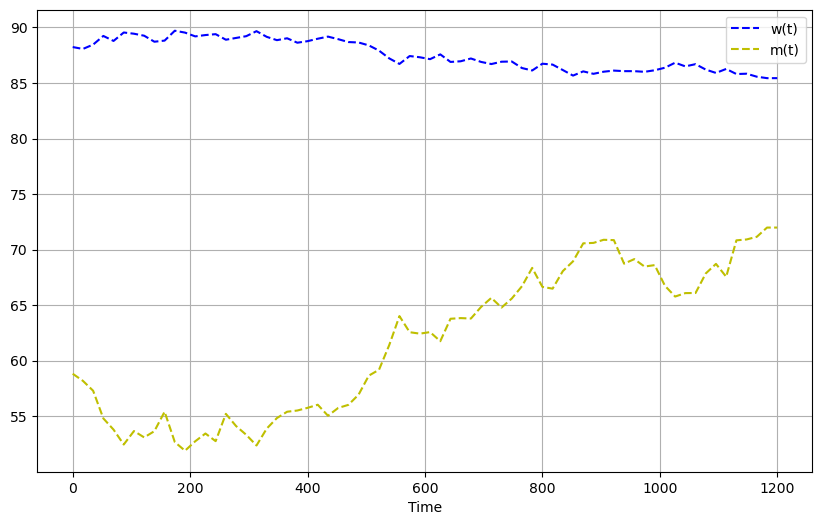

In [140]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.plot(time_points,w_mean,"b--",label="w(t)")
plt.plot(time_points,m_mean,"y--",label="m(t)")
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
m_std=np.std(m_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
m_sem = m_std/ np.sqrt(sto_realisations)
m_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps
w_std=np.std(w_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
w_sem = w_std/ np.sqrt(sto_realisations)
w_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([1.42108547e-15, 2.85326129e-01, 3.83817665e-01, 3.69323706e-01,
       4.62466215e-01, 4.27947427e-01, 4.58475735e-01, 5.59639169e-01,
       6.63095770e-01, 7.07556358e-01, 7.08724911e-01, 7.05903676e-01,
       7.36874480e-01, 7.82263383e-01, 8.05198112e-01, 8.83766938e-01,
       8.17359162e-01, 7.96113057e-01, 8.79915337e-01, 1.00086762e+00,
       9.82830606e-01, 1.10039039e+00, 1.04946605e+00, 1.14651254e+00,
       1.16844983e+00, 1.18977477e+00, 1.23136469e+00, 1.30310207e+00,
       1.36704755e+00, 1.39981249e+00, 1.46231871e+00, 1.49050193e+00,
       1.55643696e+00, 1.56458908e+00, 1.50802387e+00, 1.47479456e+00,
       1.50746277e+00, 1.60244938e+00, 1.54977934e+00, 1.67101496e+00,
       1.71960577e+00, 1.77648276e+00, 1.77588738e+00, 1.80141611e+00,
       1.80127150e+00, 1.82065345e+00, 1.80922635e+00, 1.76941685e+00,
       1.85726977e+00, 1.87036120e+00, 1.96365450e+00, 1.97408688e+00,
       2.01209244e+00, 2.07462189e+00, 1.98247598e+00, 2.00848475e+00,
      

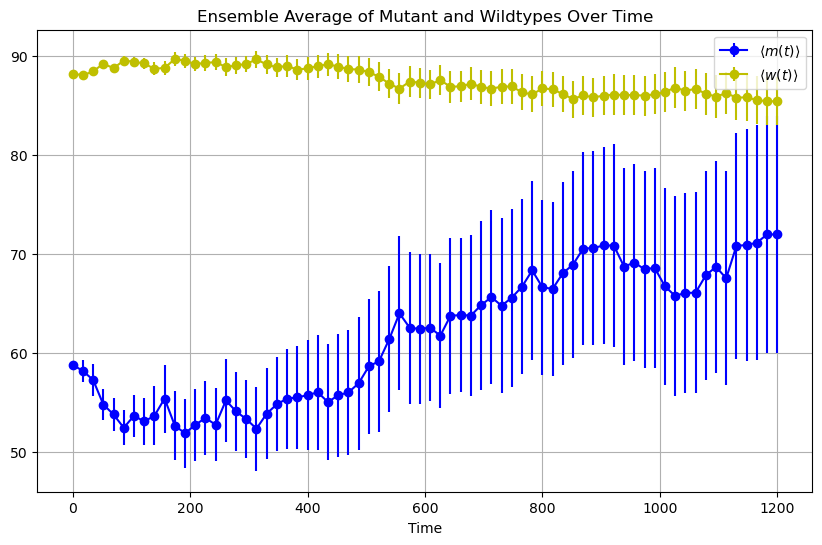

In [142]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, m_mean, yerr=m_sem, fmt='b-', marker='o', label=r'$\langle m(t) \rangle$')
plt.errorbar(time_points, w_mean, yerr=w_sem, fmt='y-', marker='o', label=r'$\langle w(t) \rangle$')
plt.xlabel('Time')
plt.title('Ensemble Average of Mutant and Wildtypes Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
## pour chaque simulation on a h,w,m pour chaque point de temps 
# Affichage des résultats pour vérification
print("h_ensemble :", h_ensemble)
np.shape(h_ensemble)
#print("m_ensemble :", m_ensemble)
#print("w_ensemble :", w_ensemble)

h_ensemble : [[ 0.4         0.4         0.4        ...  0.4         0.4
   0.4       ]
 [ 0.4769905   0.34612177  0.40778923 ...  0.45261122  0.43740516
   0.3932    ]
 [ 0.45730337  0.31388512  0.3805635  ...  0.47670118  0.45331433
   0.3894081 ]
 ...
 [ 0.88339584 -0.00178147  0.64250364 ...  0.86803896  0.39602804
   0.22720478]
 [ 0.87468716 -0.00185644  0.67856123 ...  0.87203707  0.47078159
   0.20505345]
 [ 0.87468716 -0.00185644  0.67856123 ...  0.87203707  0.47078159
   0.20505345]]


(70, 100)

In [144]:
print("h_mean :", h_mean)

h_mean : [0.4        0.39489159 0.38681544 0.37360444 0.36986953 0.36117302
 0.36343345 0.358588   0.35508218 0.35680207 0.34137211 0.3381431
 0.34078166 0.34138713 0.33848546 0.34367704 0.33971326 0.33487994
 0.32541107 0.32901039 0.33297943 0.33132378 0.33005421 0.32526467
 0.32109446 0.31643724 0.31375222 0.31285103 0.31147723 0.31601662
 0.31546203 0.32196641 0.32588855 0.31721107 0.31467483 0.31875661
 0.3132063  0.31389343 0.31412239 0.3097162  0.30755036 0.30602337
 0.30324133 0.30388644 0.31180191 0.31326745 0.30879744 0.30802189
 0.3065505  0.30604519 0.30832016 0.30725248 0.30374382 0.29744162
 0.29327729 0.29384872 0.29023742 0.289228   0.28473994 0.28027138
 0.28208243 0.28162513 0.28274341 0.28388879 0.27709179 0.28097021
 0.27711312 0.27738803 0.27889067 0.27889067]


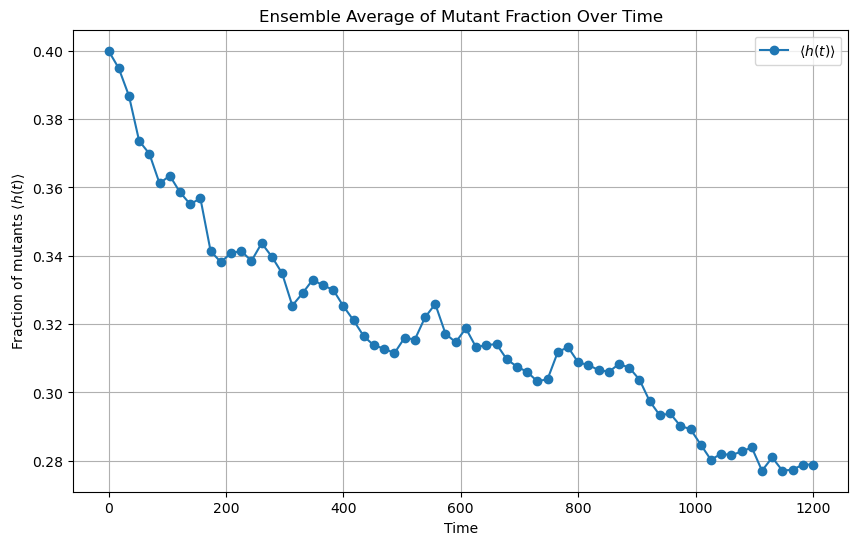

In [145]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.plot(time_points, h_mean, marker='o', label=r'$\langle h(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Ensemble Average of Mutant Fraction Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [146]:
h_std=np.std(h_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
h_sem = h_std/ np.sqrt(sto_realisations)
h_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([1.11022302e-17, 5.04758337e-03, 7.26715479e-03, 7.79869988e-03,
       8.29278732e-03, 8.55510615e-03, 9.94128747e-03, 1.12937475e-02,
       1.35182469e-02, 1.47656133e-02, 1.50425768e-02, 1.51898917e-02,
       1.56236035e-02, 1.62191567e-02, 1.64567391e-02, 1.76787438e-02,
       1.76014028e-02, 1.80272176e-02, 1.88039697e-02, 1.97070195e-02,
       1.96142668e-02, 2.01858914e-02, 2.02638798e-02, 2.10827084e-02,
       2.16556171e-02, 2.16738960e-02, 2.22388815e-02, 2.27969530e-02,
       2.30939409e-02, 2.37579809e-02, 2.41754775e-02, 2.47487902e-02,
       2.57467335e-02, 2.62163858e-02, 2.66823952e-02, 2.66384227e-02,
       2.71738970e-02, 2.78994158e-02, 2.78893567e-02, 2.80979844e-02,
       2.85304435e-02, 2.89320198e-02, 2.87027120e-02, 2.89467713e-02,
       2.91582321e-02, 2.96498962e-02, 2.93862477e-02, 2.94137483e-02,
       3.02027693e-02, 3.06337002e-02, 3.08527253e-02, 3.12158518e-02,
       3.15563210e-02, 3.18498859e-02, 3.16128589e-02, 3.18736735e-02,
      

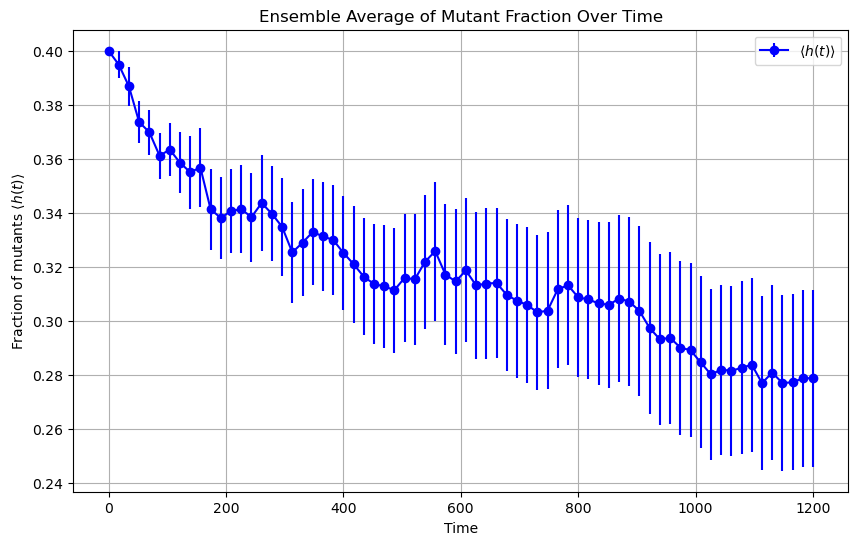

In [147]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, h_mean, yerr=h_sem, fmt='b-', marker='o', label=r'$\langle h(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Ensemble Average of Mutant Fraction Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [148]:
import pandas as pd

# Initialiser une liste pour stocker les résultats
final_values = []

# Parcourir chaque simulation pour extraire les valeurs finales de m et w
for sim in range(sto_realisations):
    times = all_times[sim]
    populations = all_populations[sim]
    w_final = populations[-1][0]  # Dernière valeur de w
    m_final = populations[-1][1]  # Dernière valeur de m
    
    # Correction des valeurs finales négatives
    if w_final < 0:
        w_final = 0
    if m_final < 0:
        m_final = 0
        
        
    final_values.append([sim+1, w_final, m_final])  # Ajouter les valeurs finales à la liste

# Convertir la liste en DataFrame
df_final_values = pd.DataFrame(final_values, columns=['Simulation', 'w_final', 'm_final'])
print(df_final_values)
mean_m_final = df_final_values['m_final'].mean()

print(f"La moyenne des valeurs finales de m sur {sto_realisations} simulations est : {mean_m_final}")
mean_w_final = df_final_values['w_final'].mean()

print(f"La moyenne des valeurs finales de w sur {sto_realisations} simulations est : {mean_w_final}")
print("valeur w initiale" ,w0)
print("valeur m initiale ",m0)

    Simulation    w_final     m_final
0            1  37.235294  295.823529
1            2  98.235294    0.000000
2            3  67.235294  159.823529
3            4  80.235294   86.823529
4            5  76.235294  138.823529
..         ...        ...         ...
95          96  85.235294   62.823529
96          97  15.235294  418.823529
97          98  45.235294  262.823529
98          99  84.235294   79.823529
99         100  94.235294   33.823529

[100 rows x 3 columns]
La moyenne des valeurs finales de m sur 100 simulations est : 70.85823529411763
La moyenne des valeurs finales de w sur 100 simulations est : 85.46058823529413
valeur w initiale 88.23529411764707
valeur m initiale  58.82352941176471


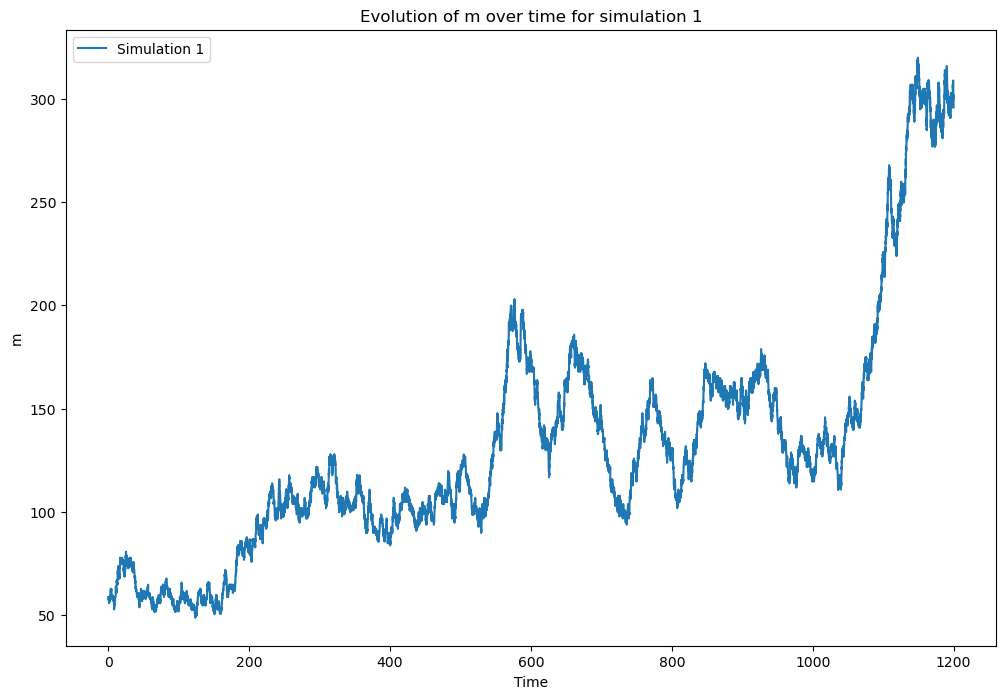

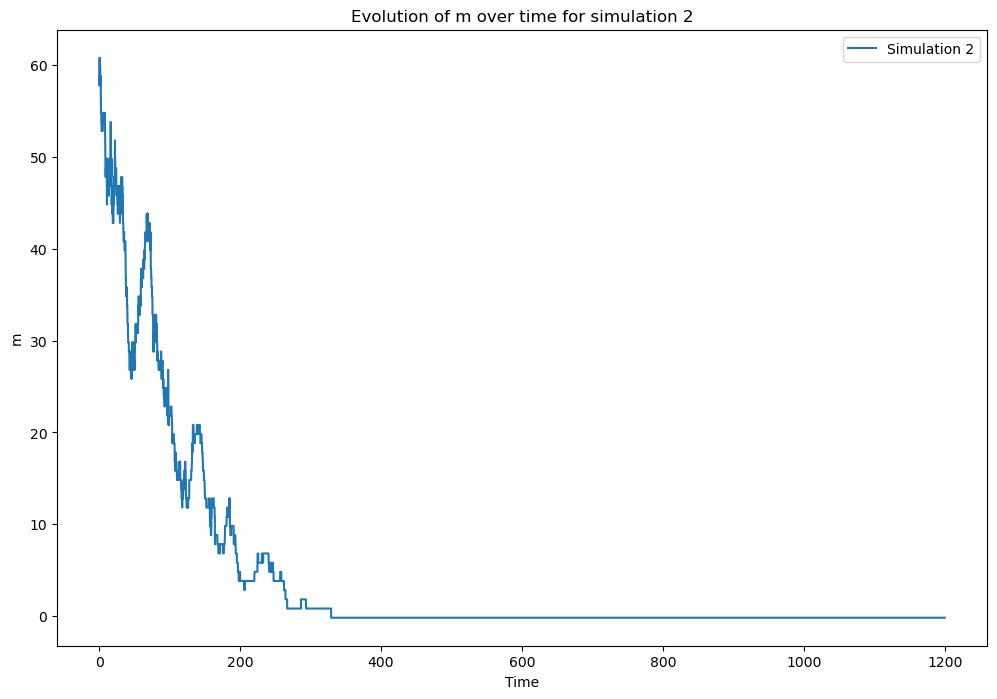

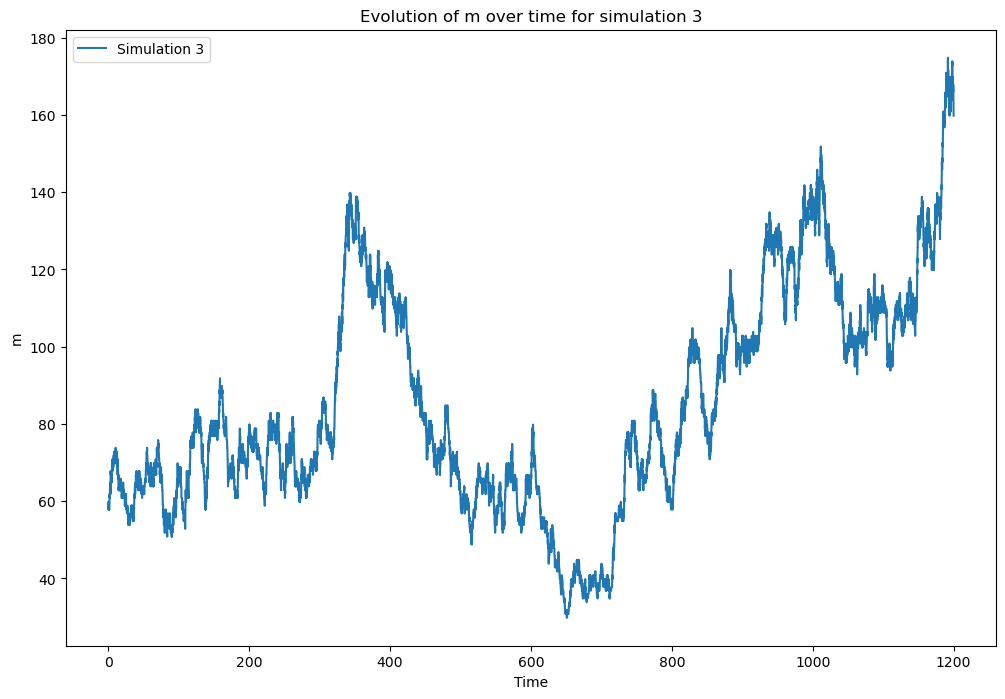

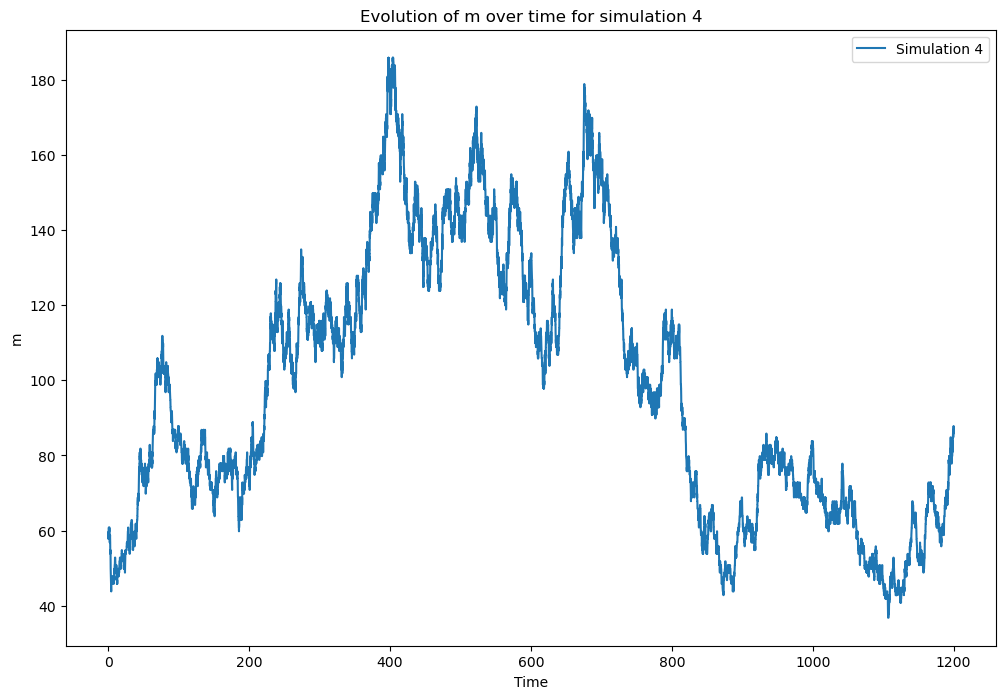

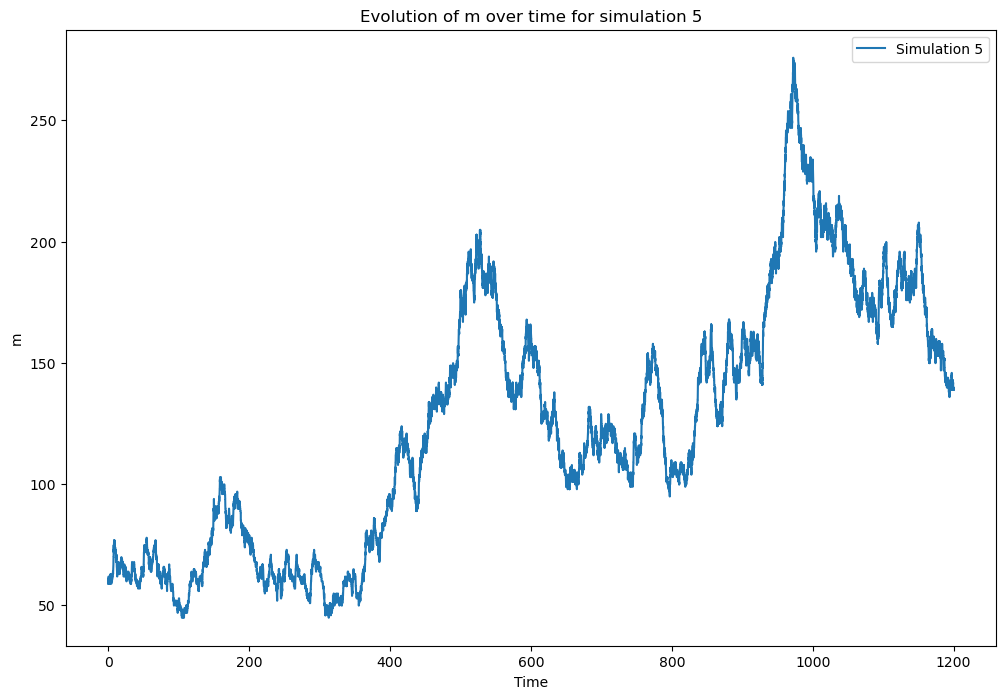

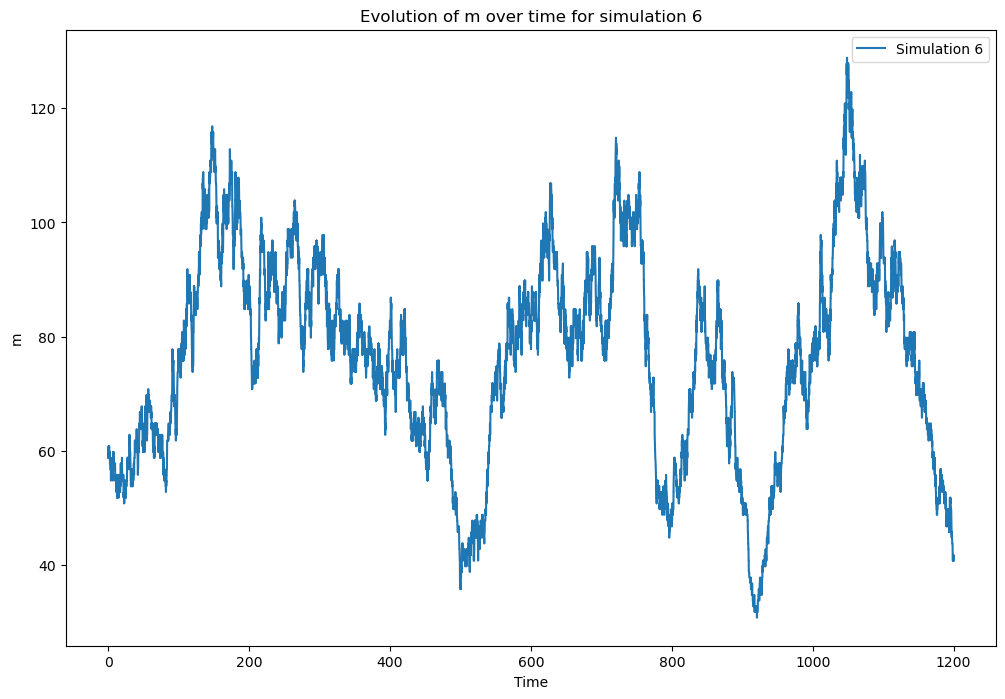

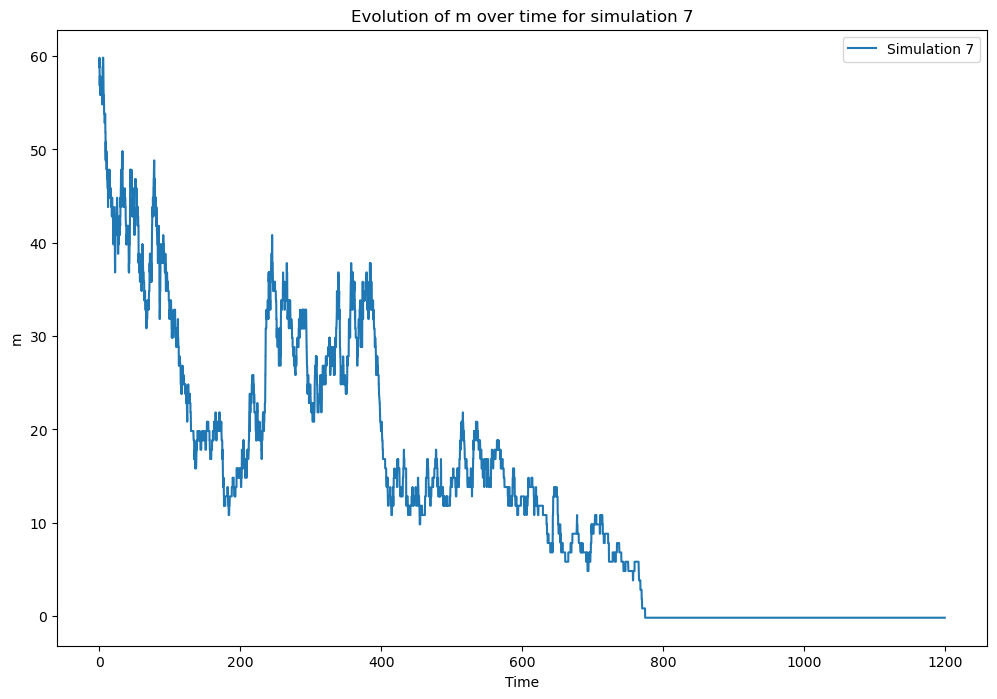

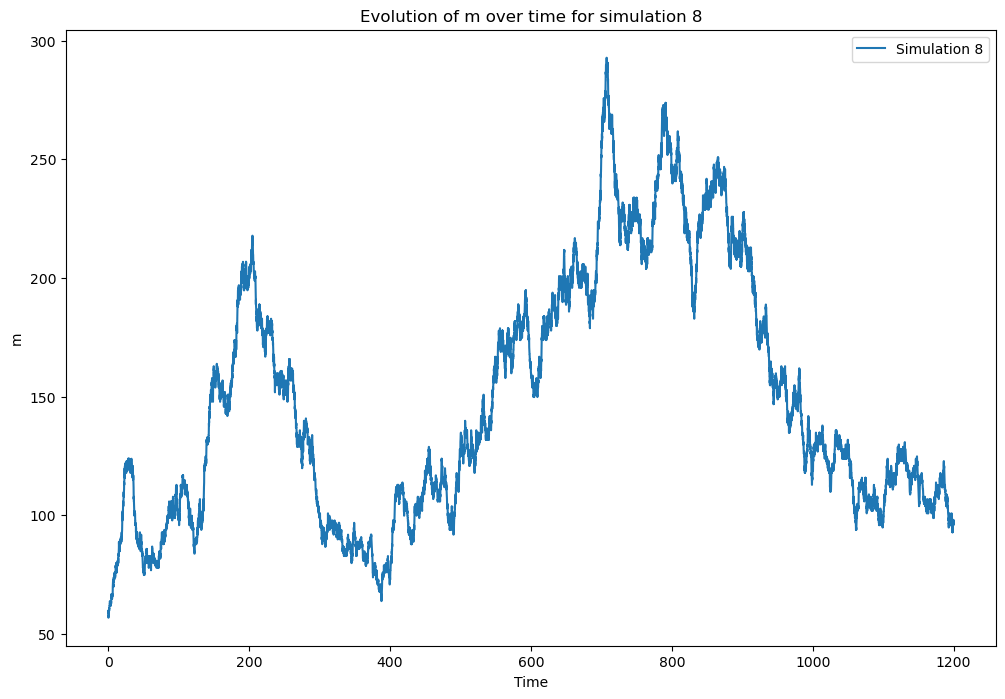

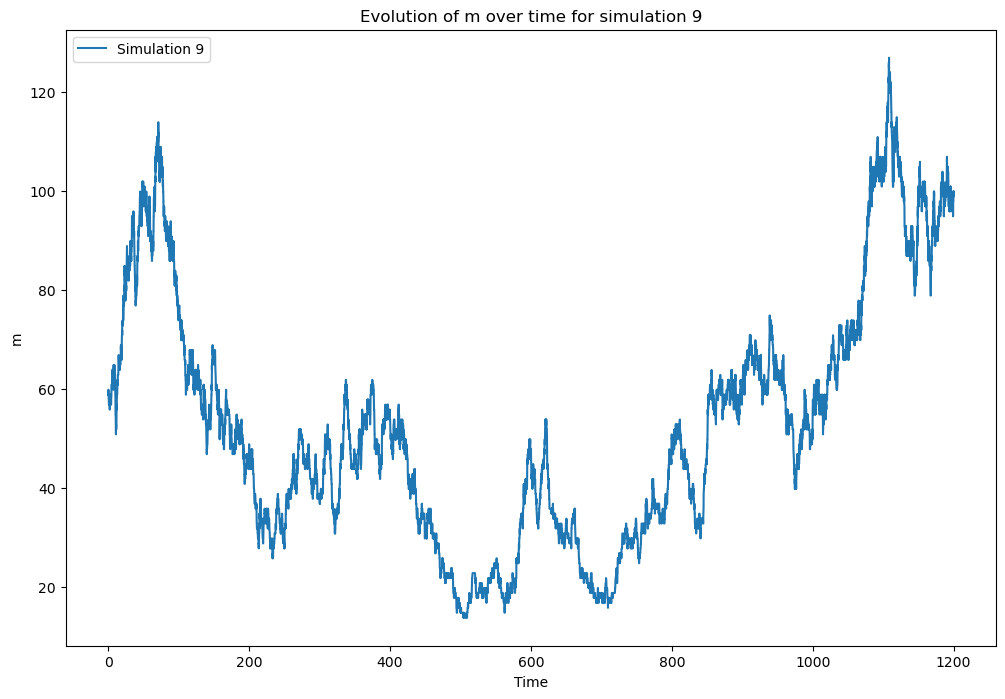

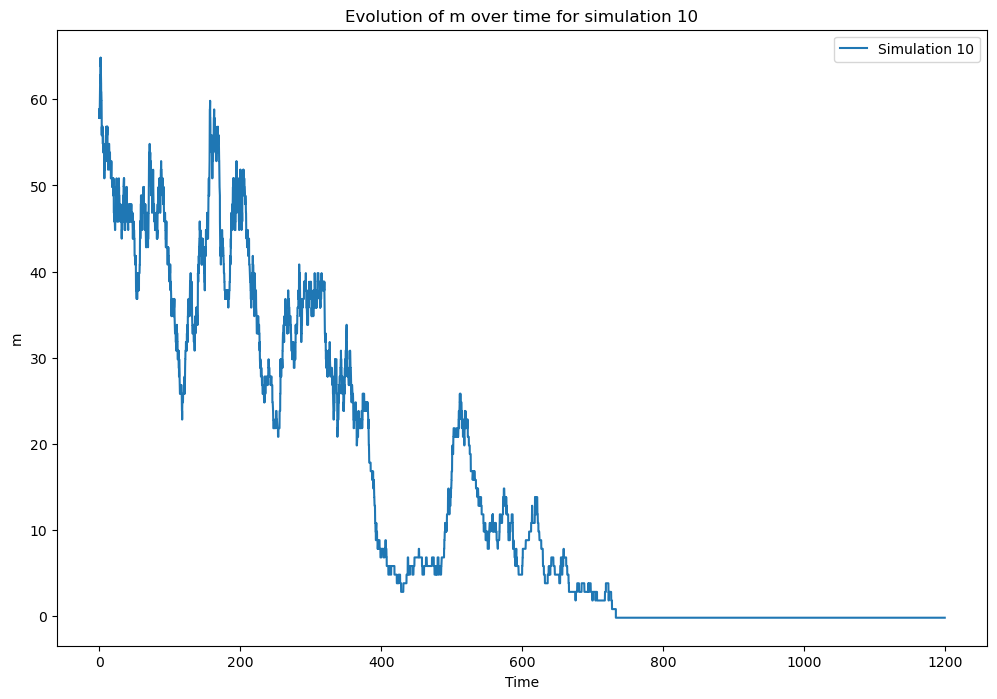

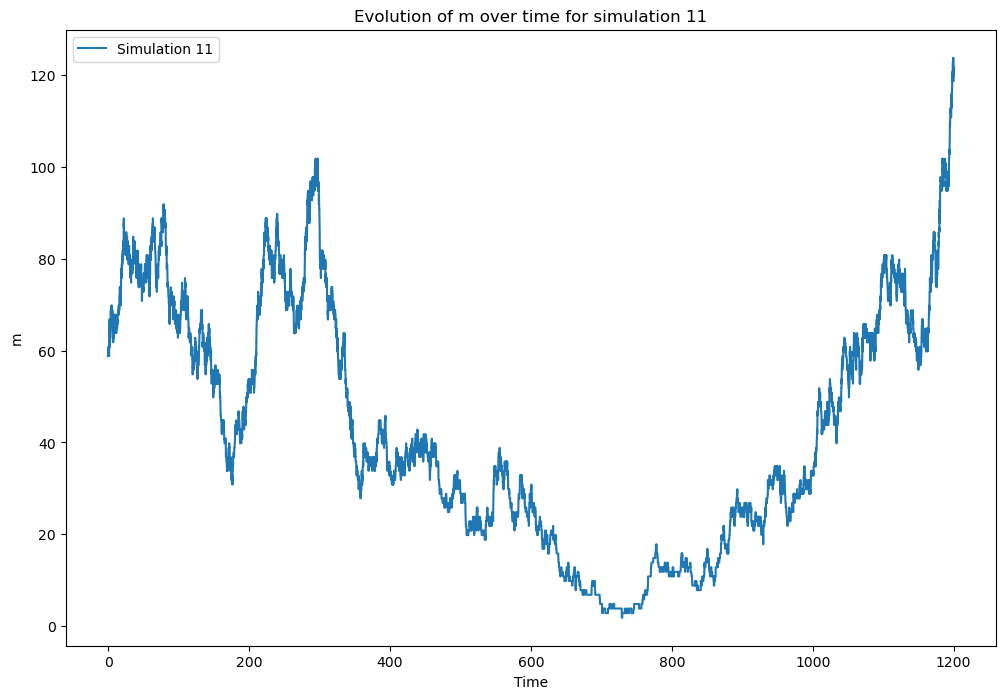

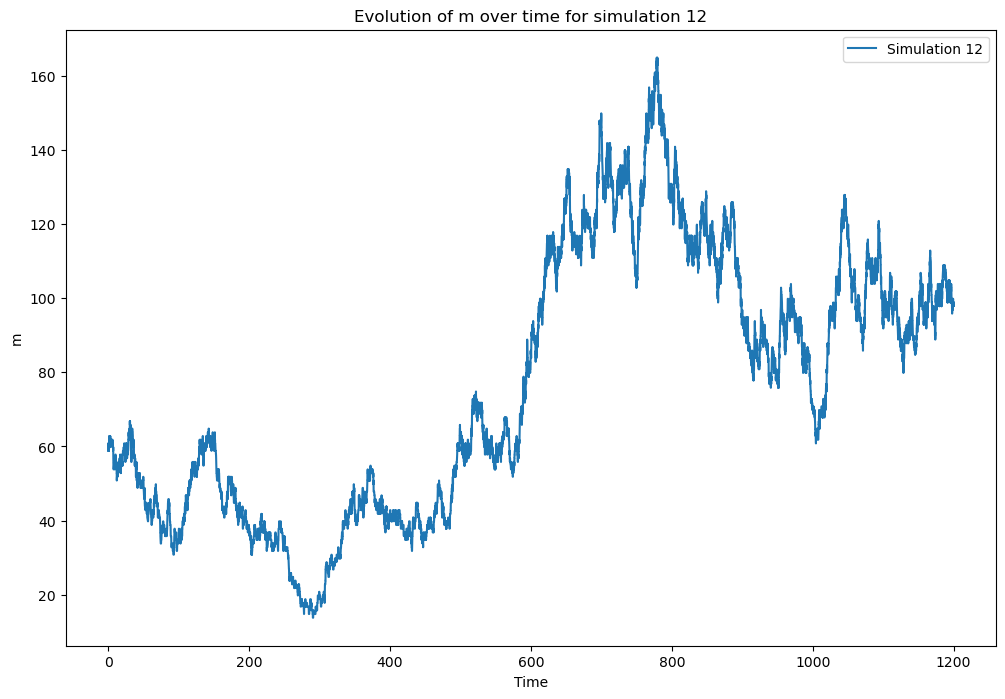

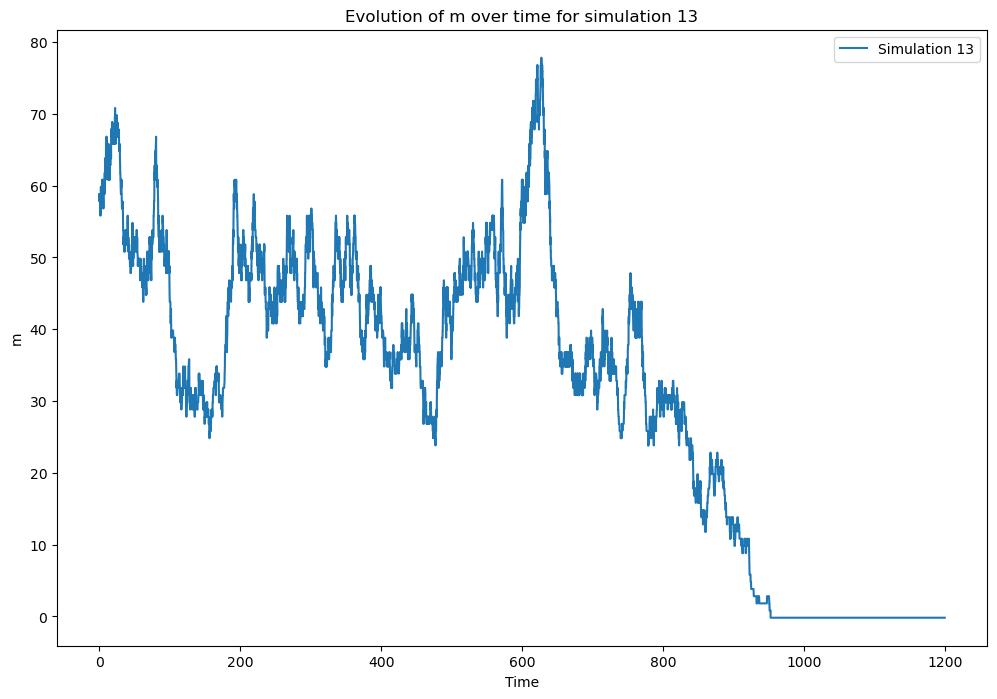

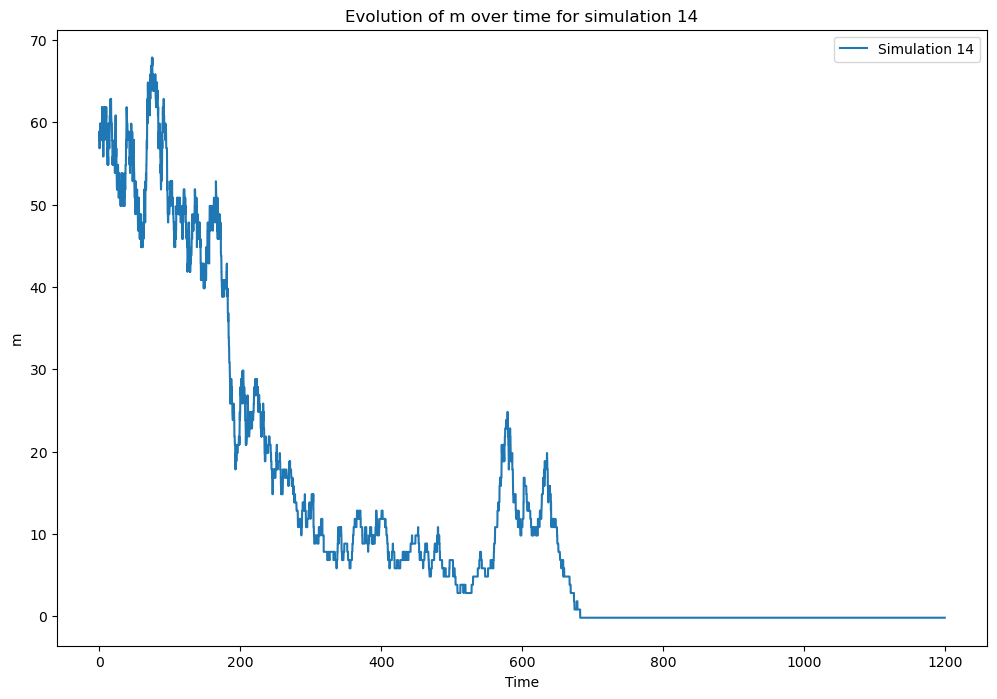

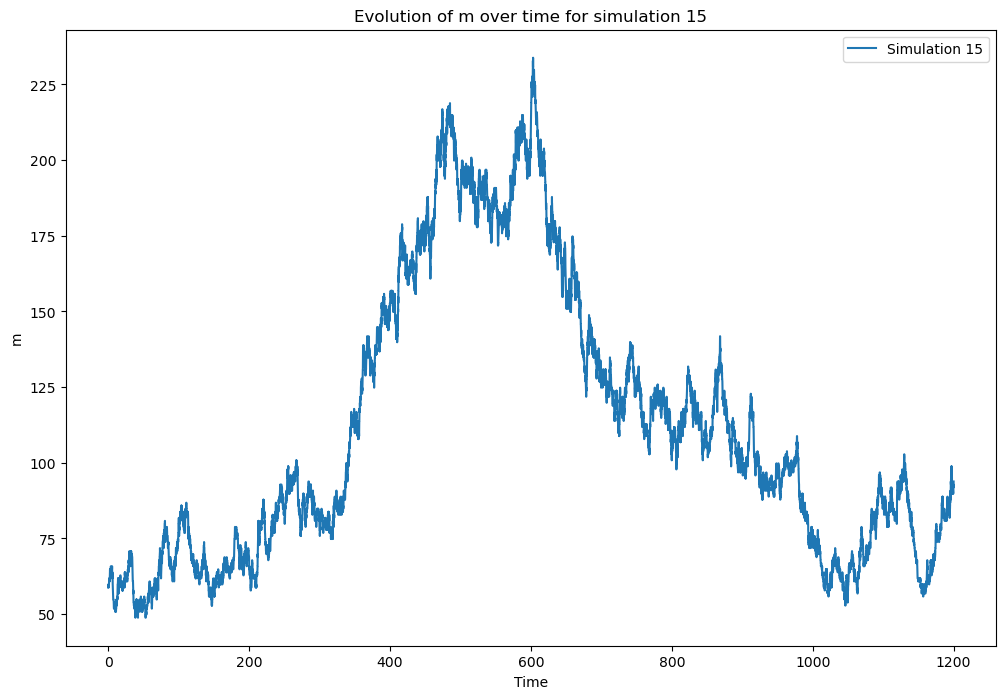

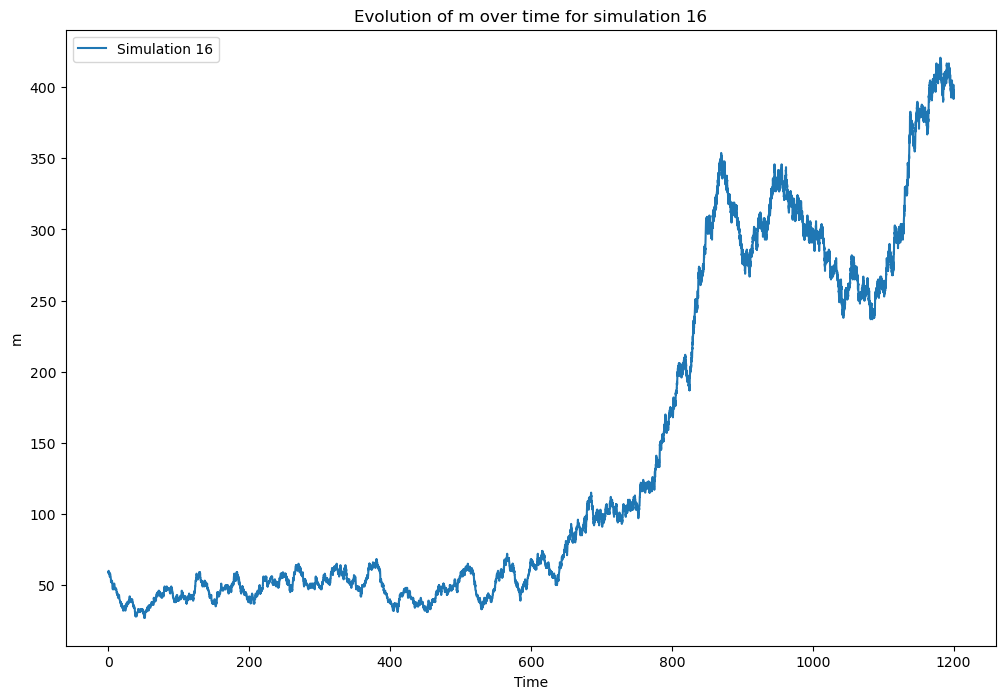

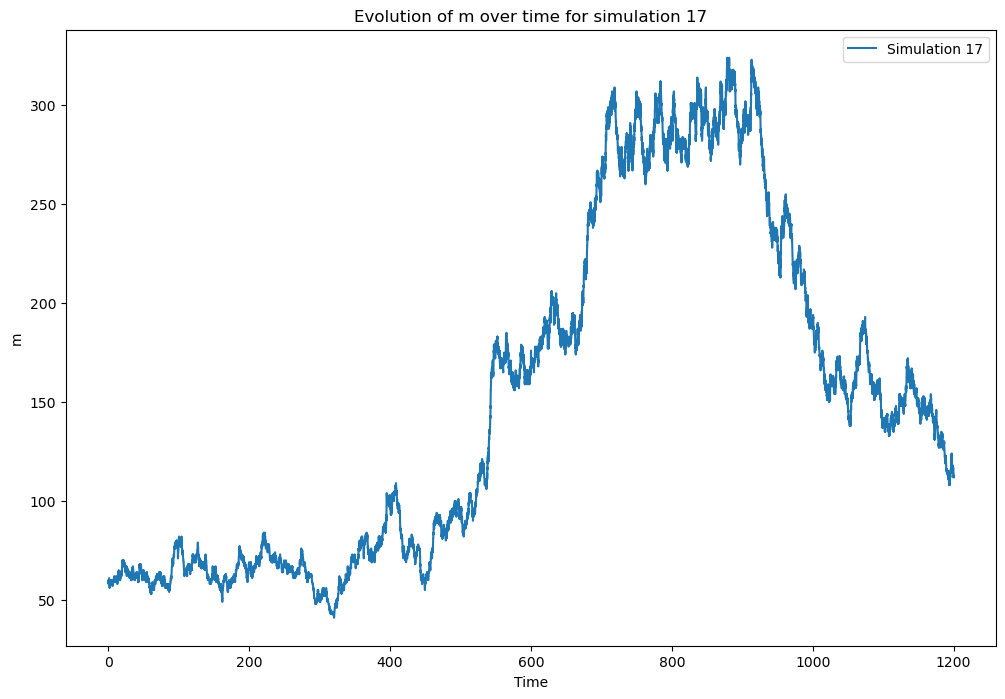

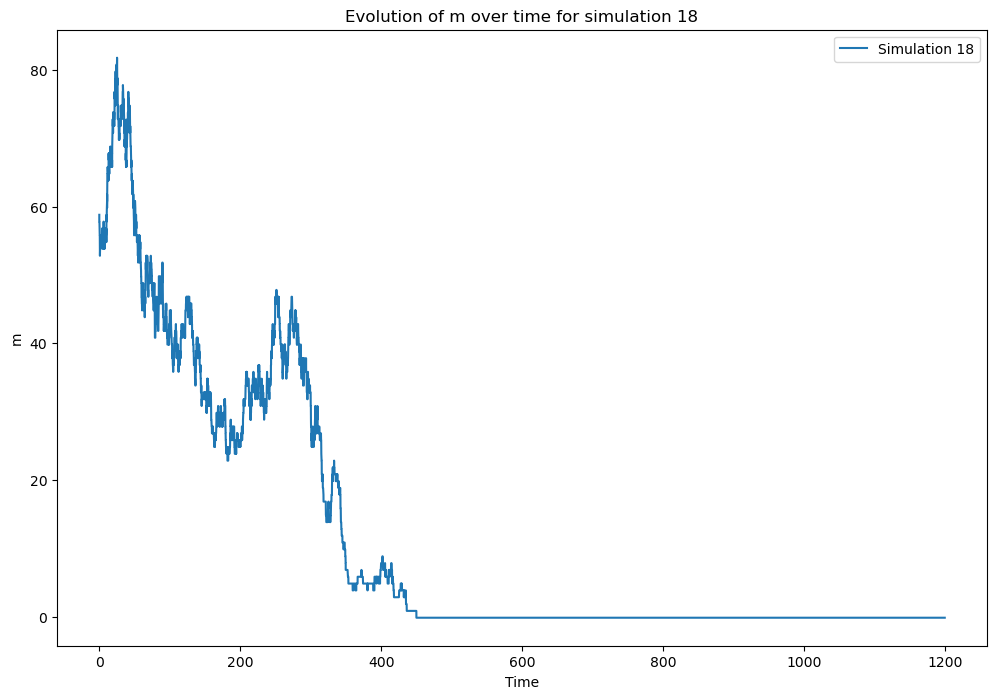

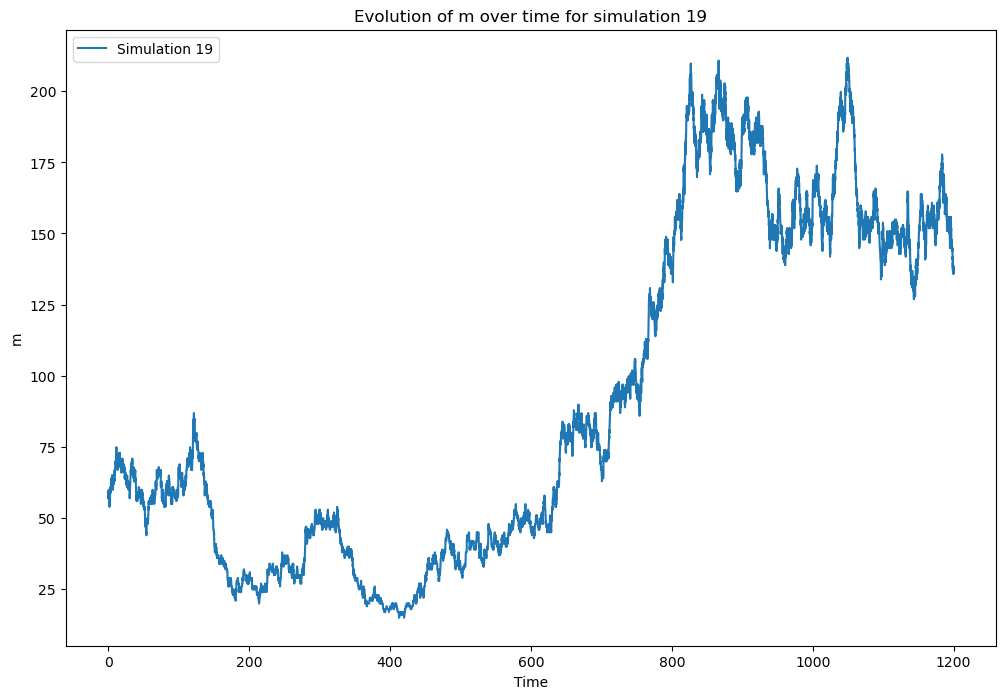

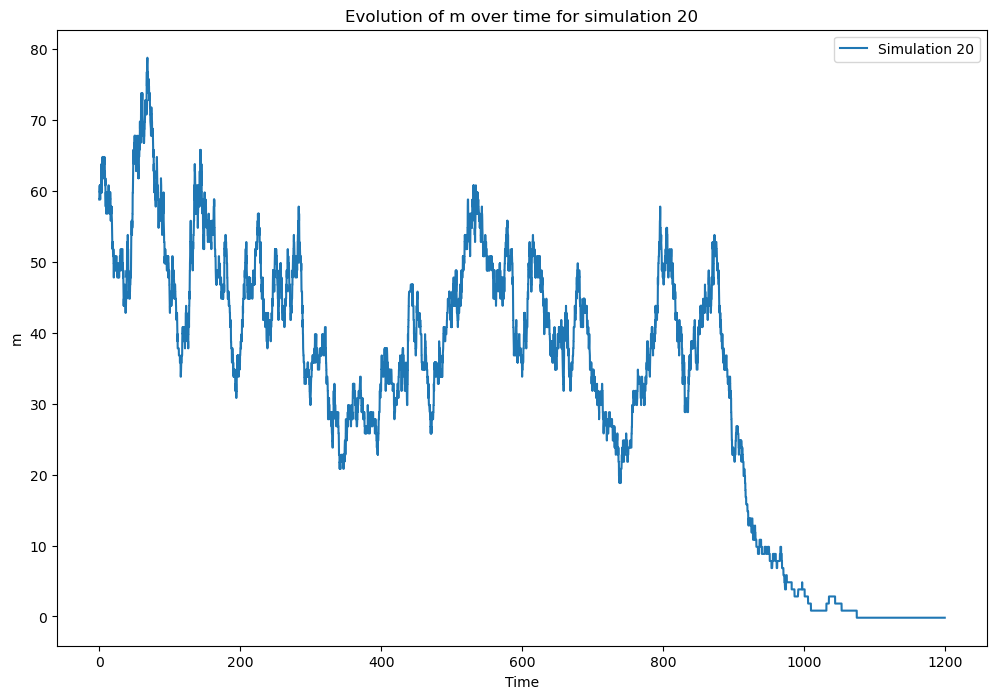

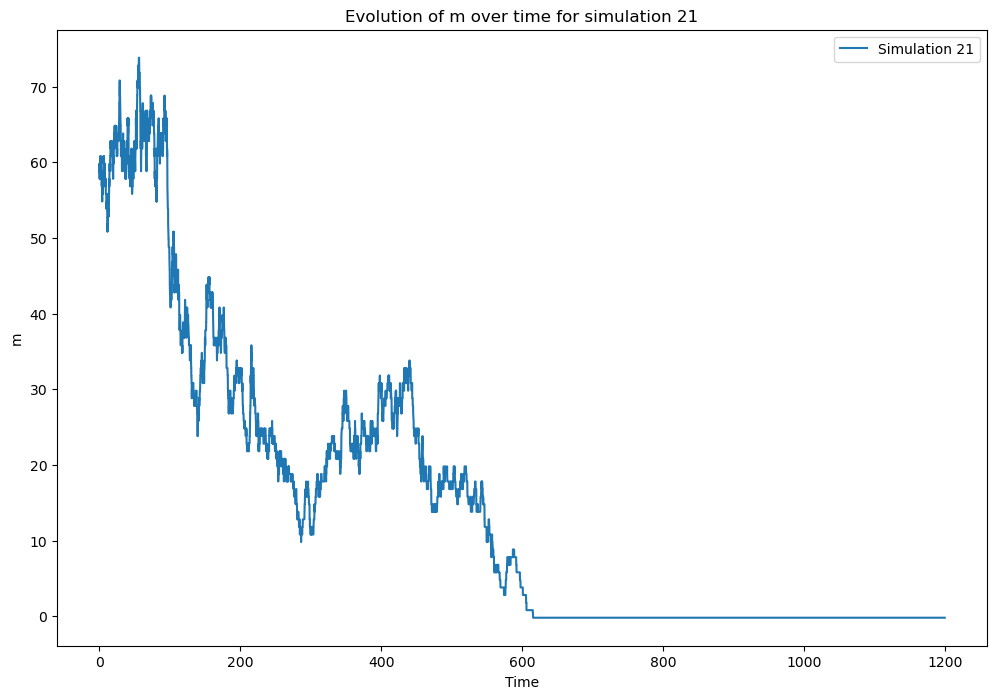

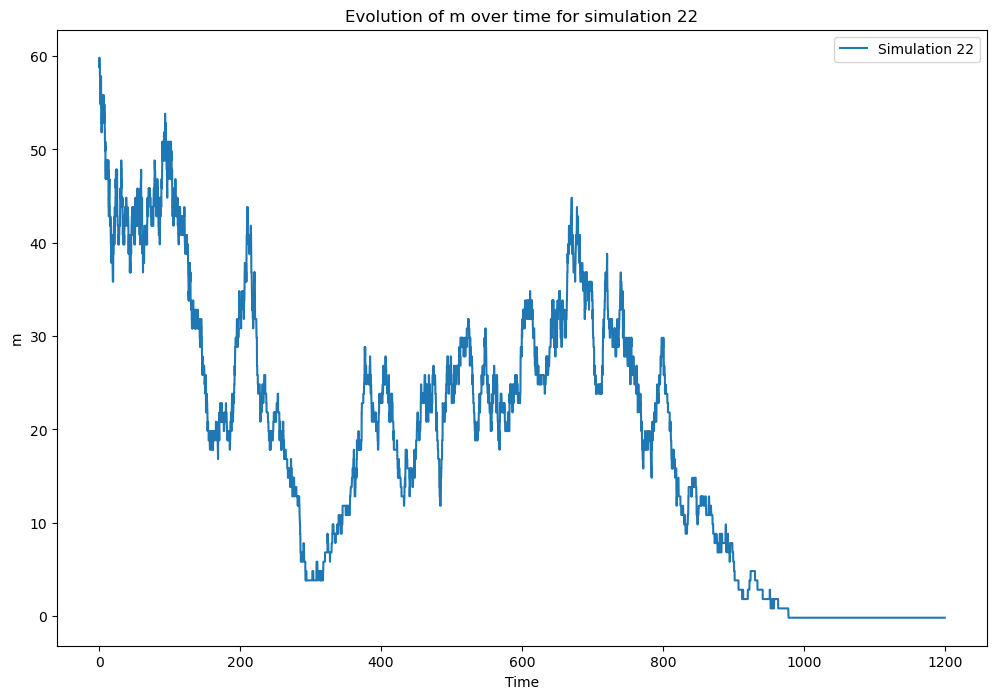

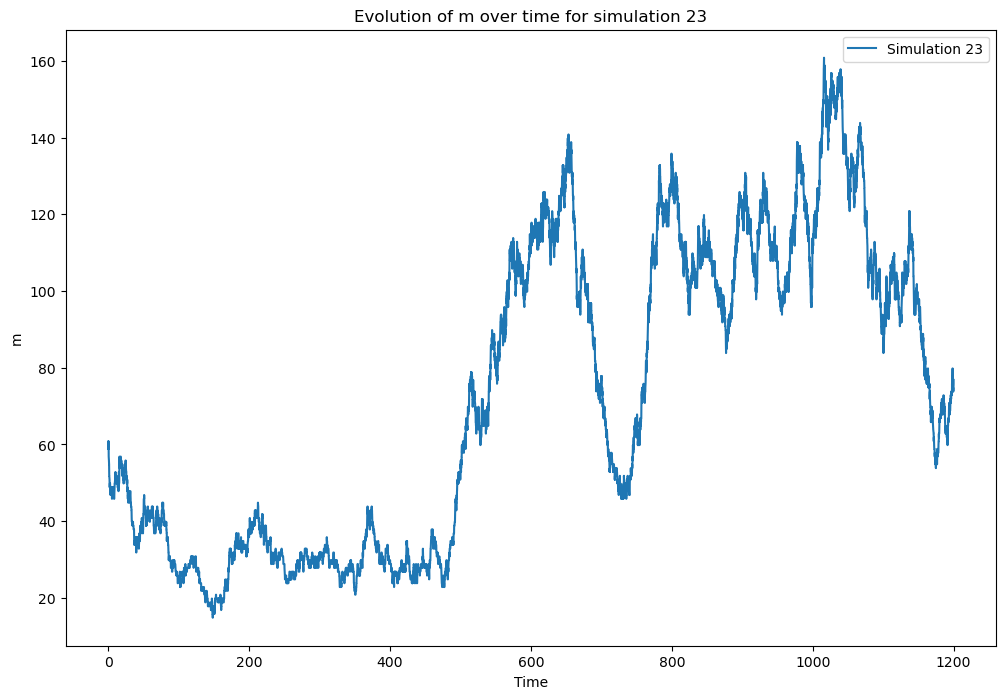

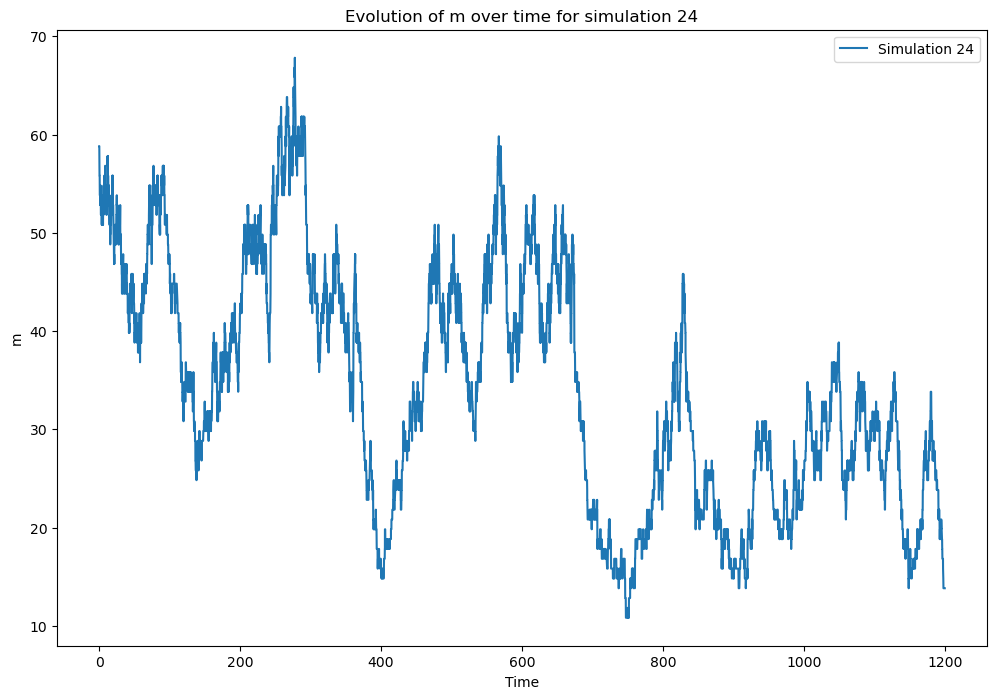

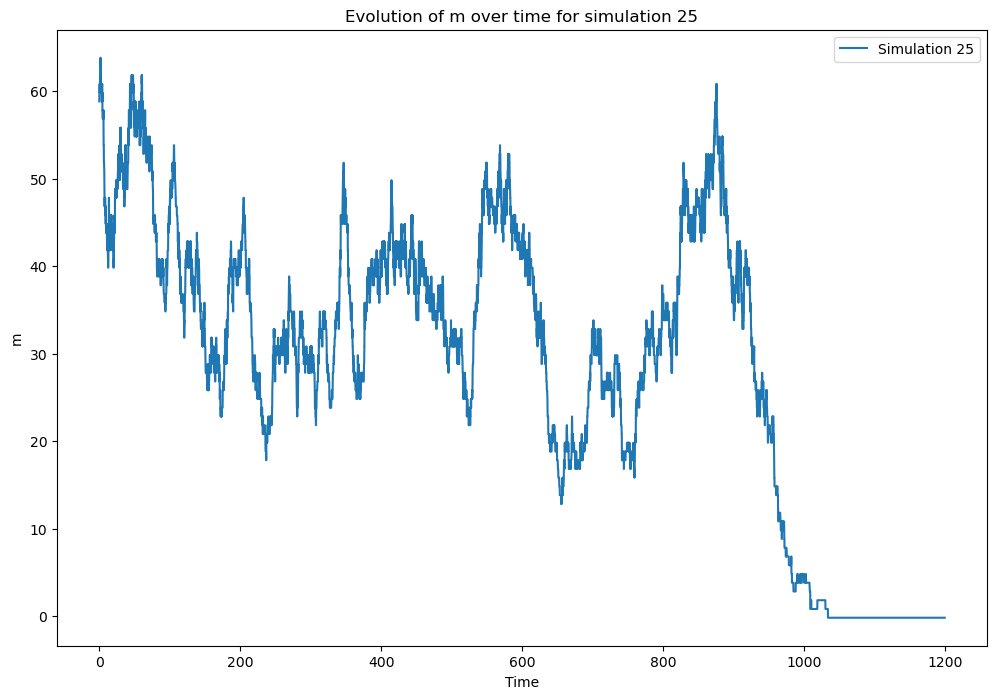

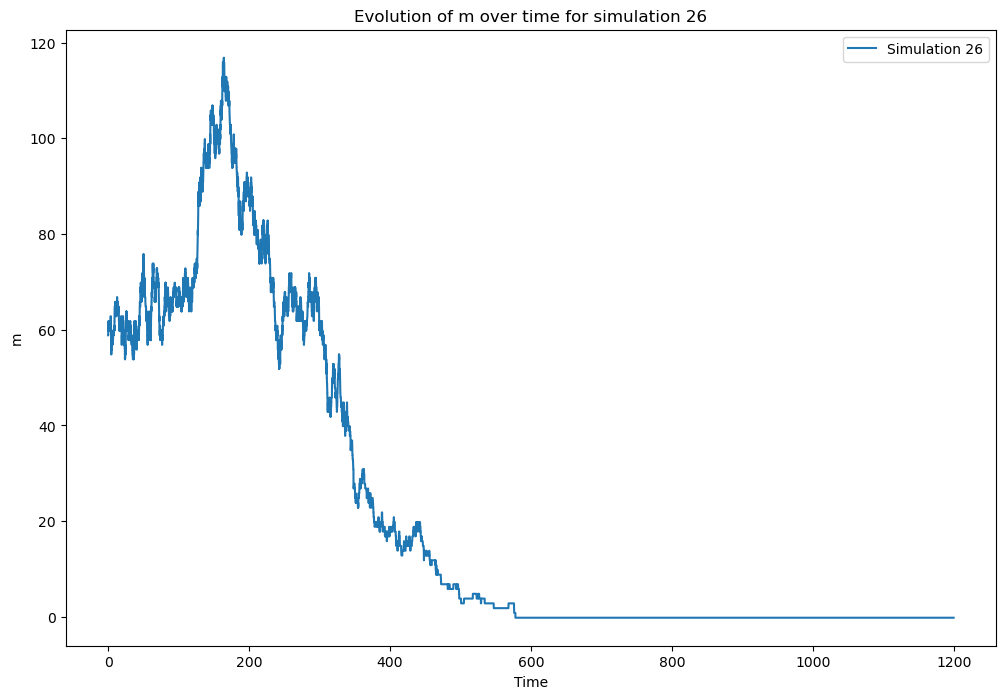

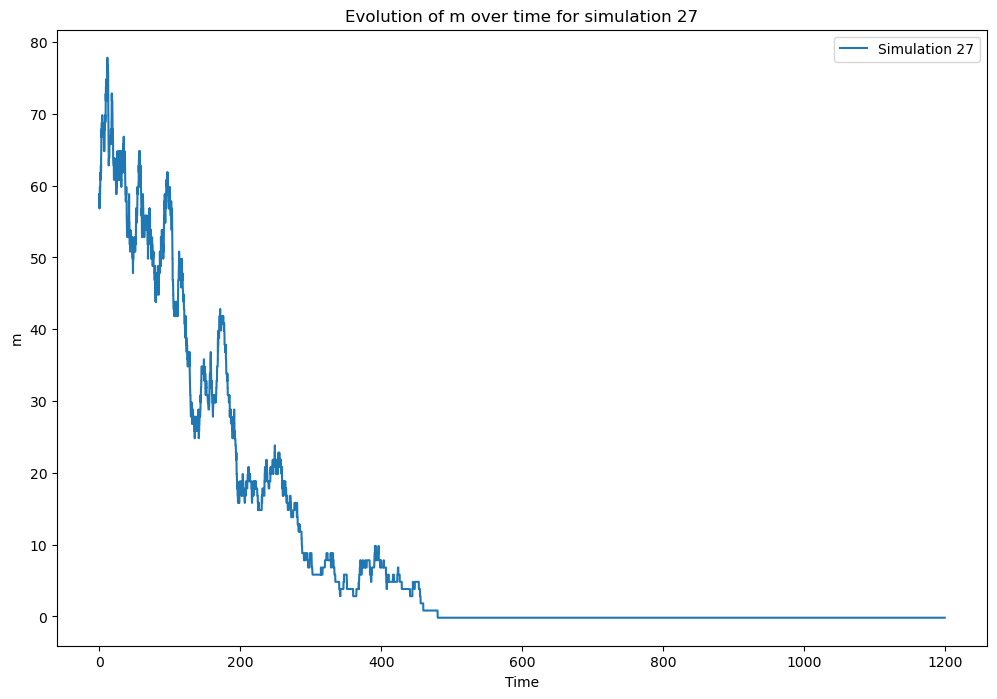

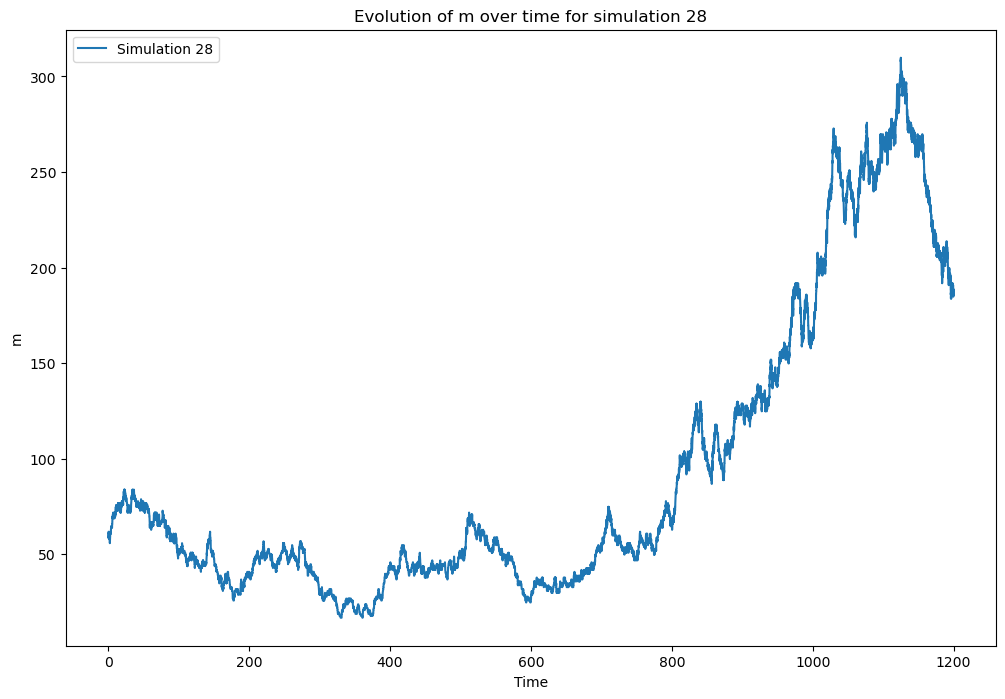

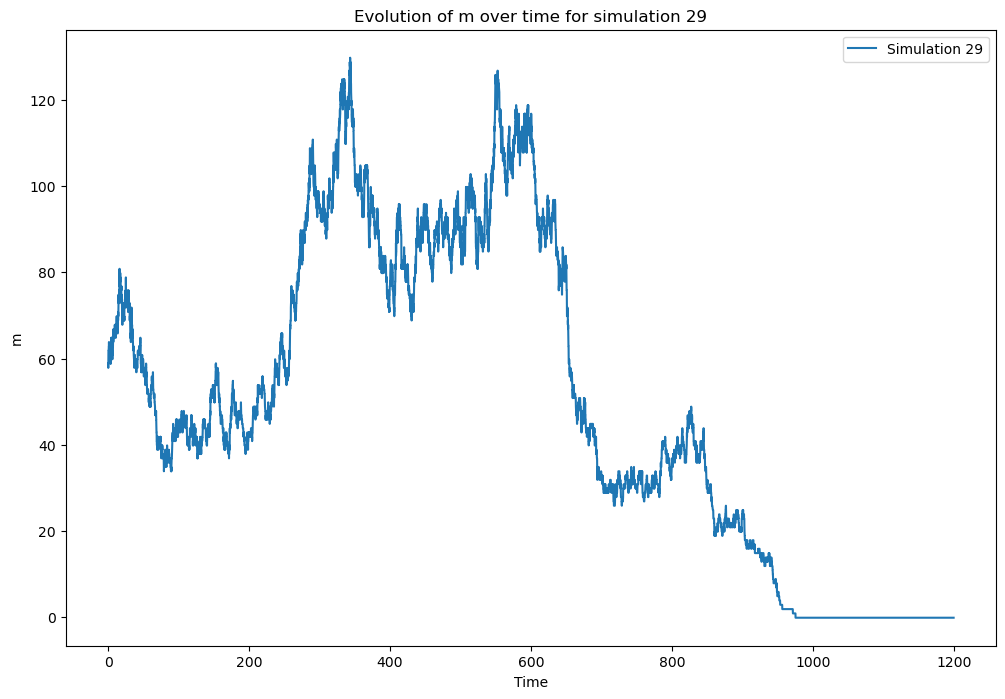

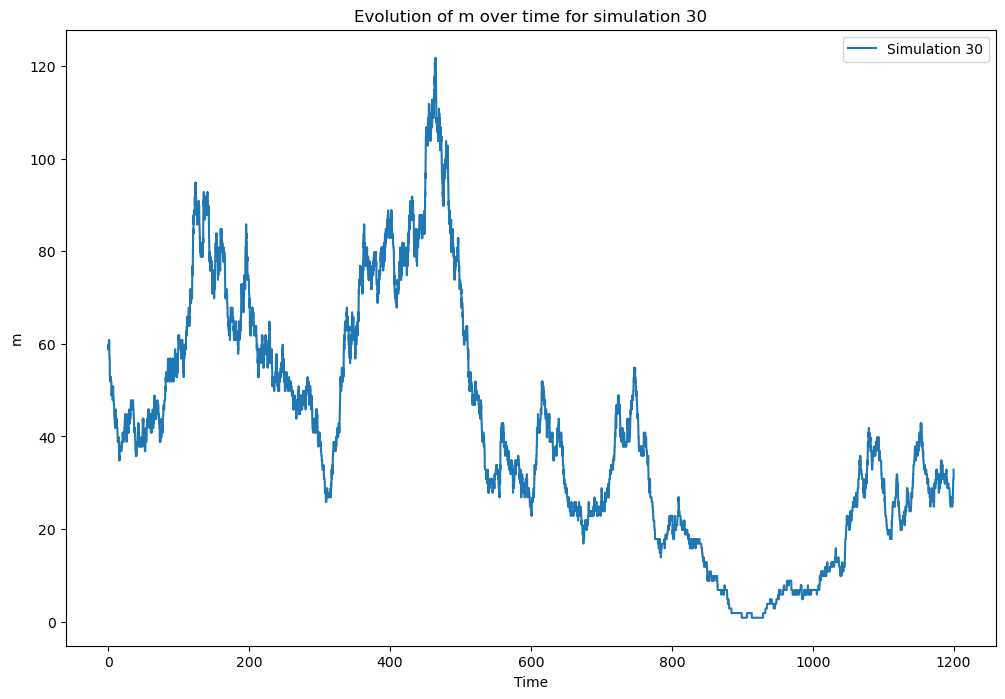

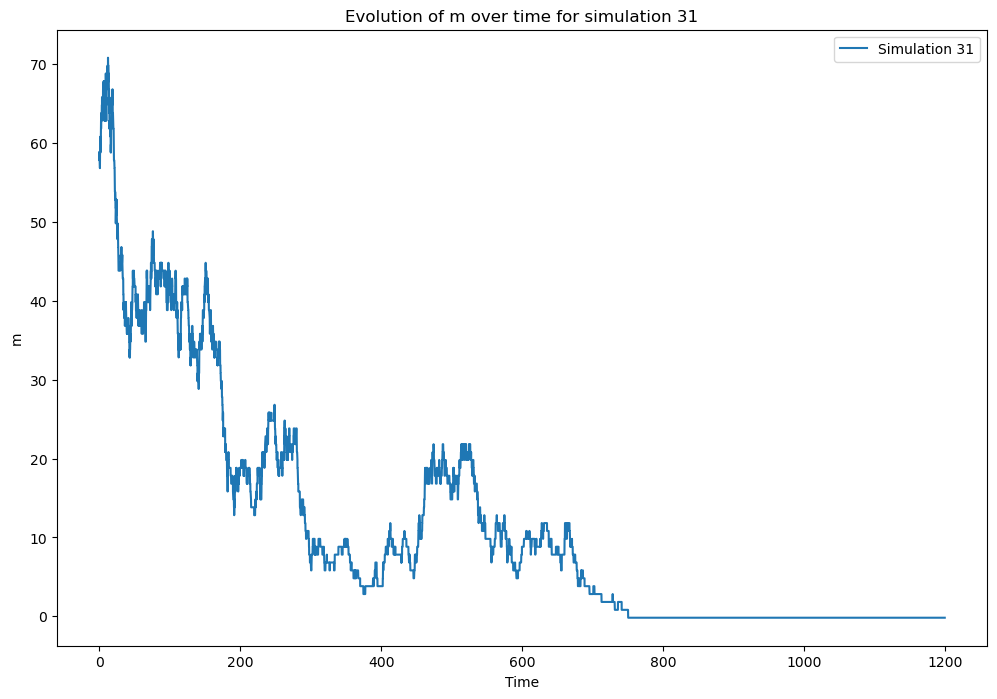

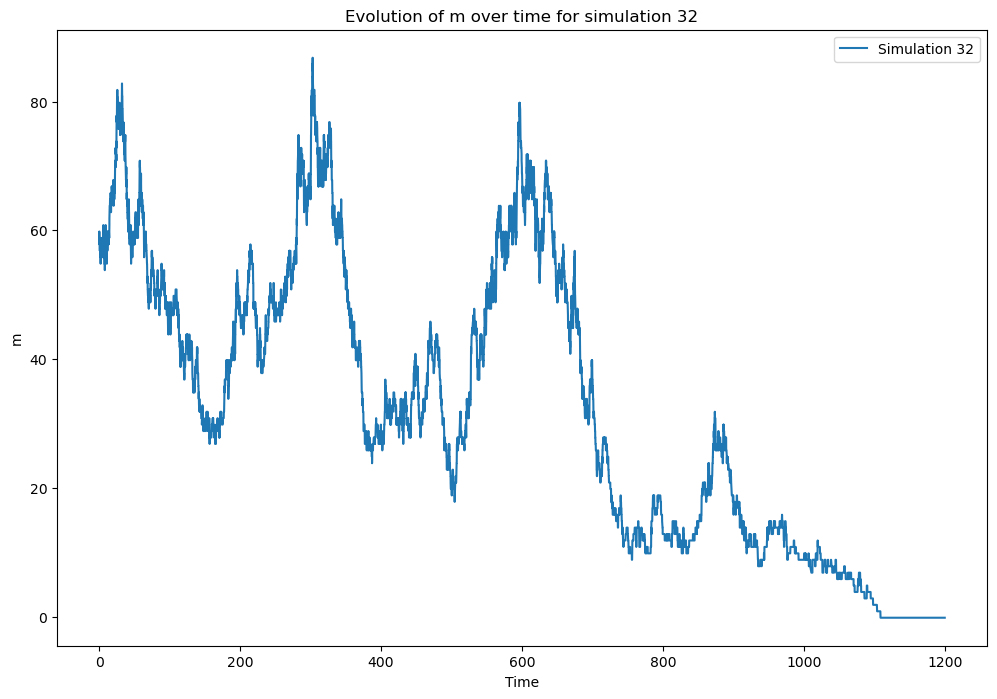

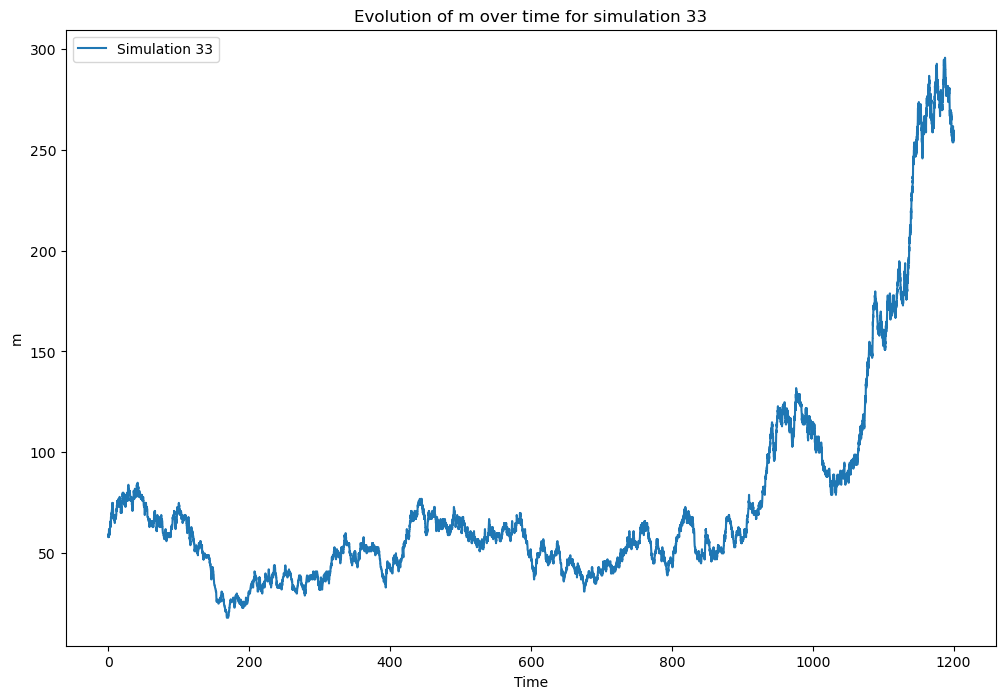

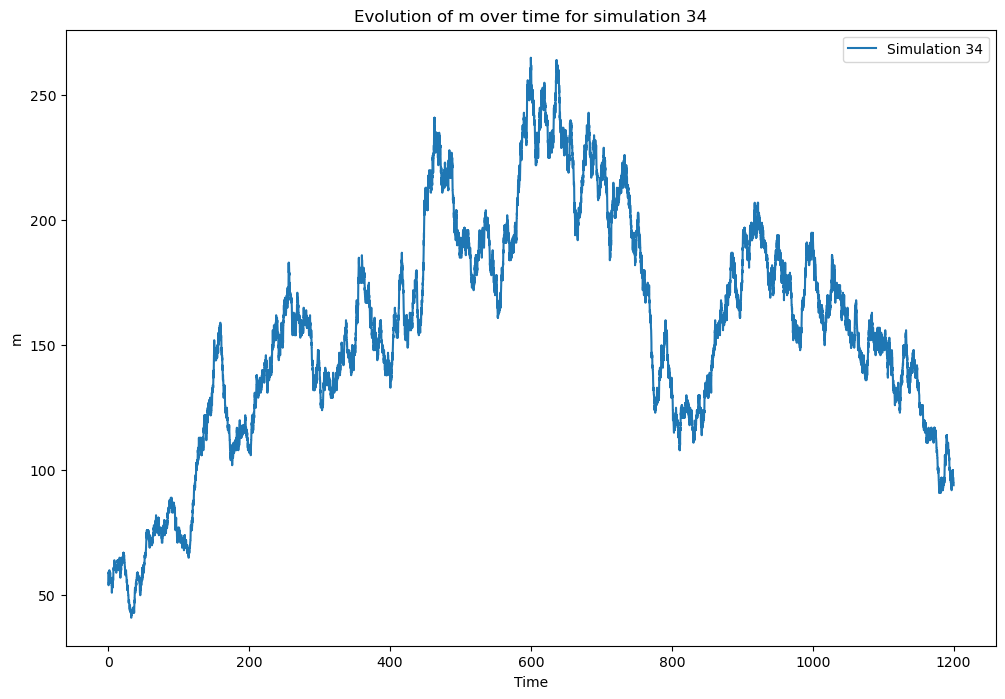

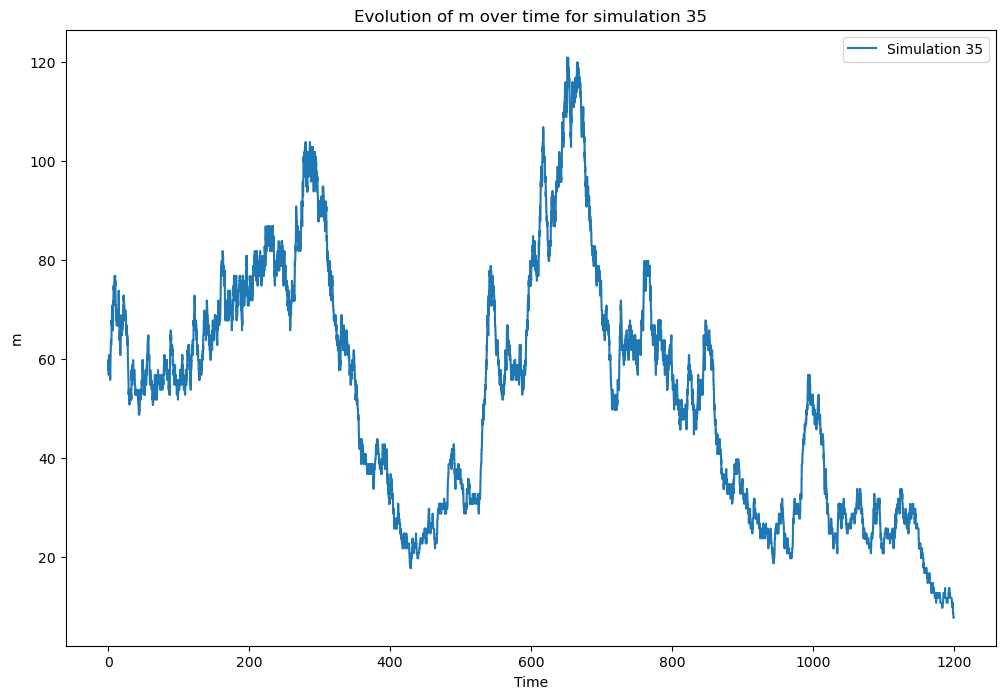

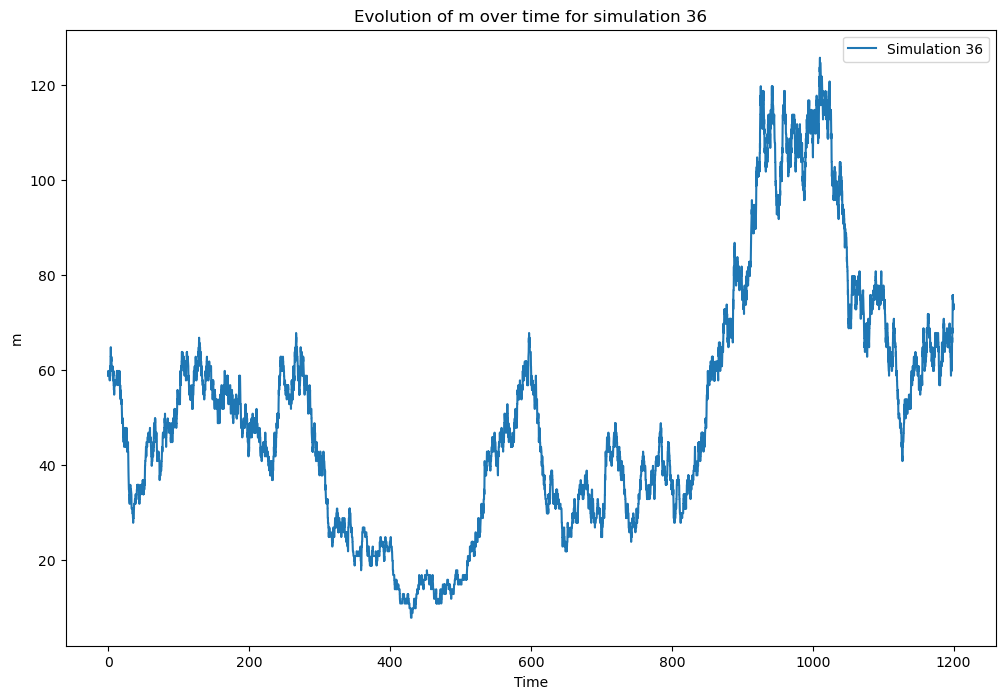

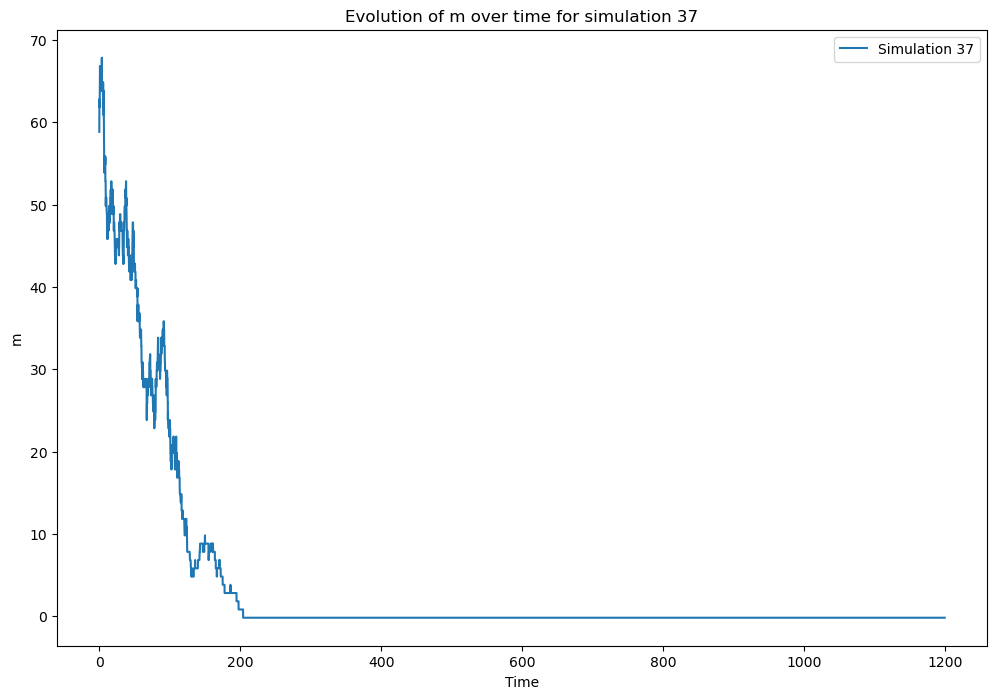

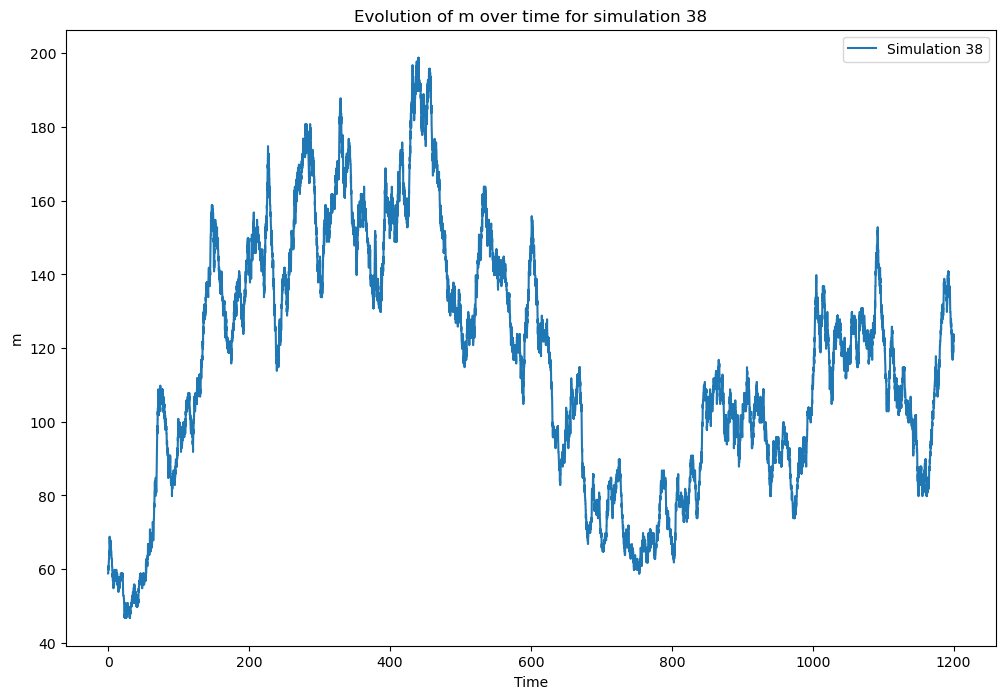

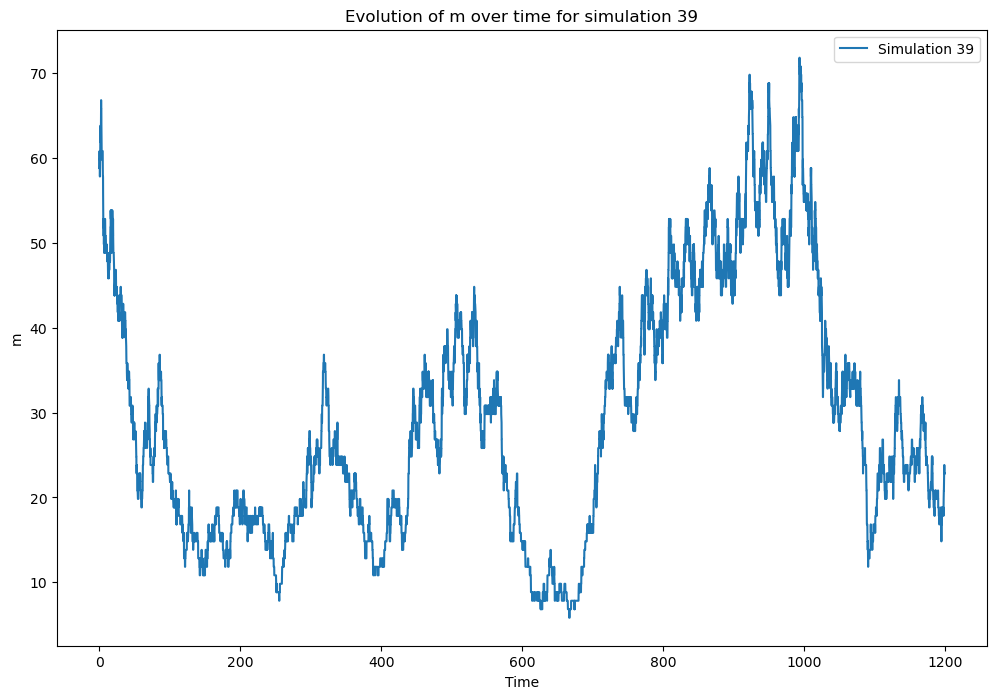

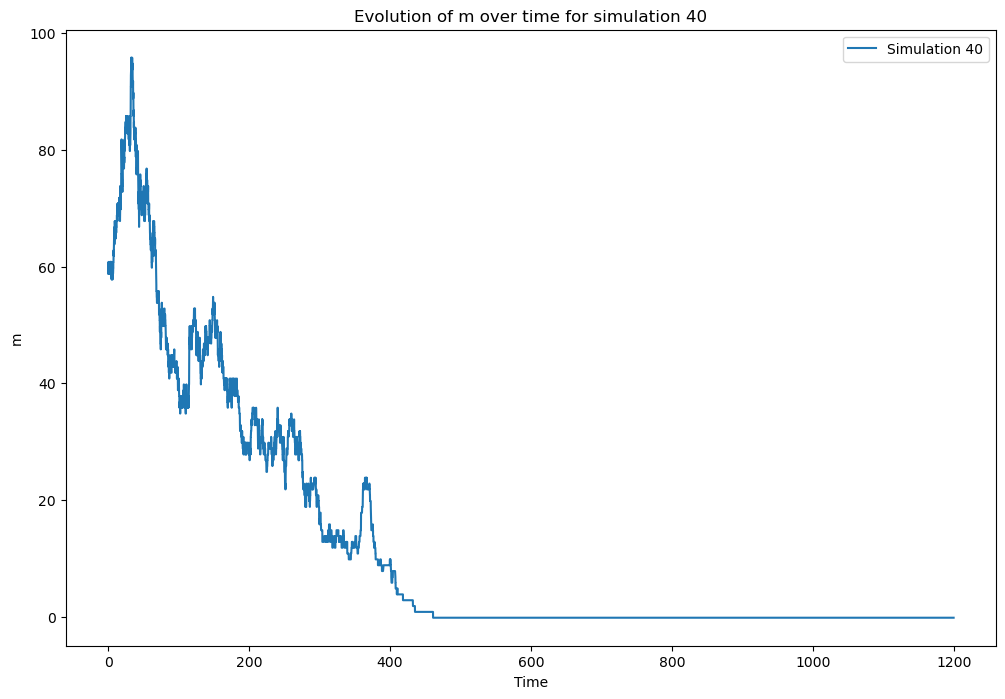

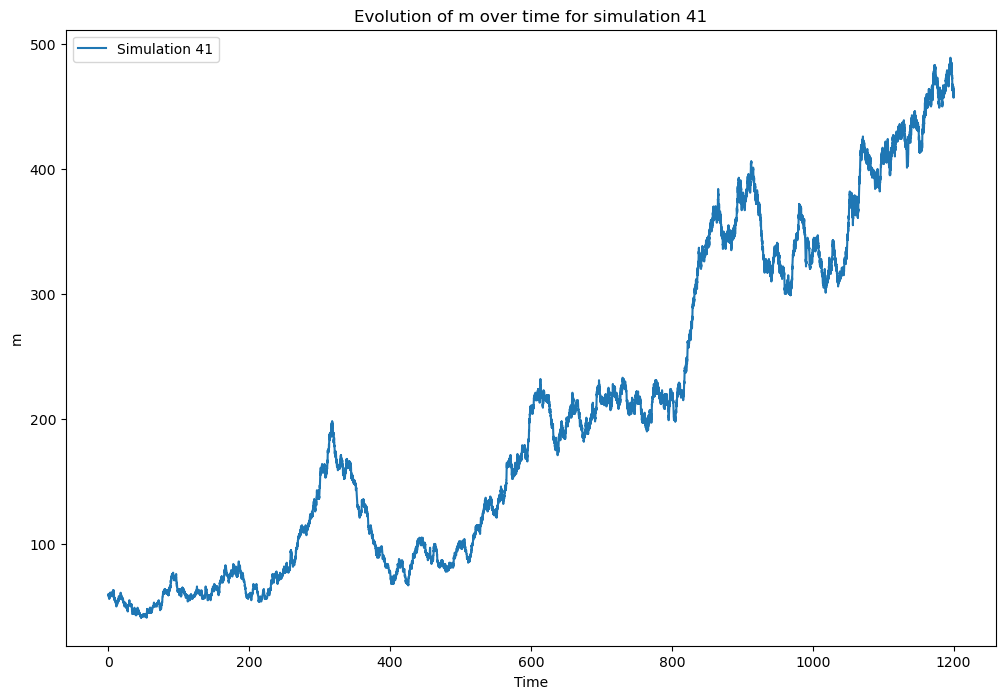

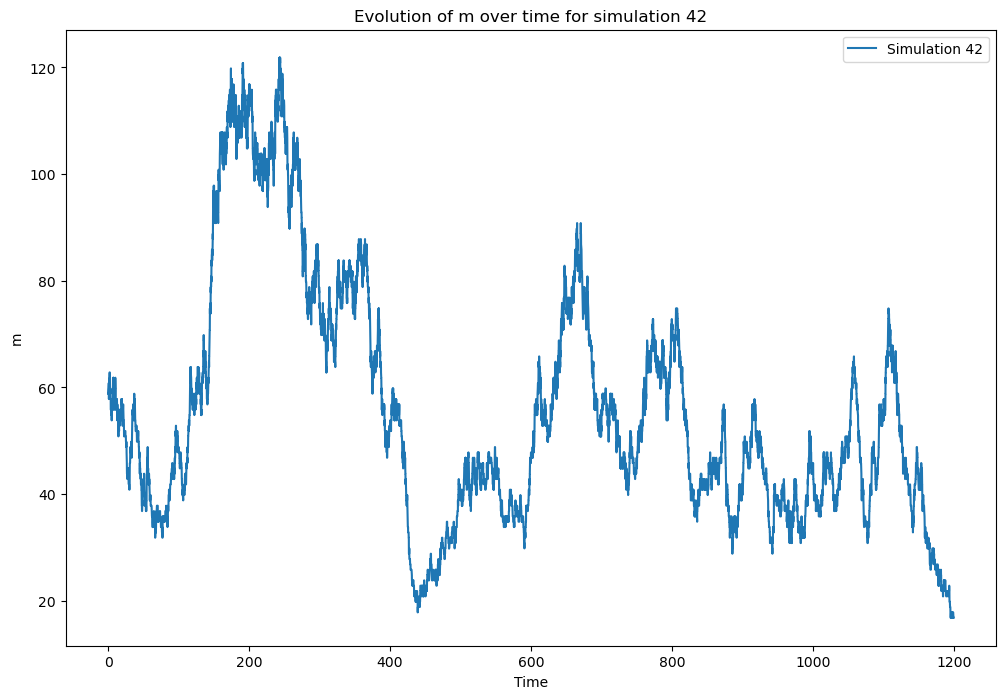

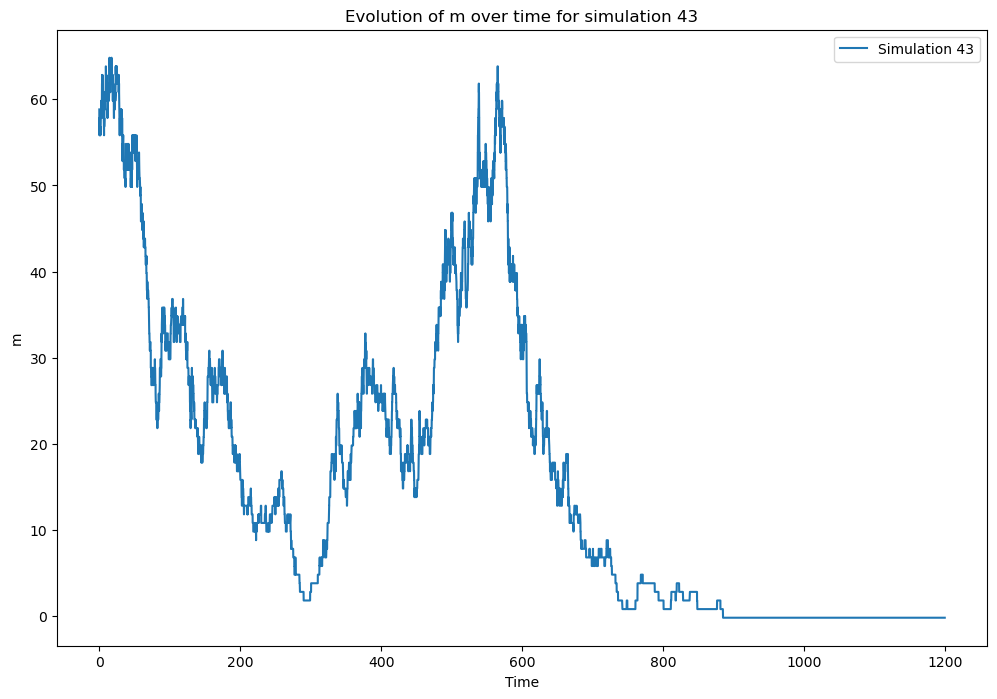

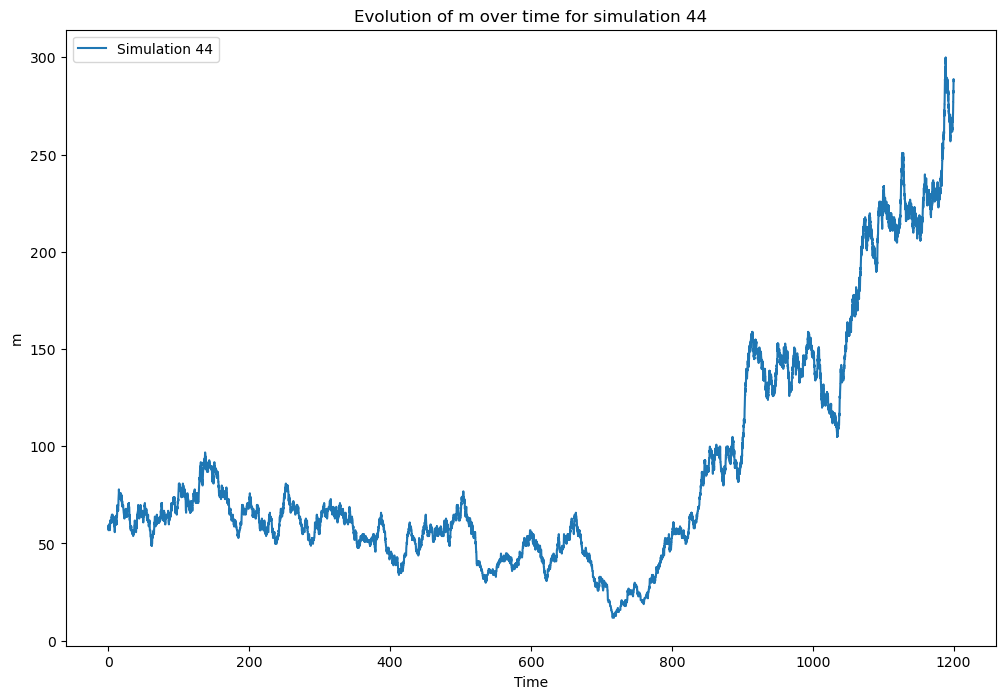

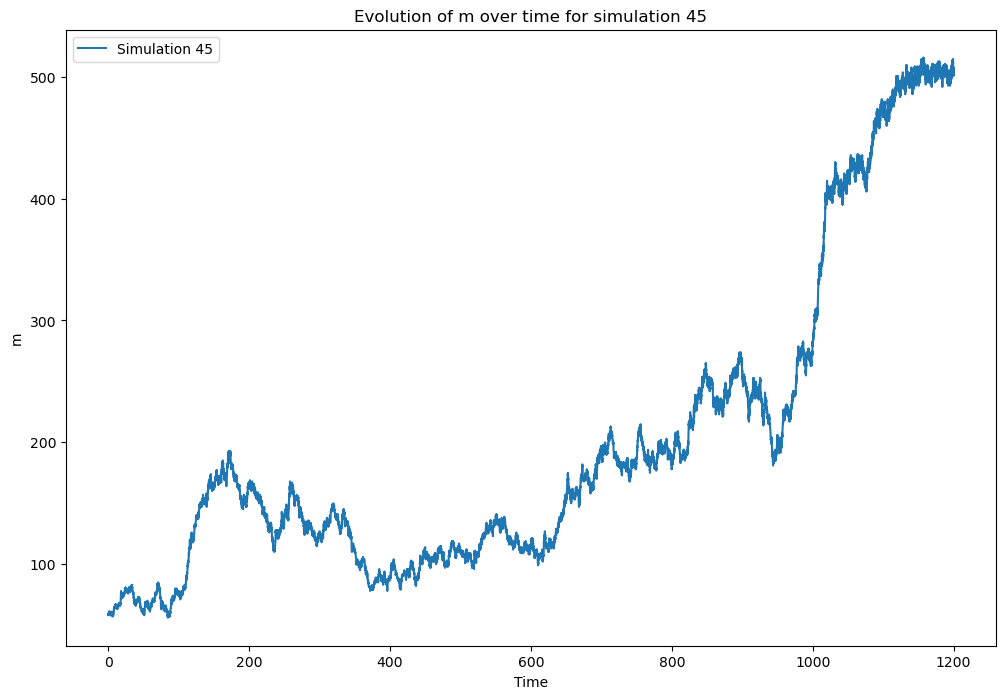

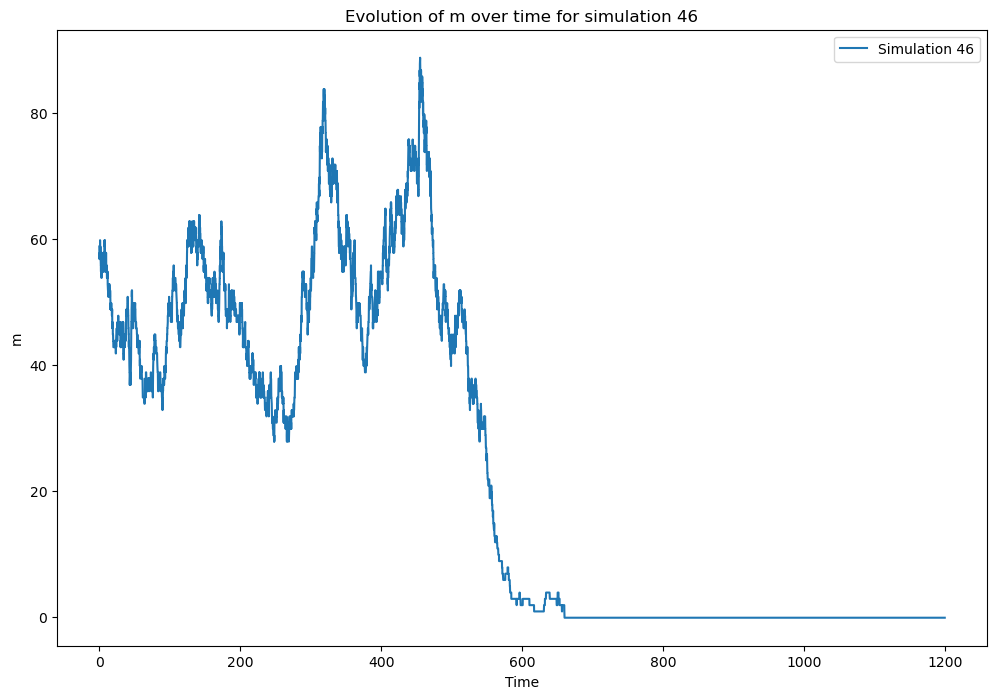

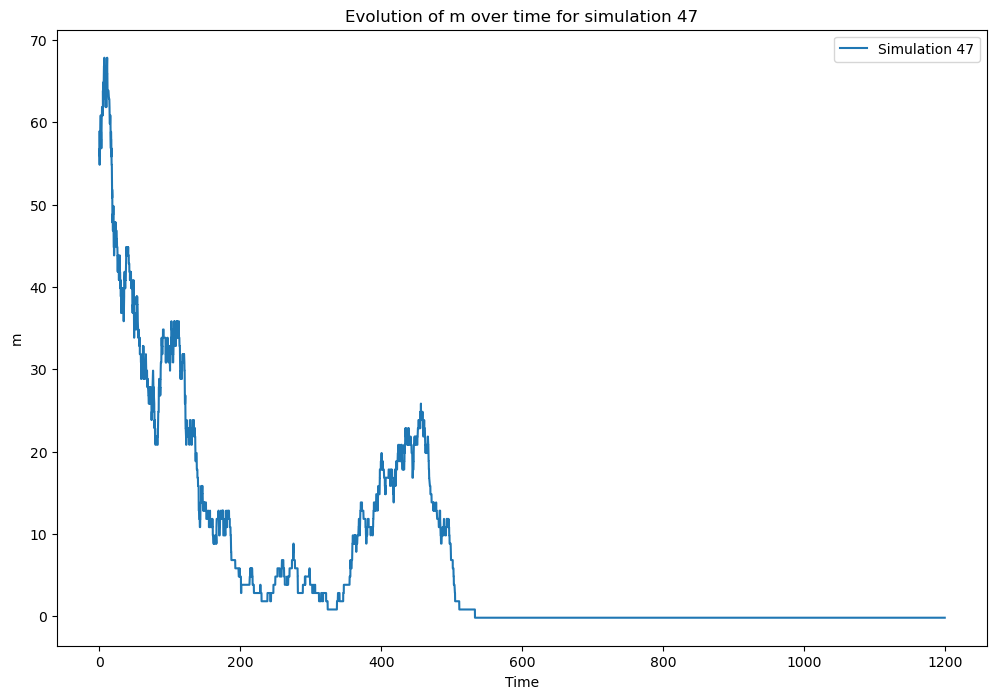

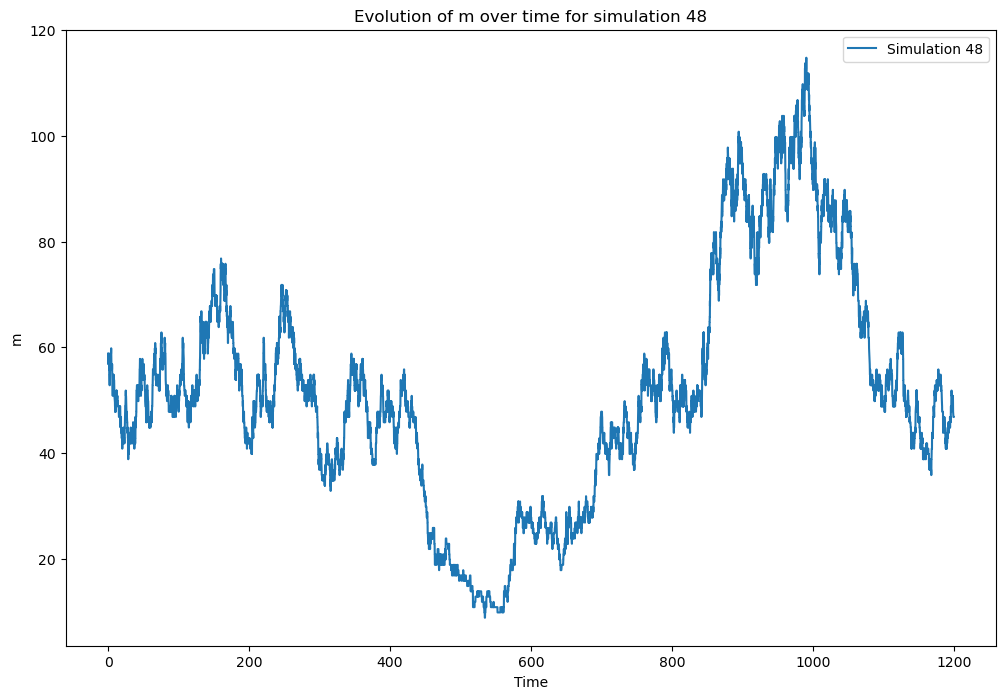

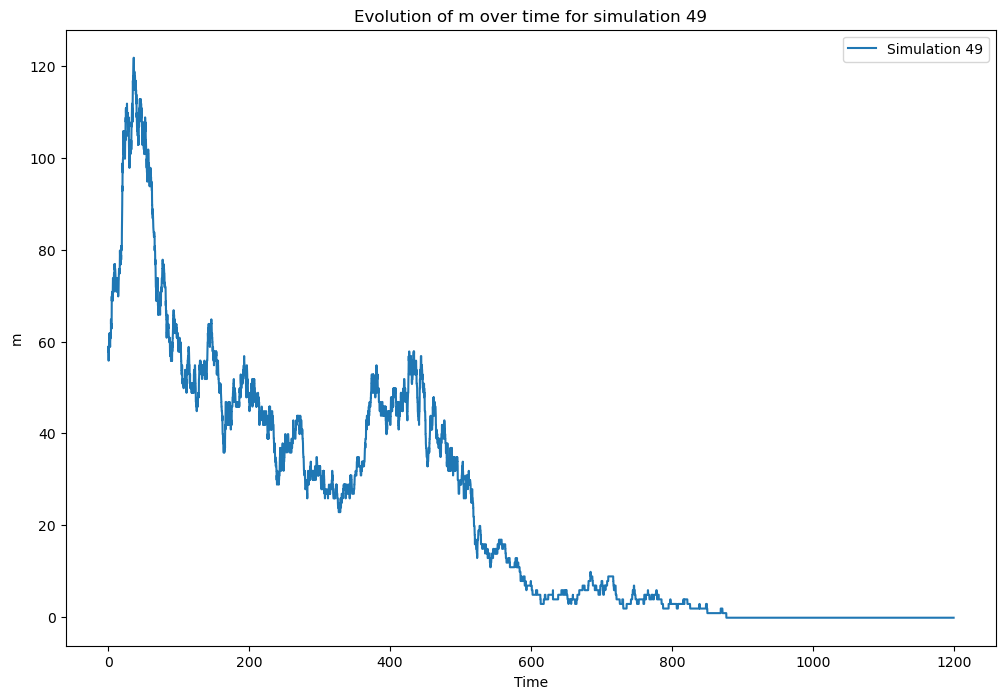

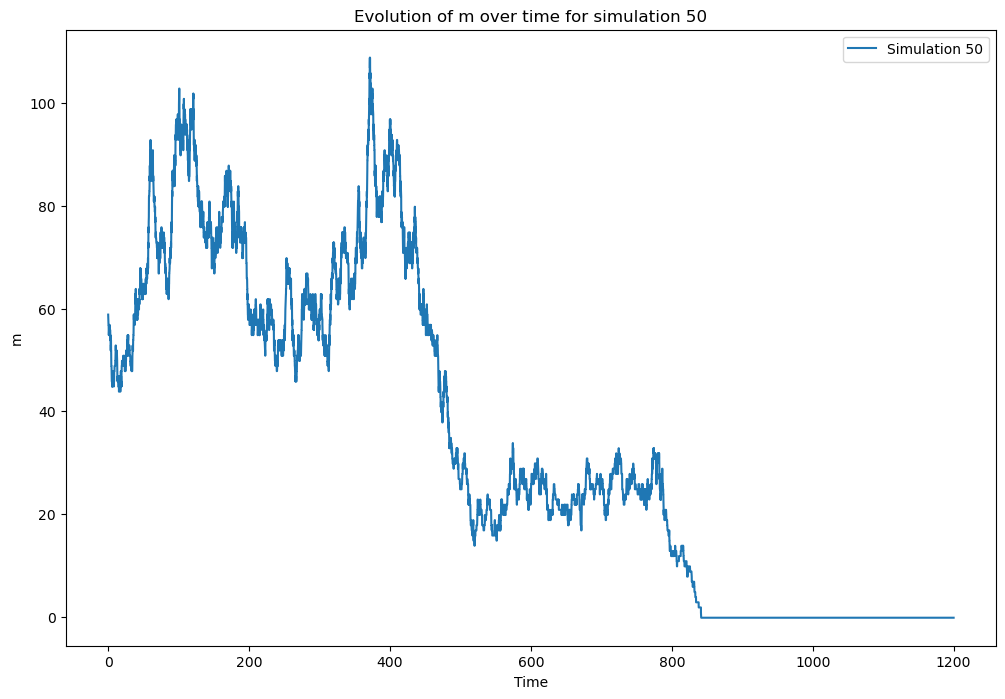

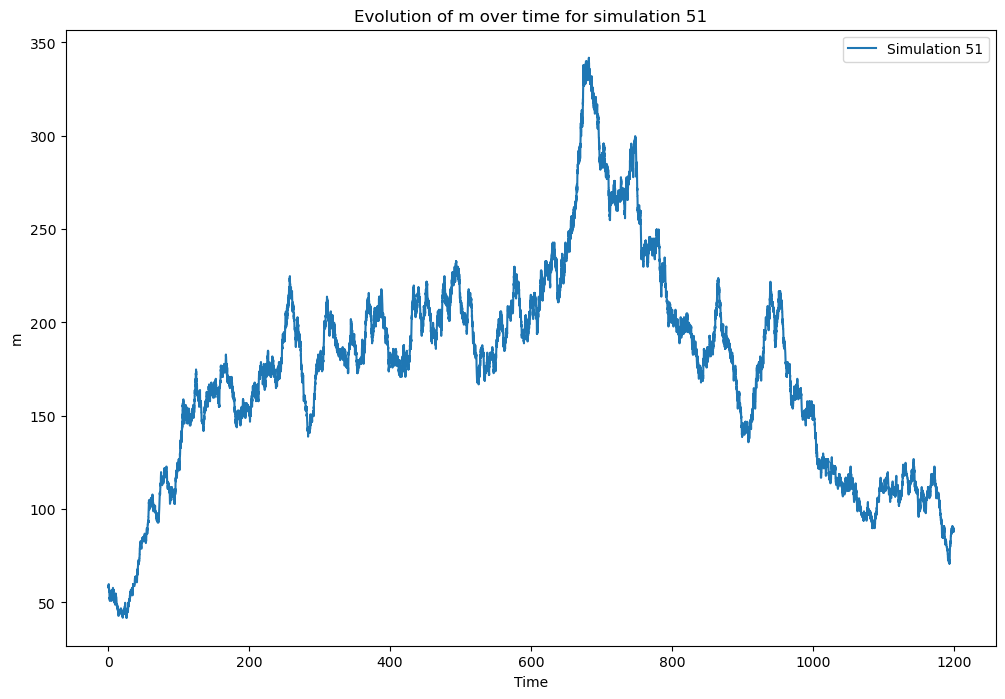

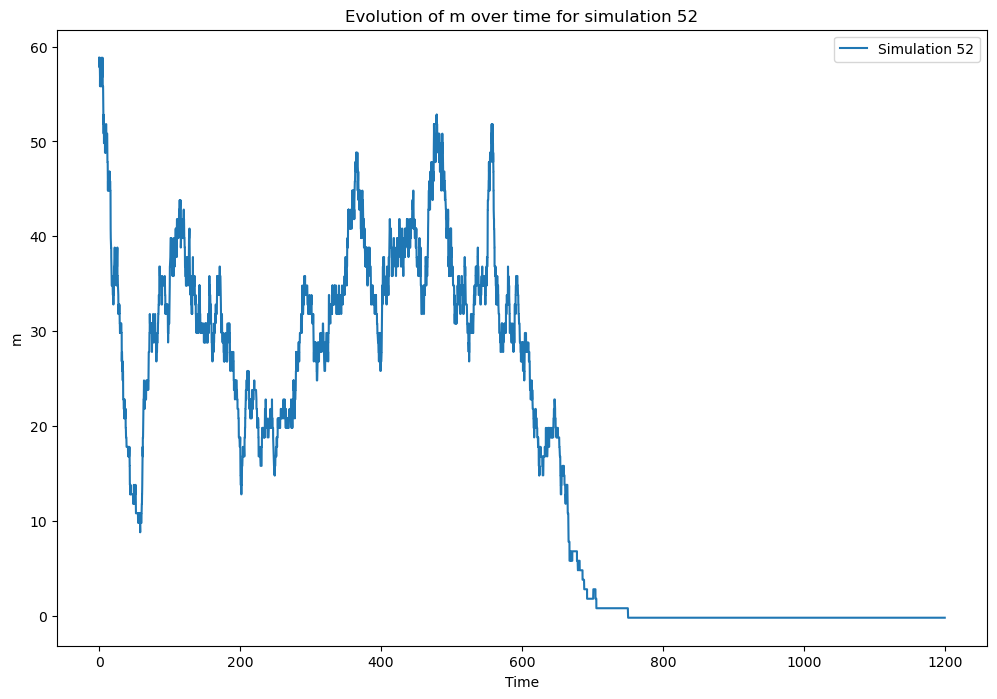

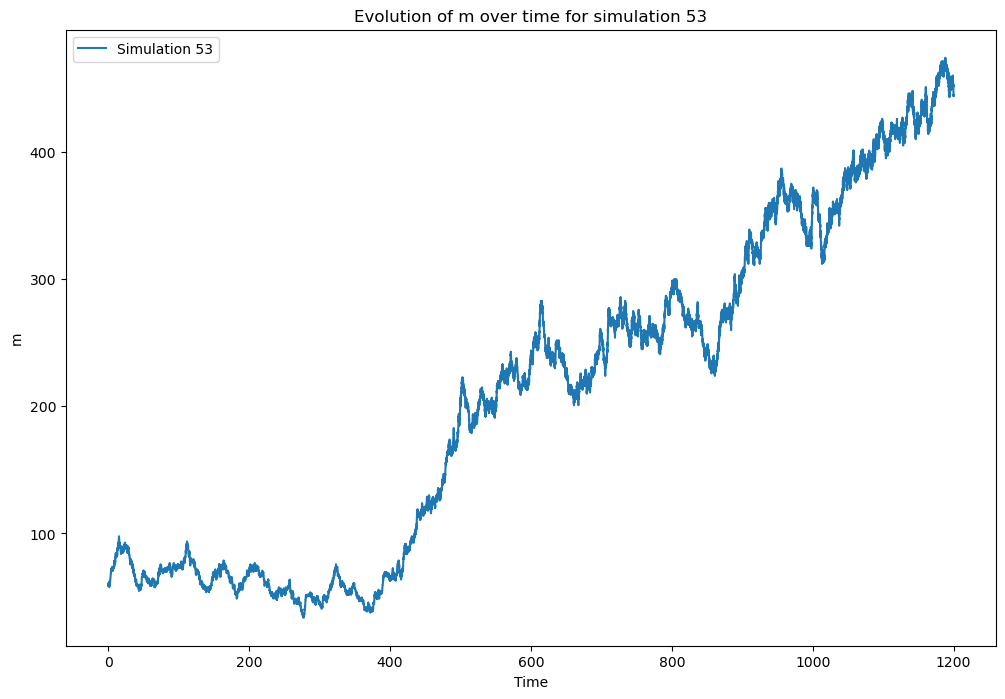

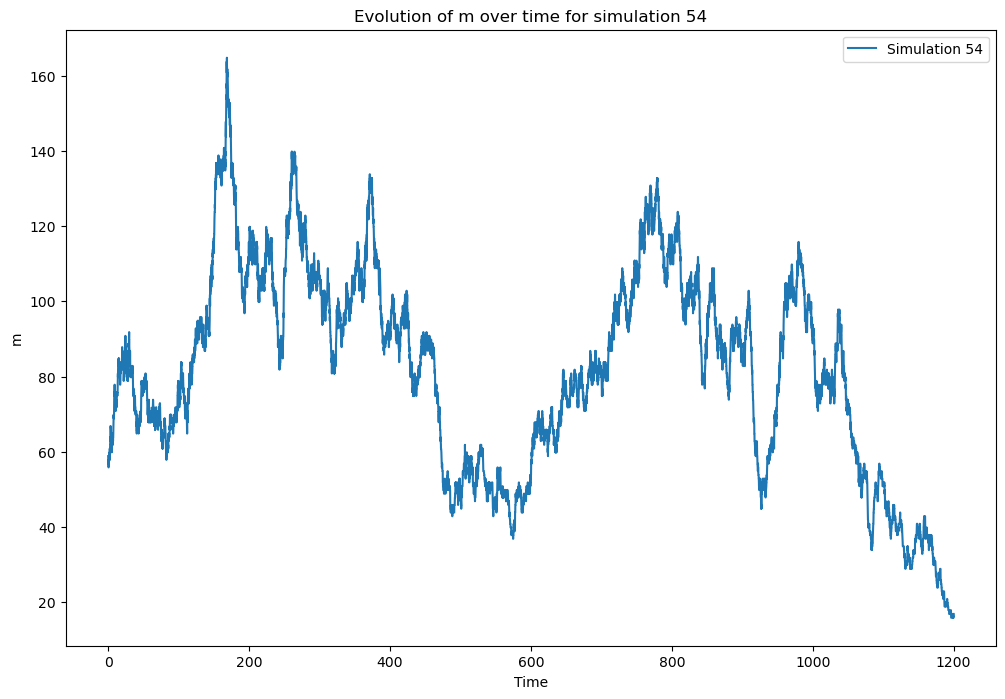

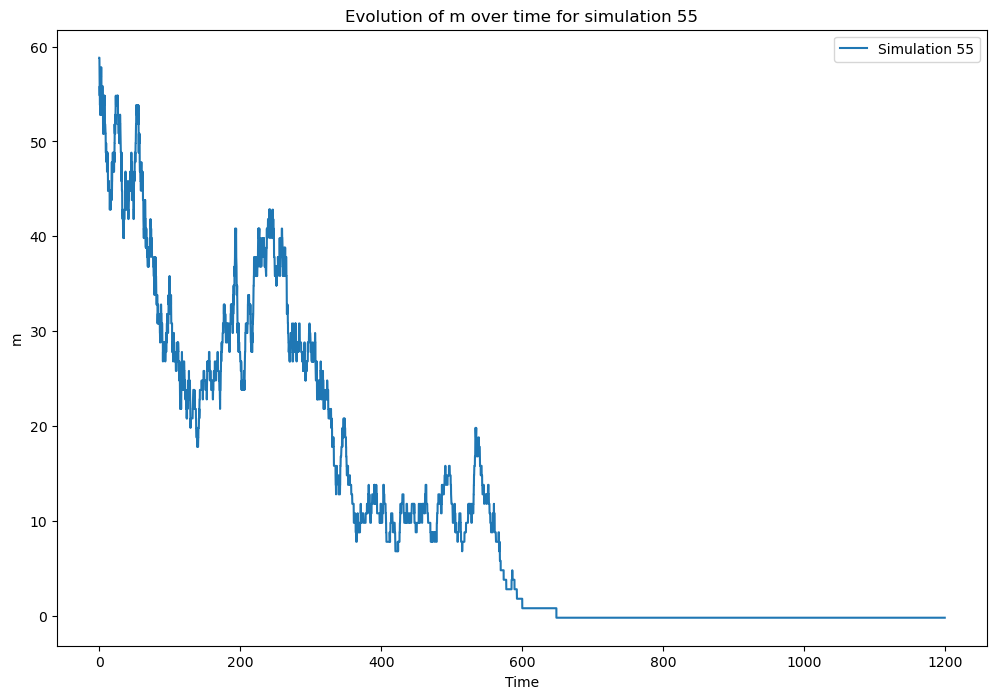

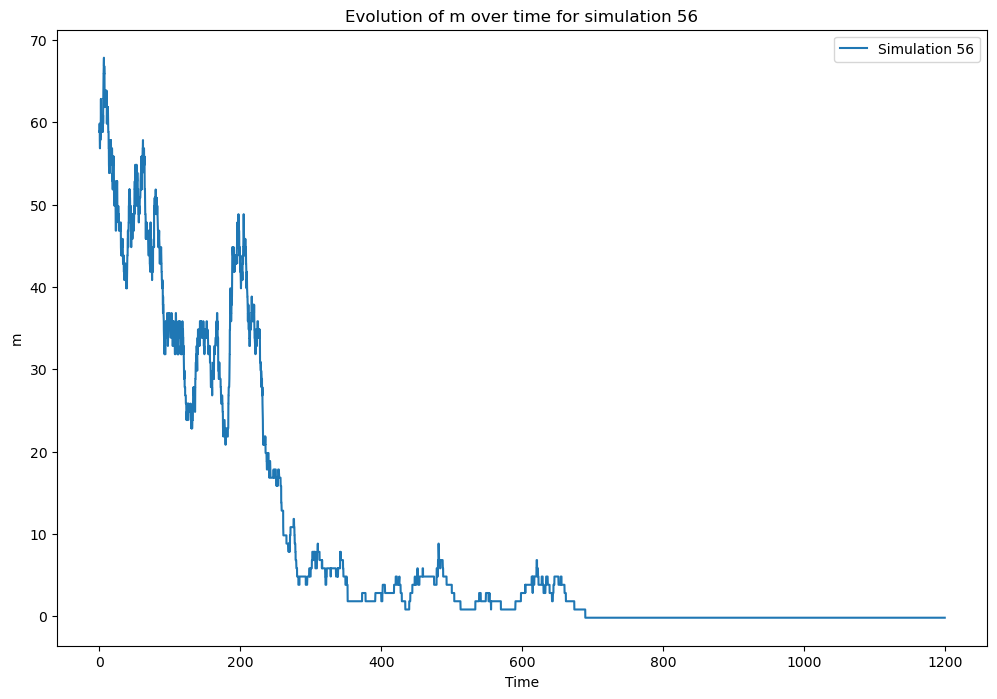

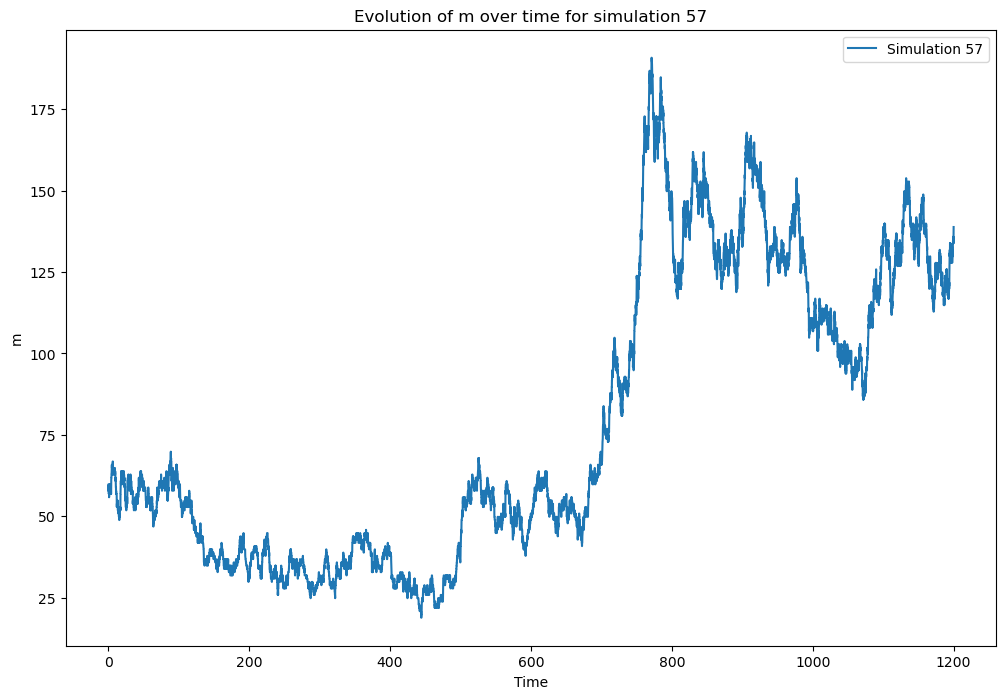

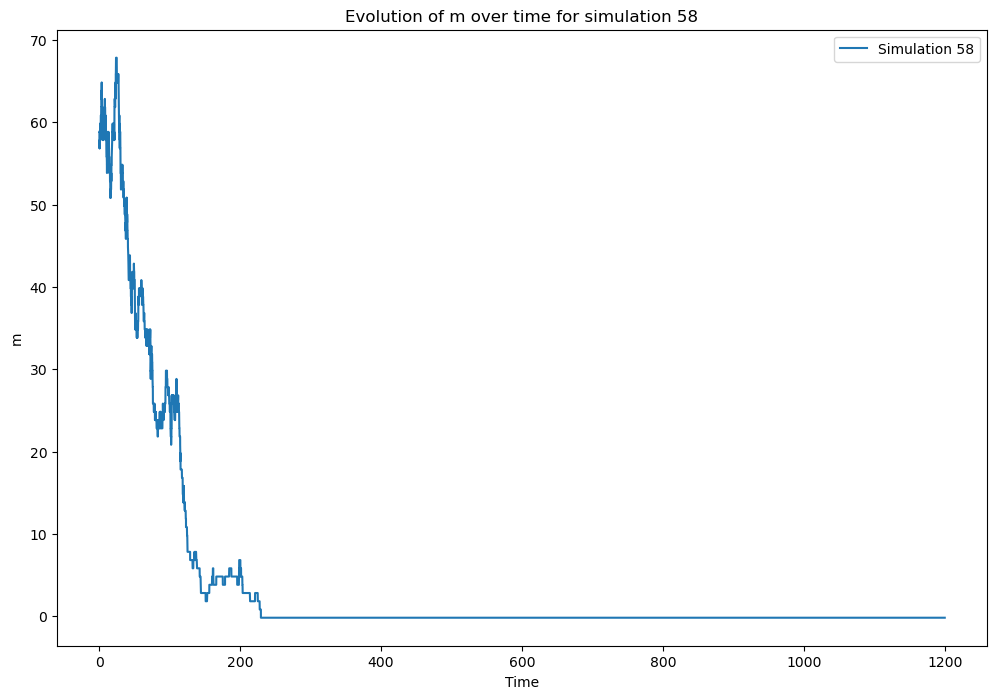

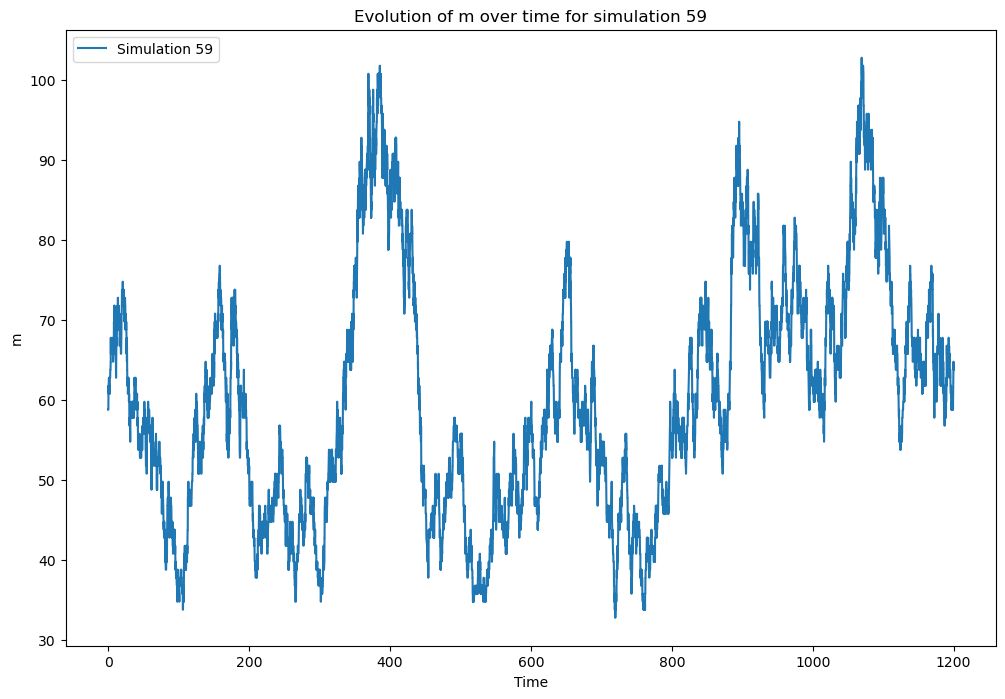

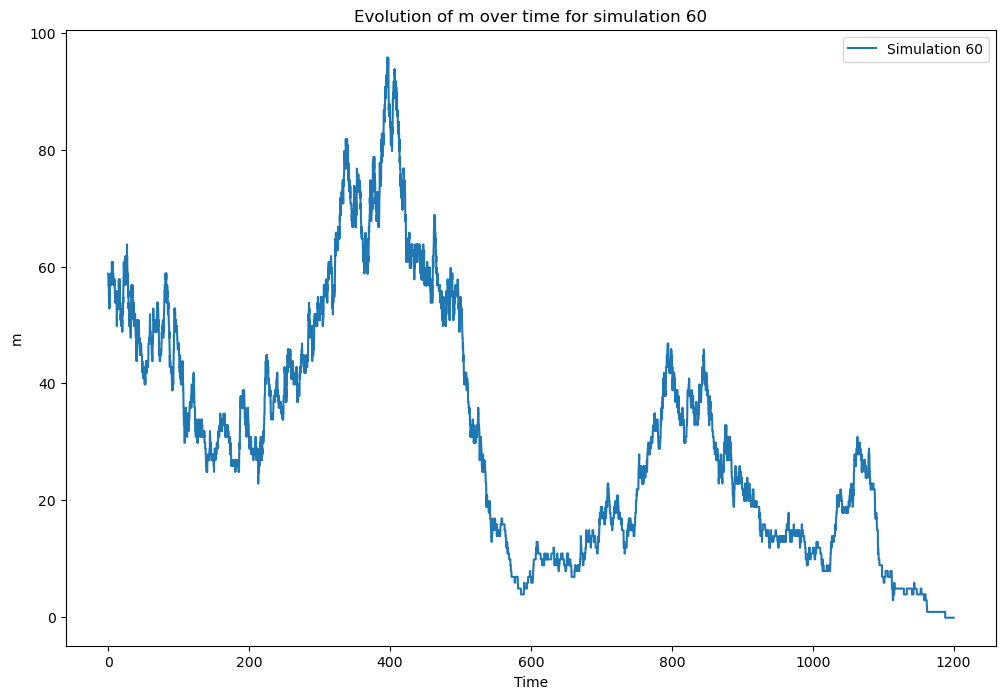

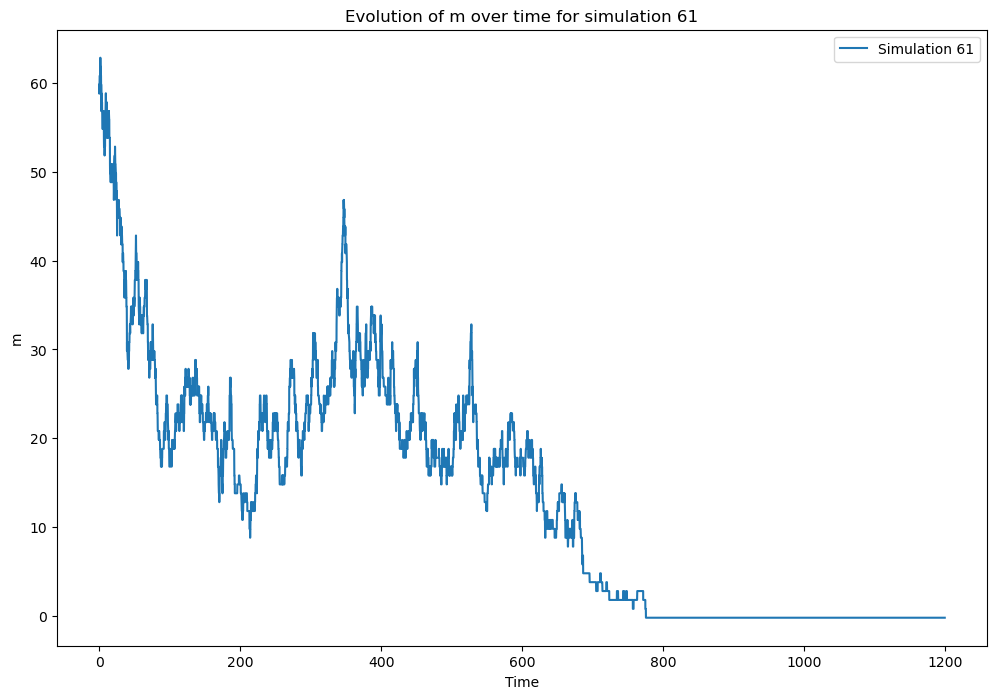

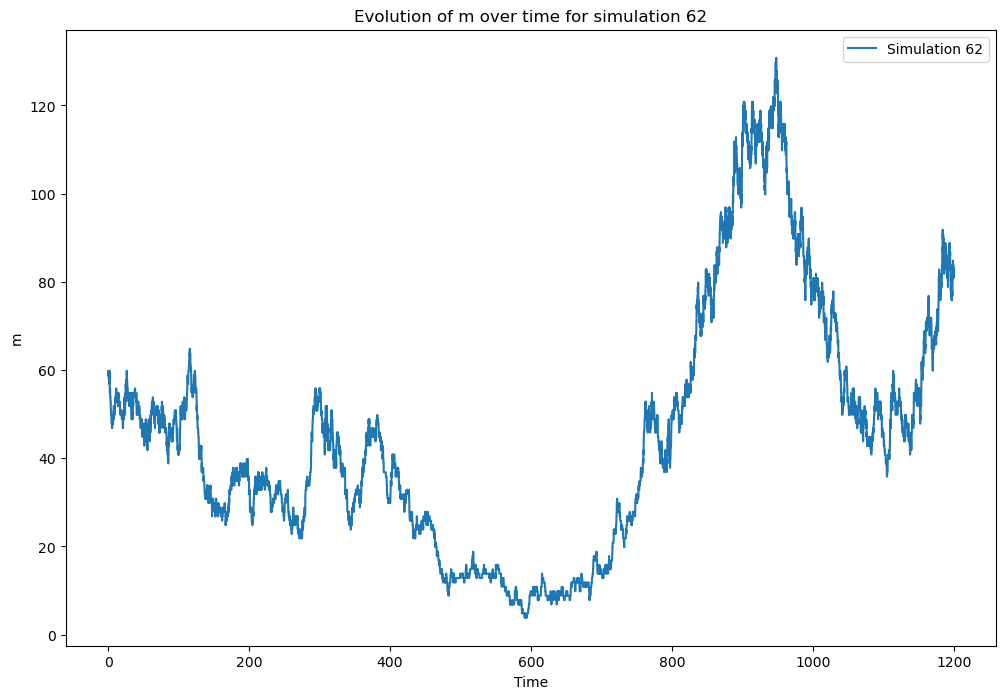

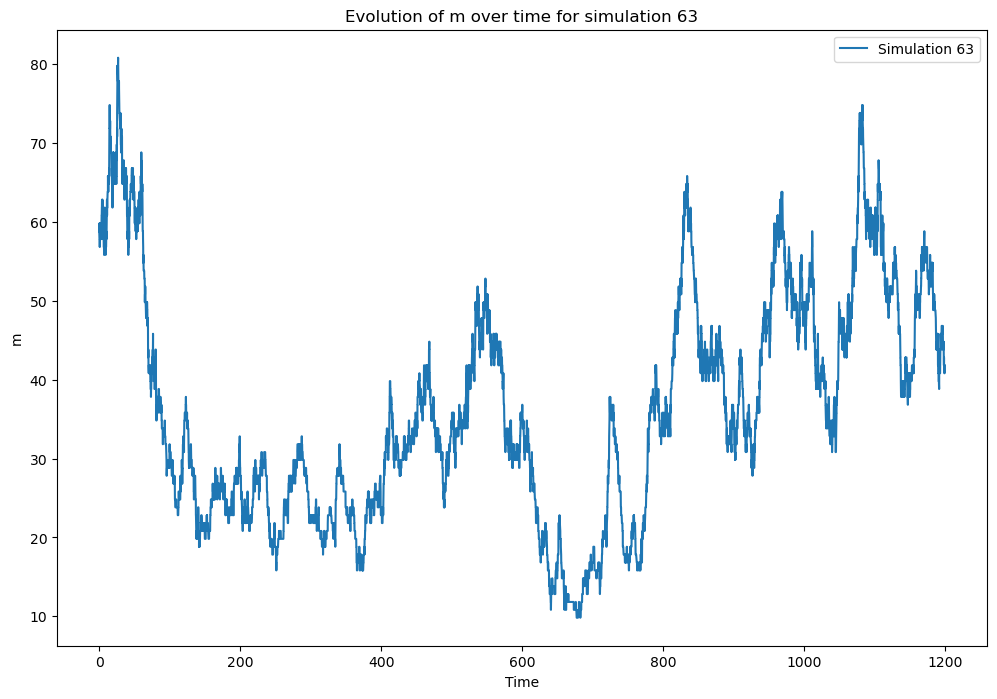

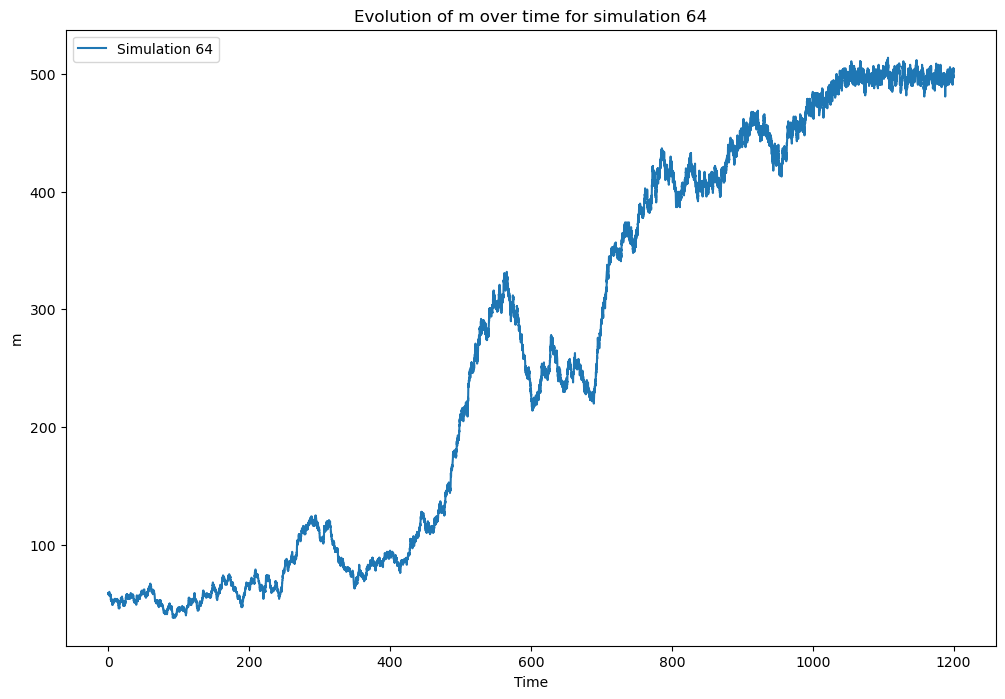

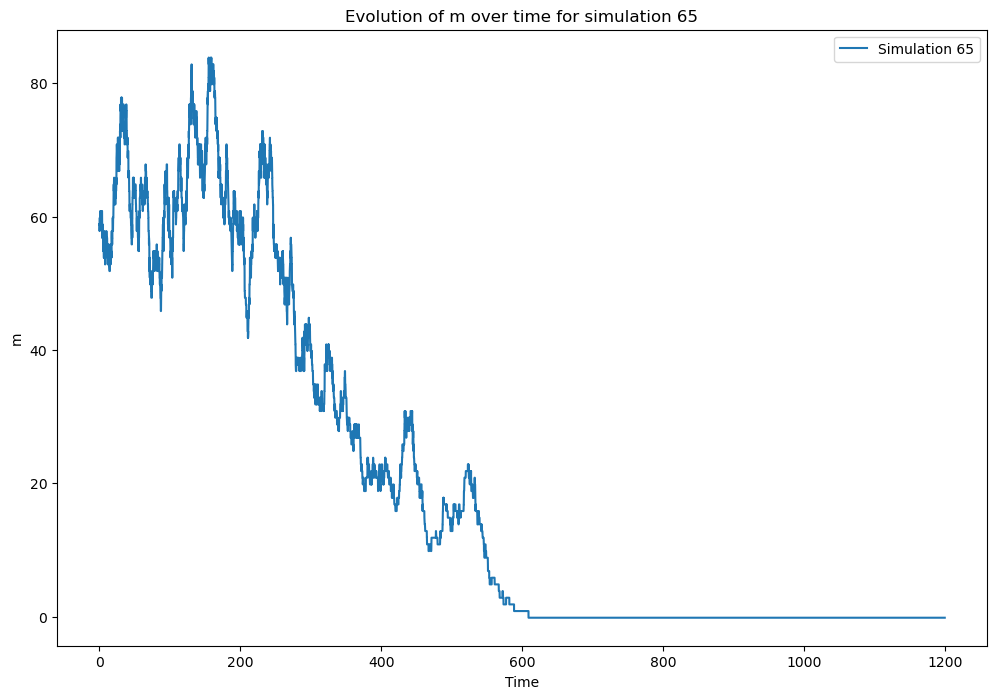

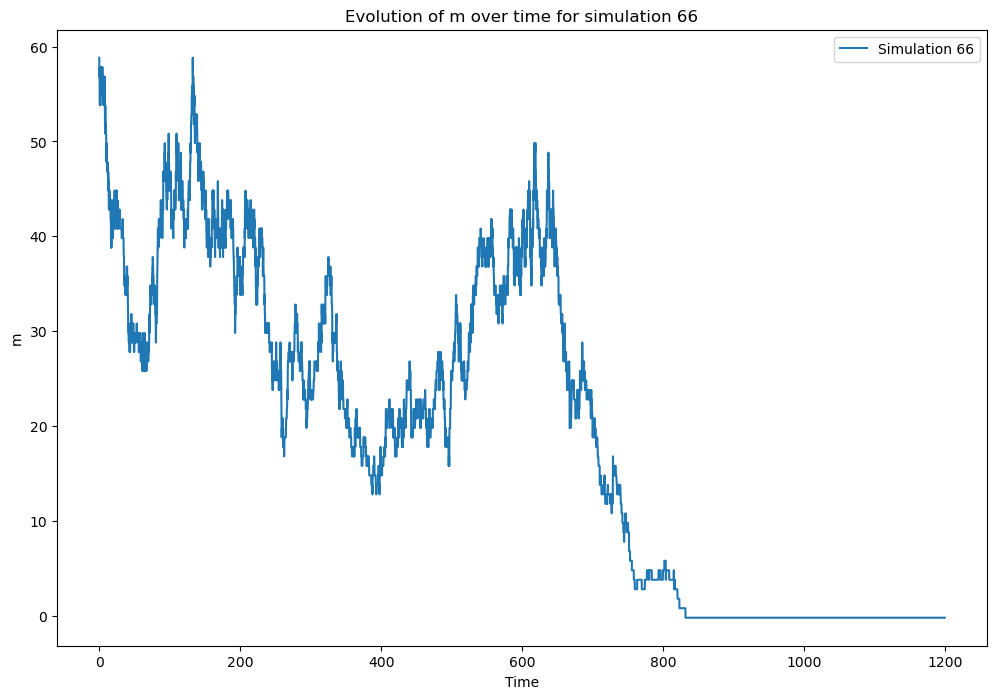

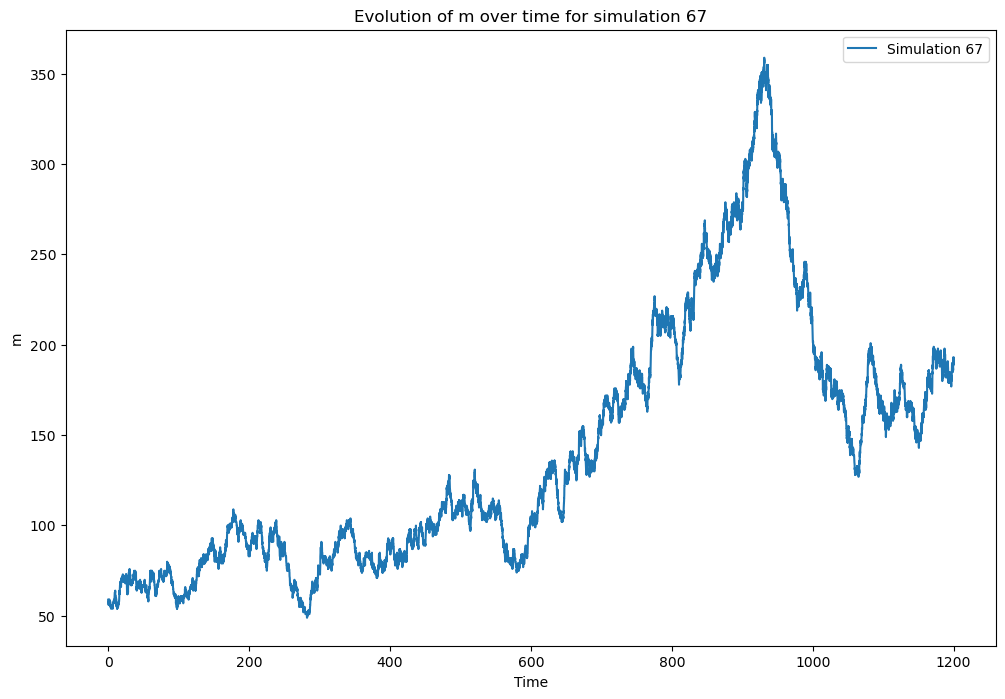

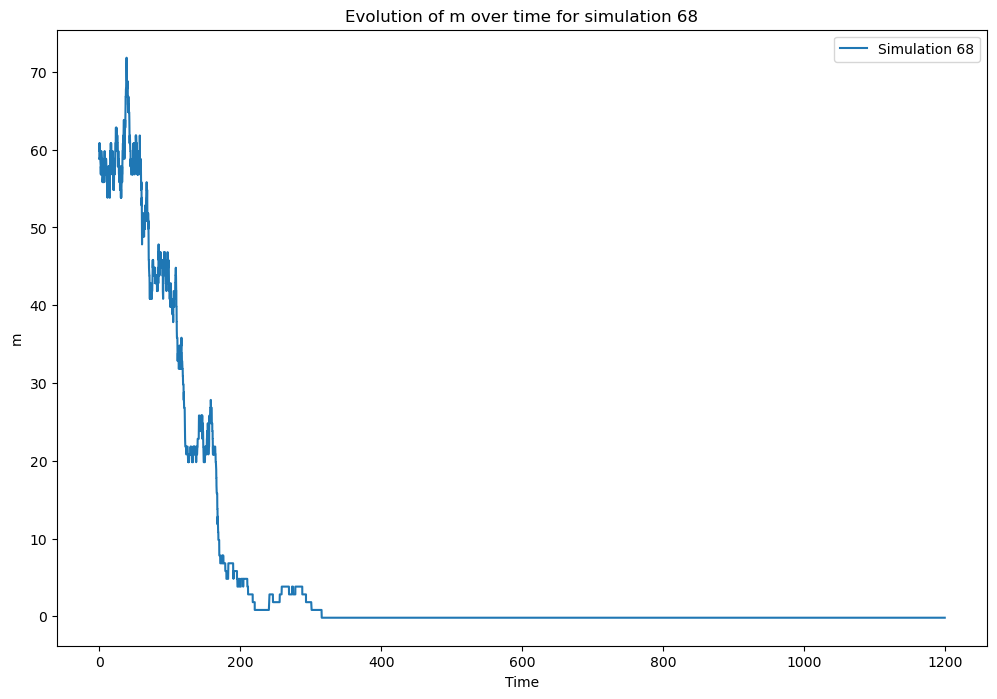

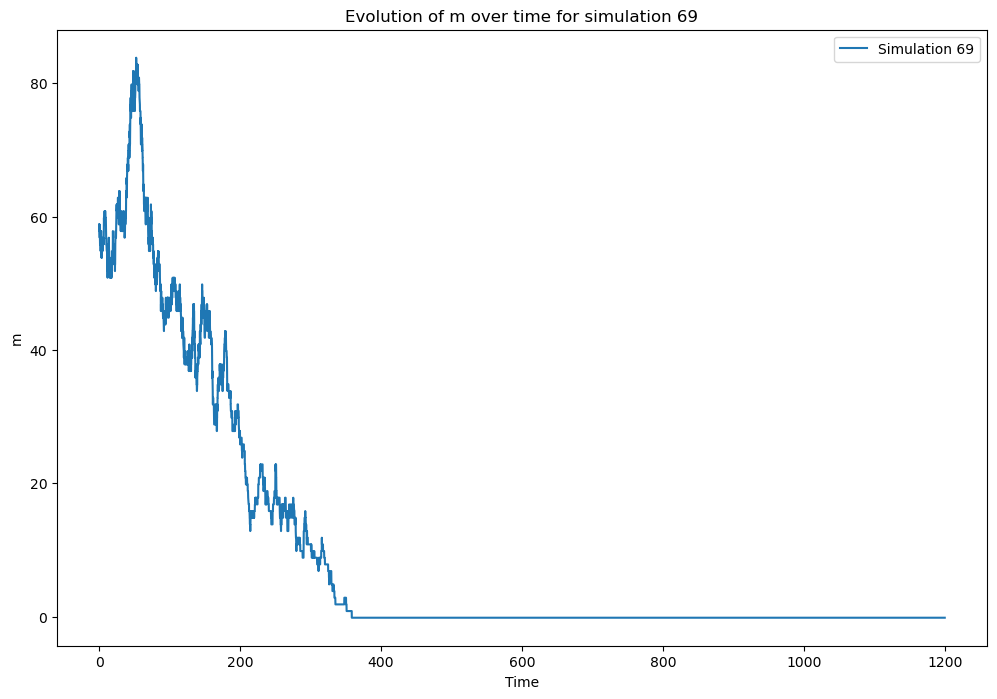

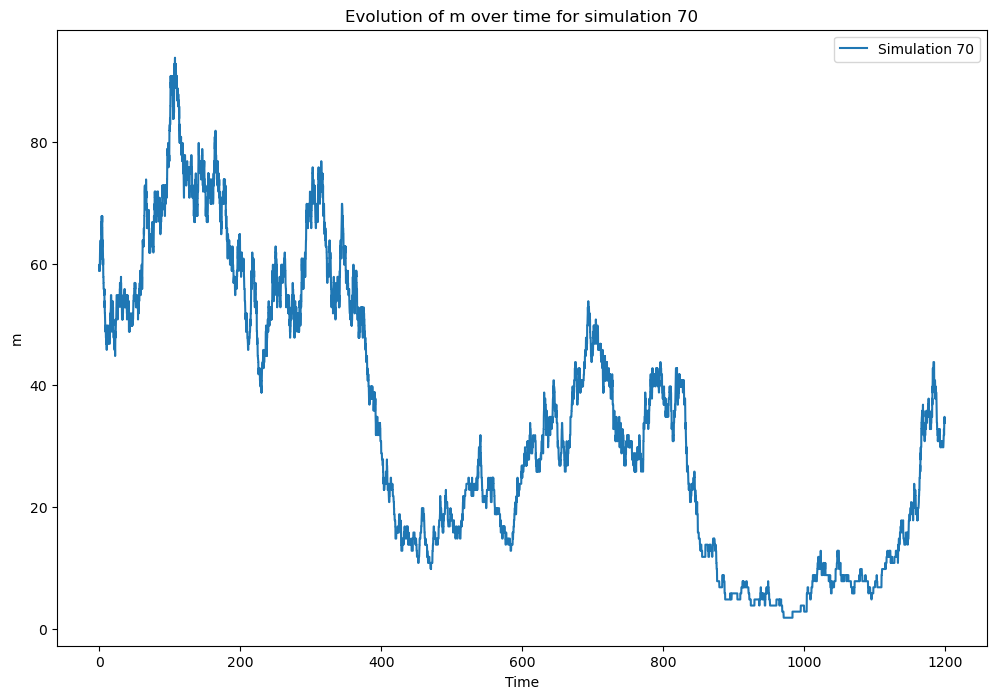

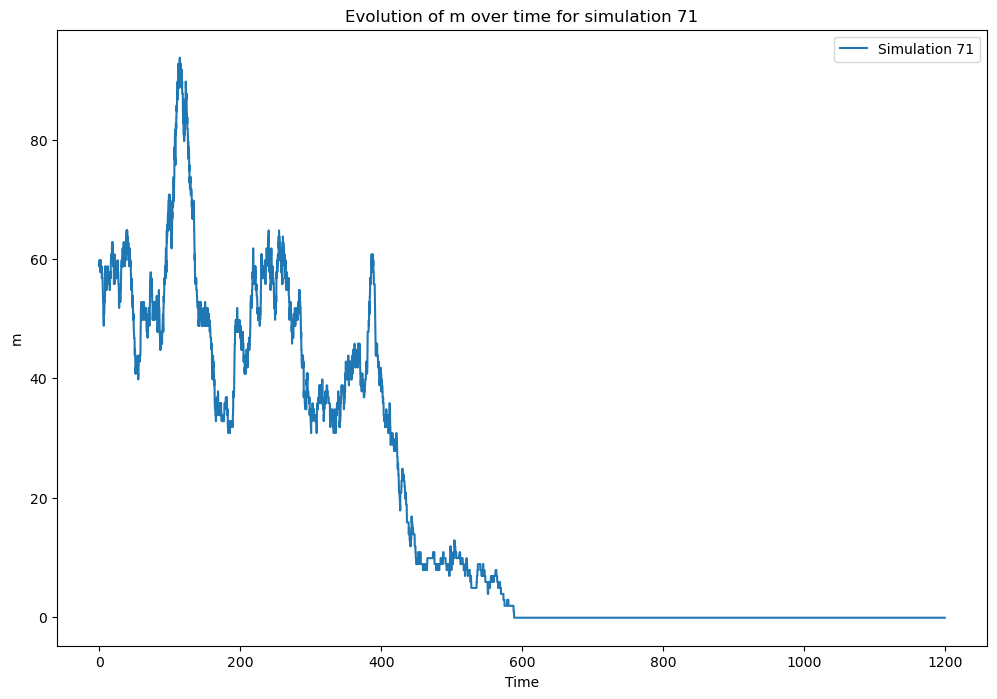

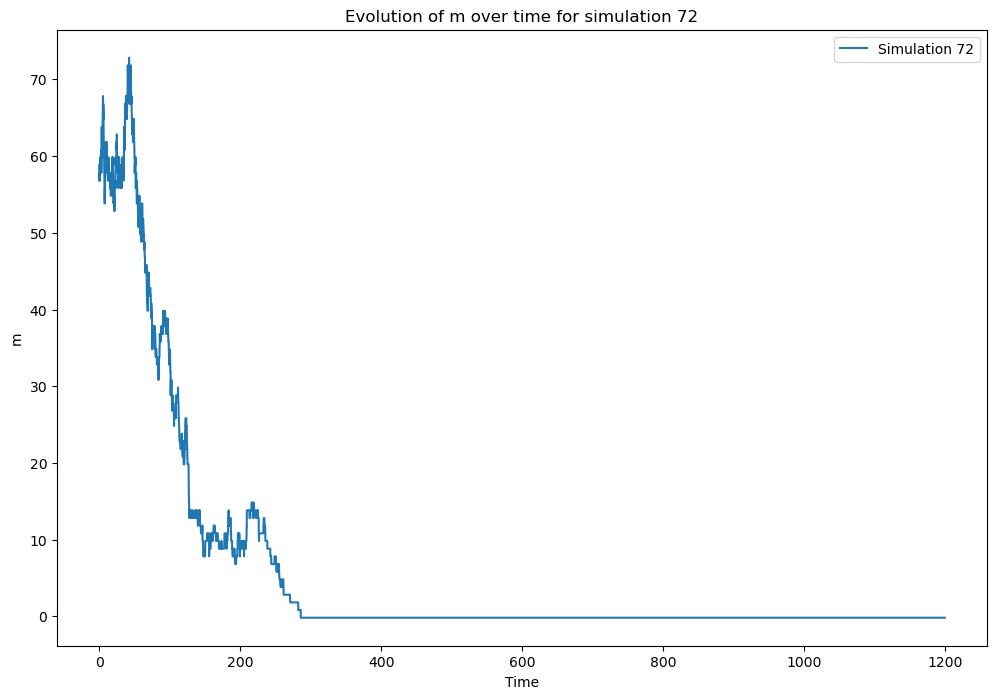

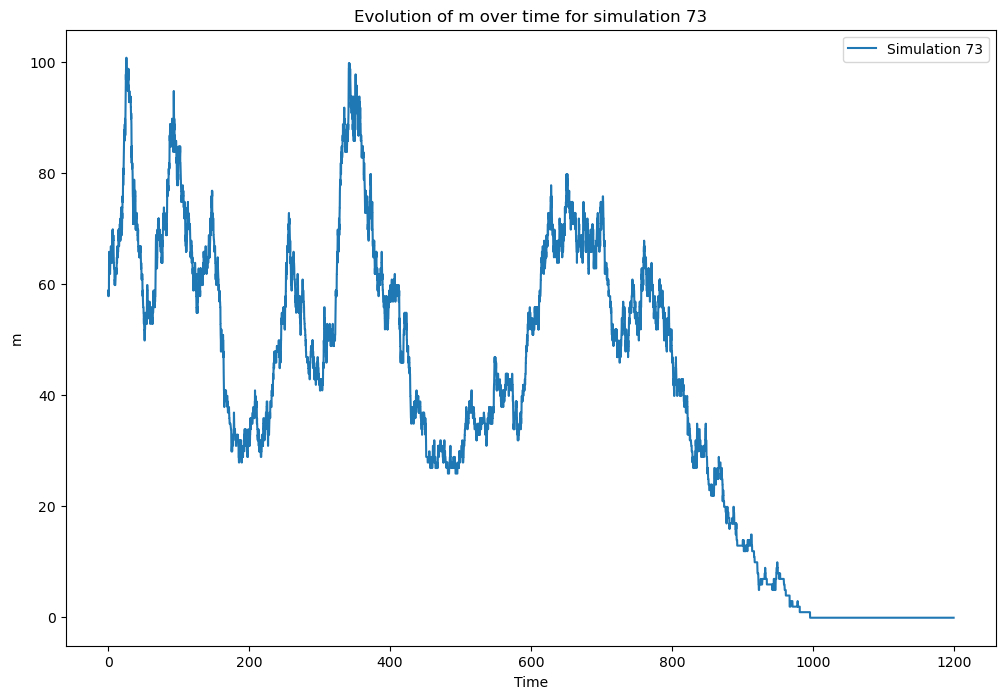

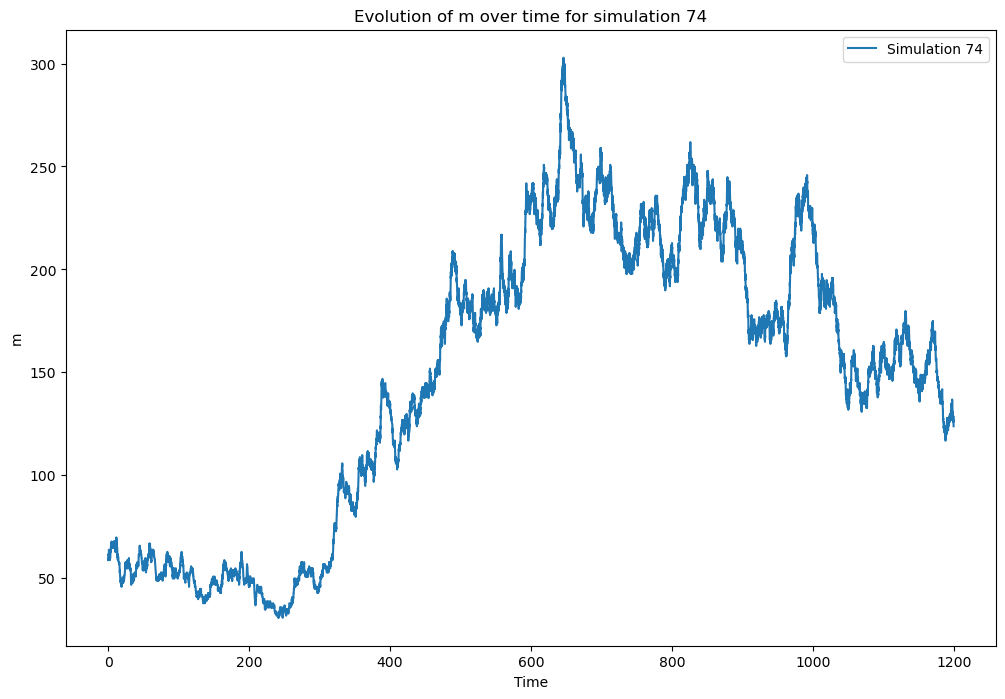

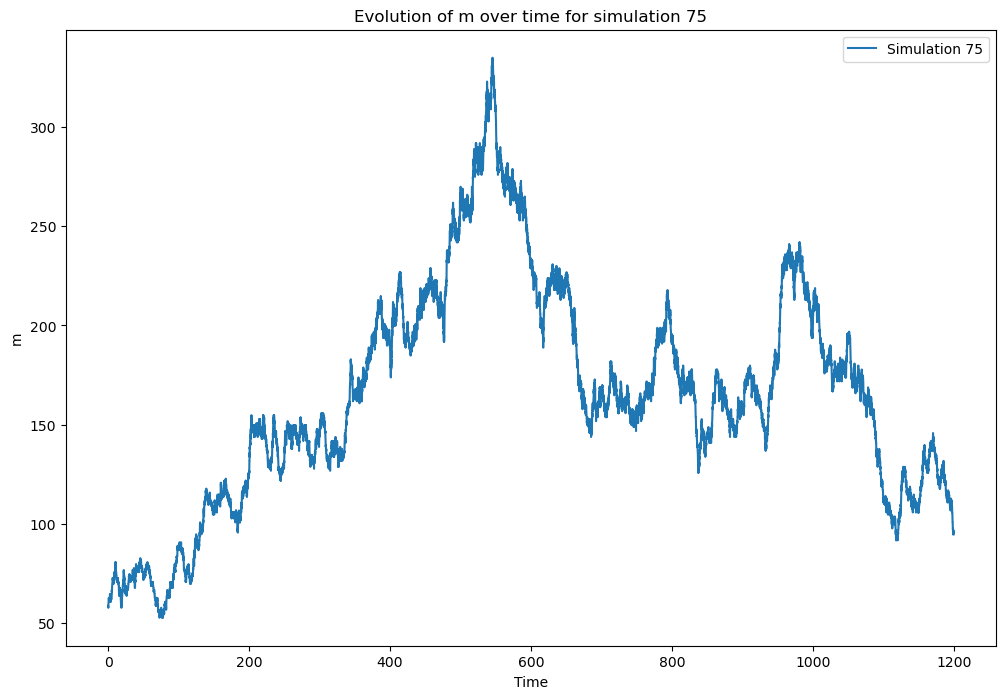

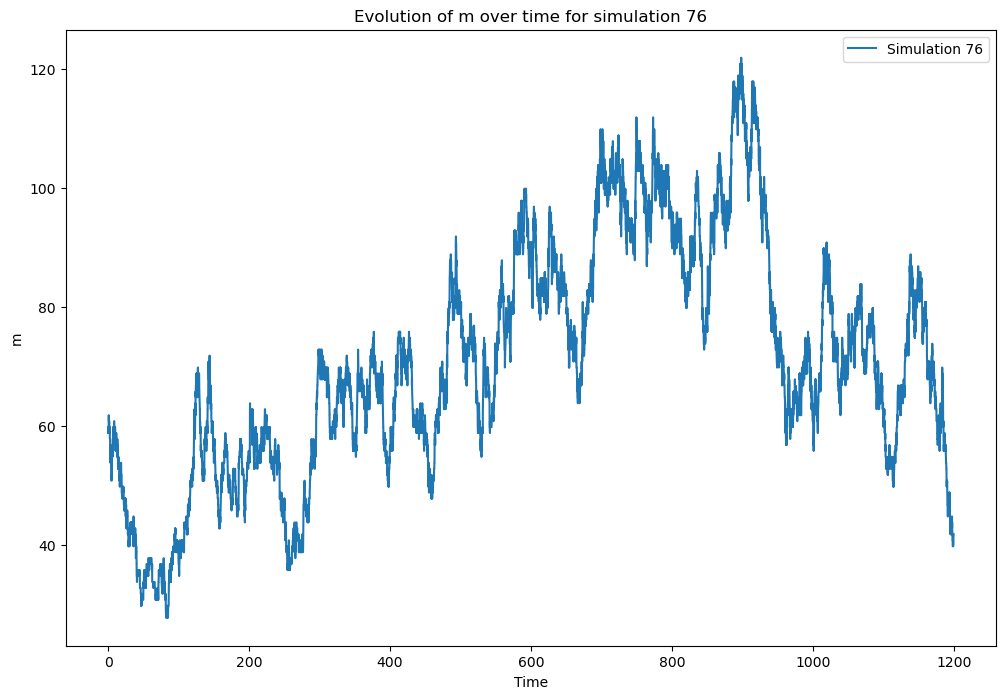

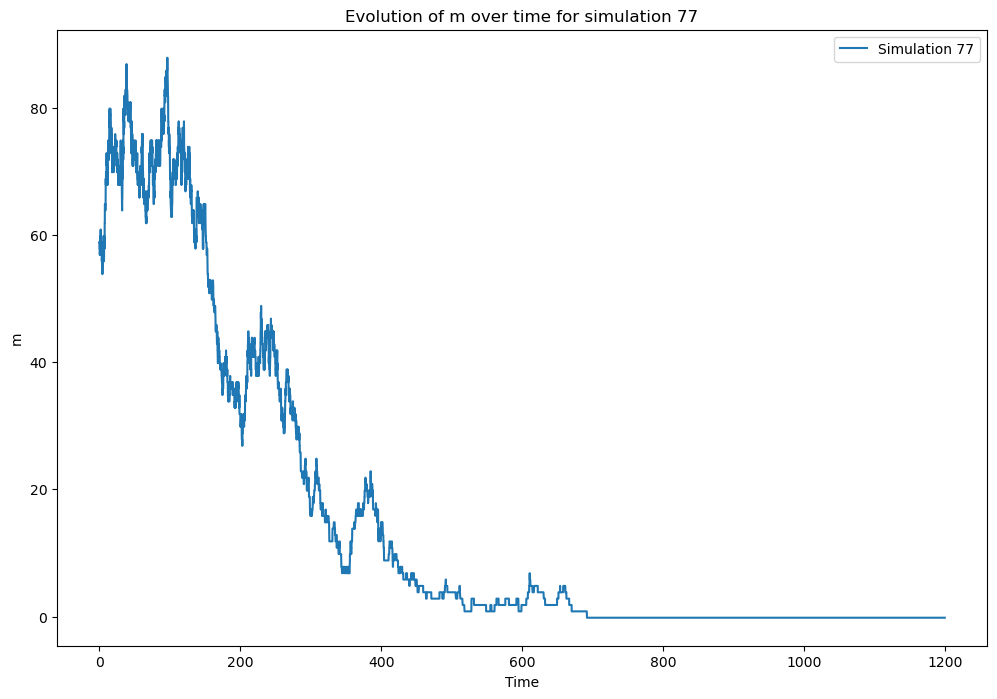

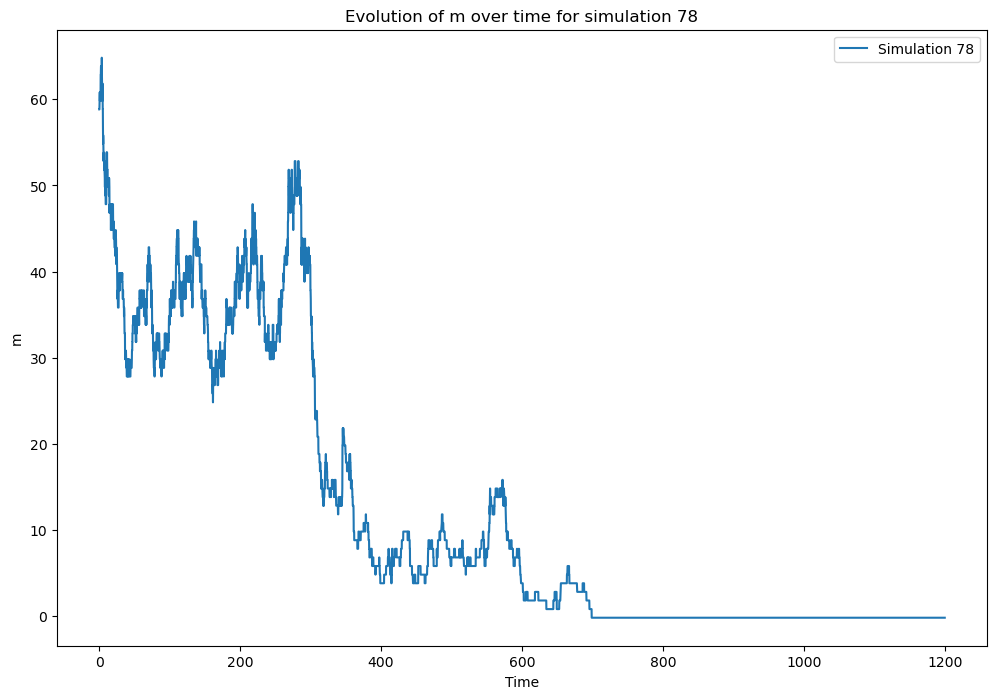

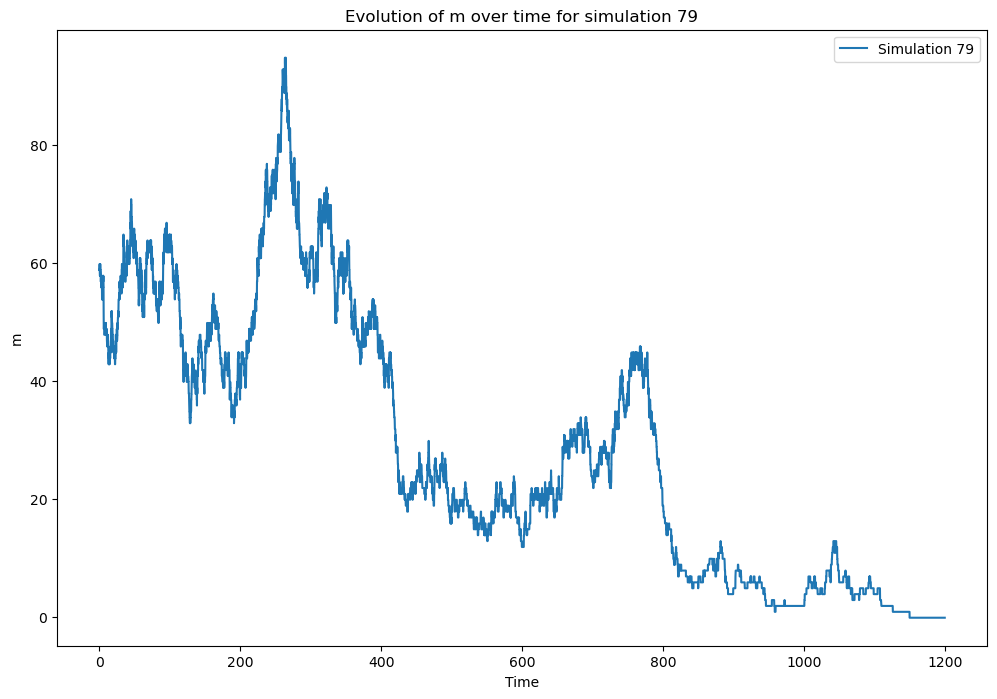

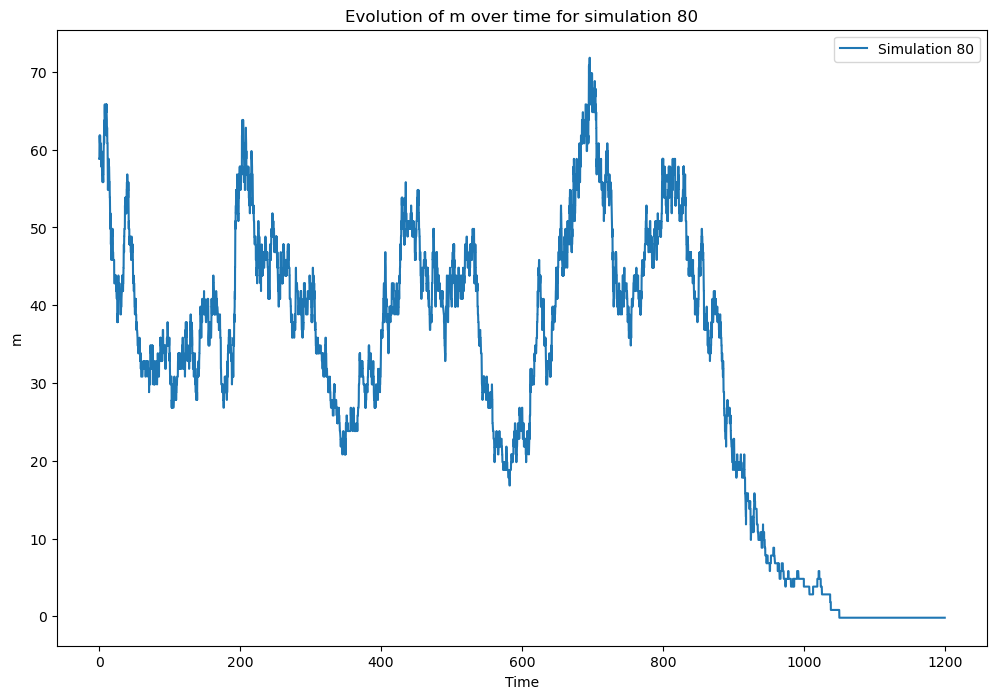

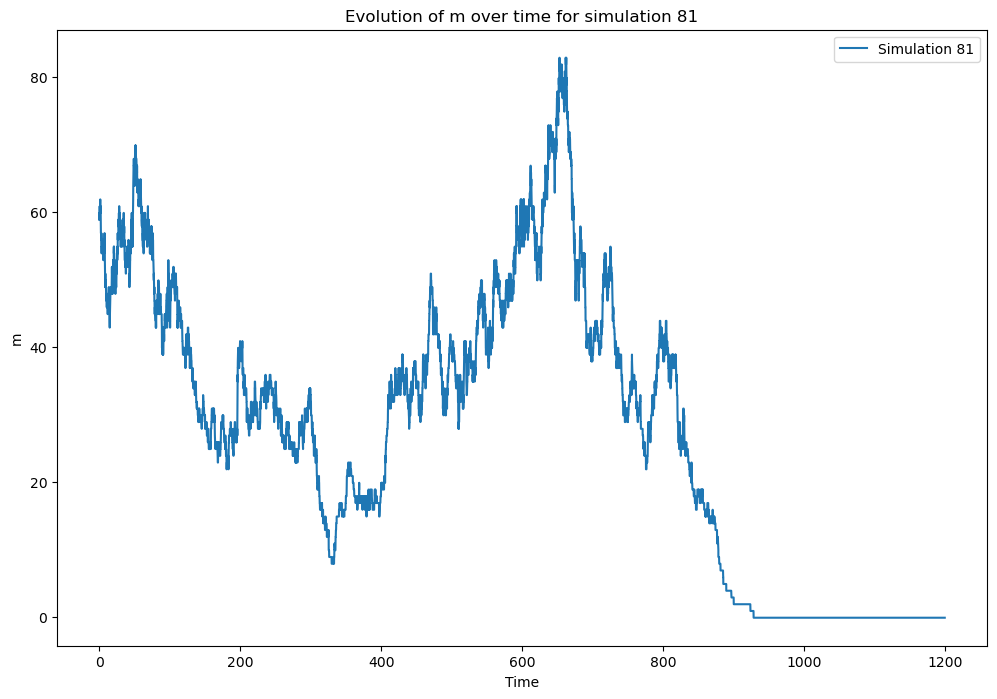

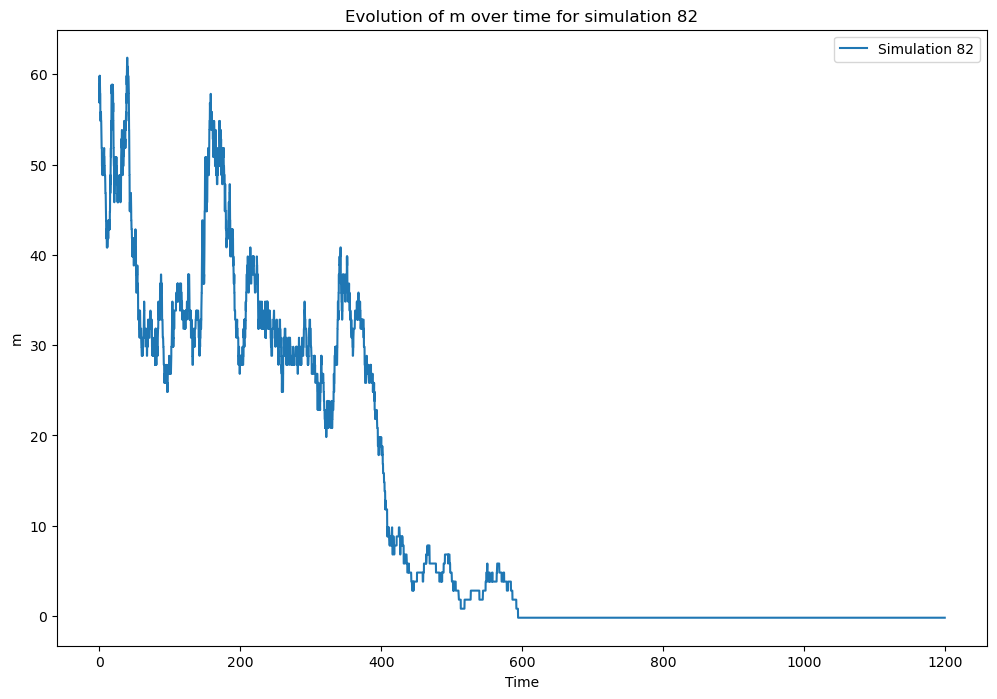

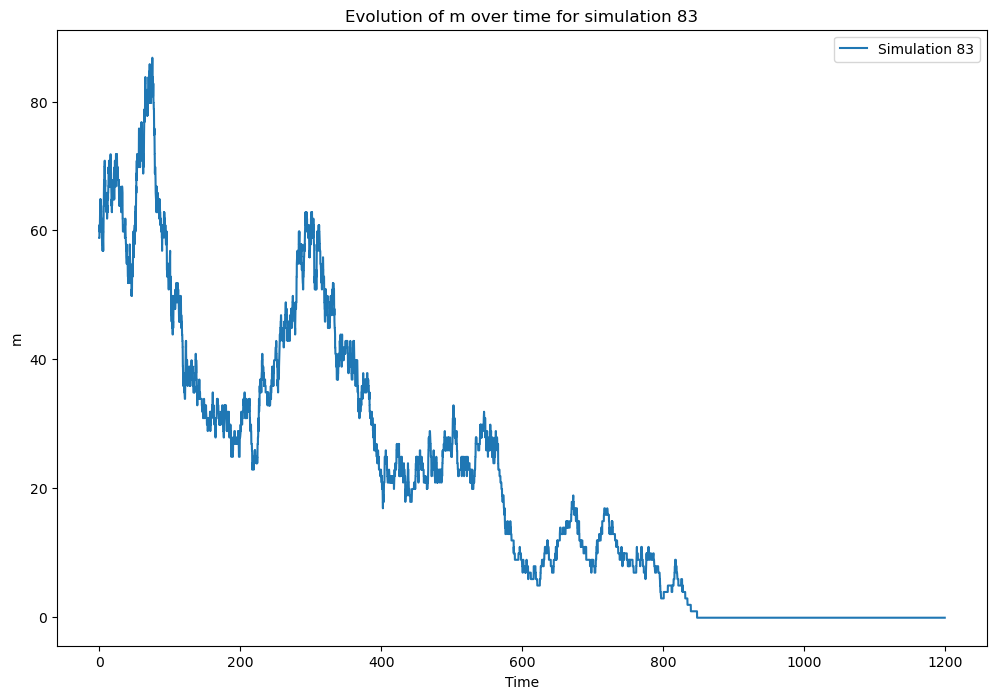

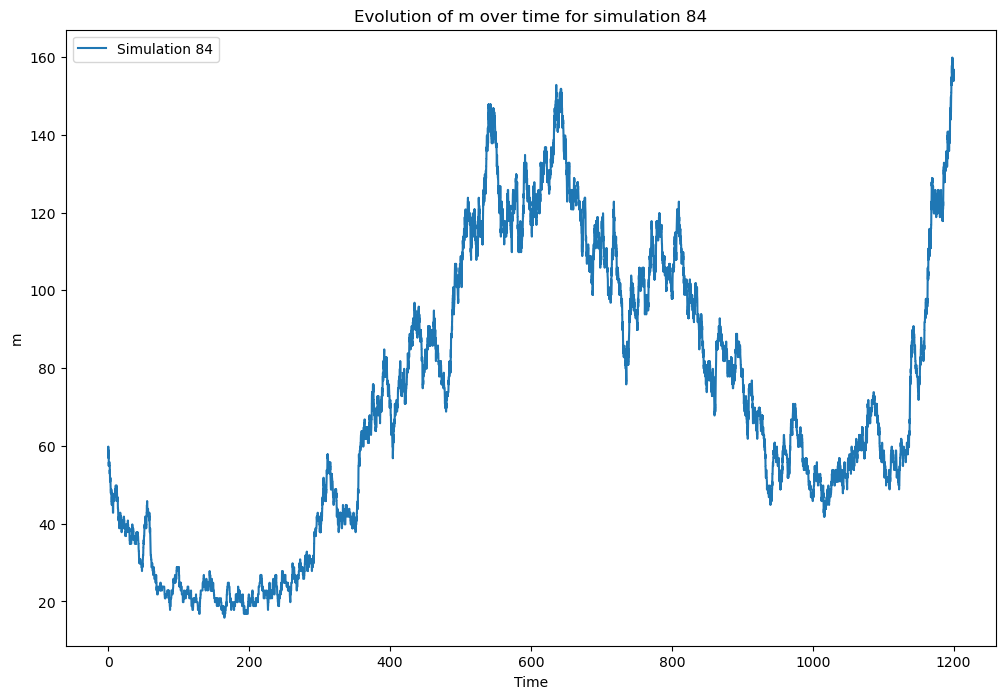

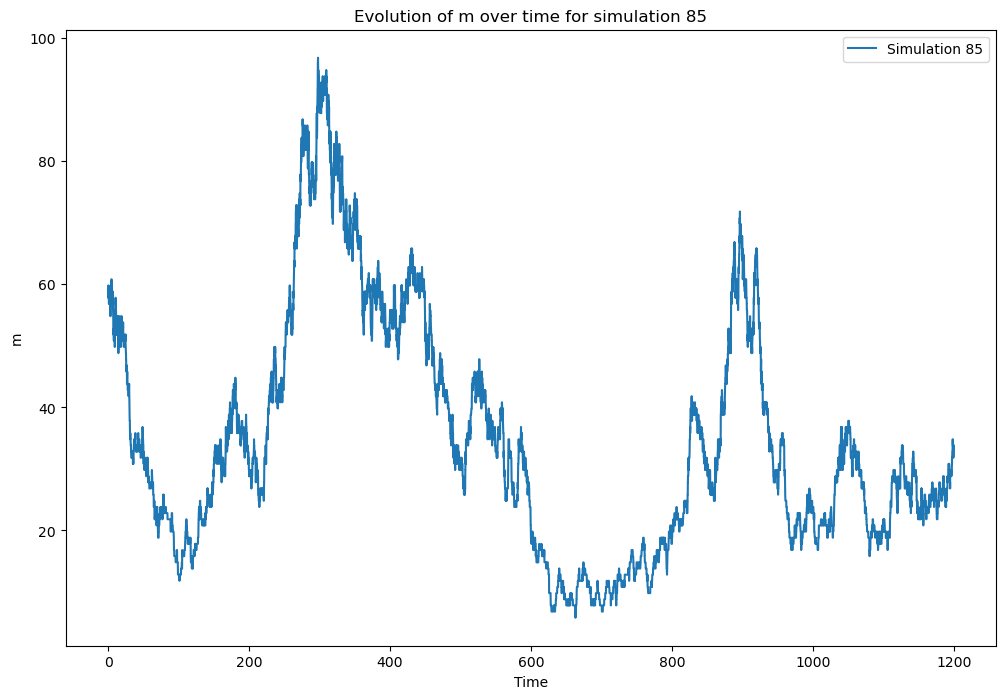

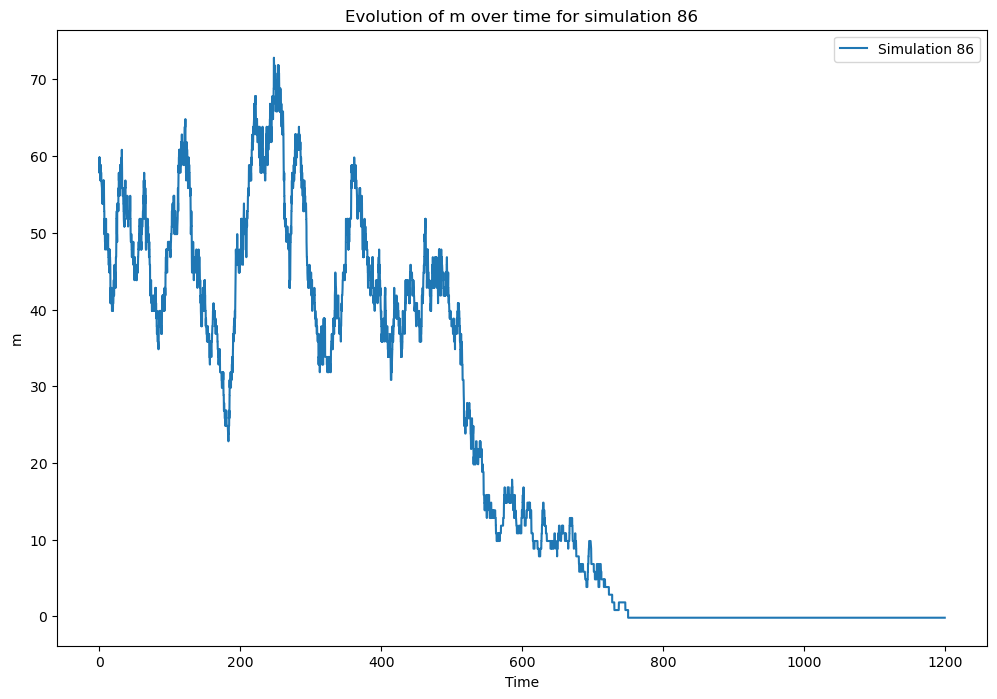

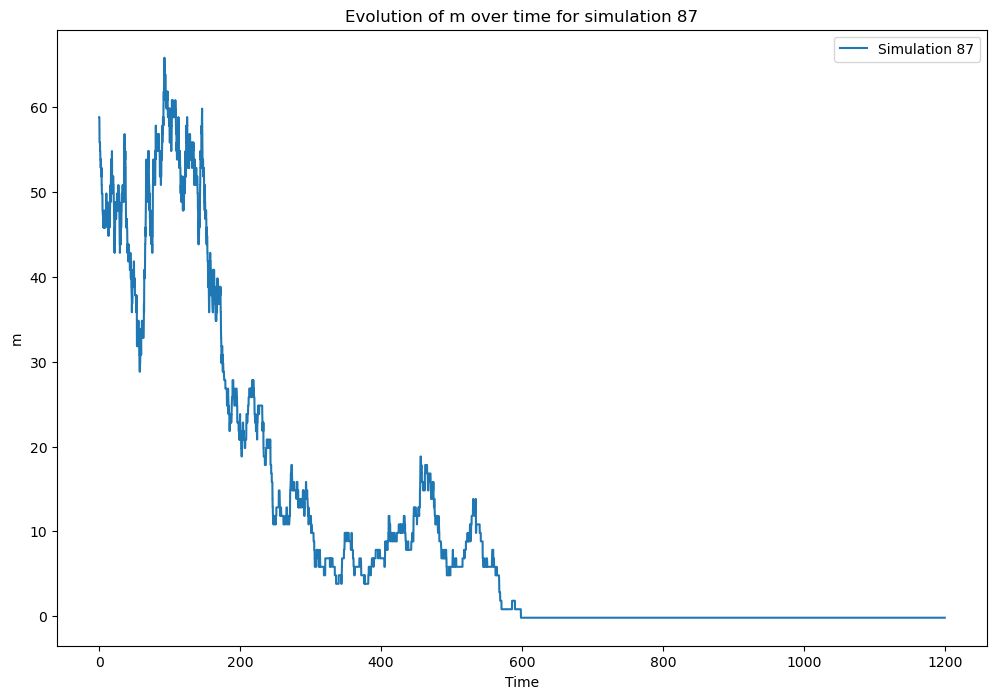

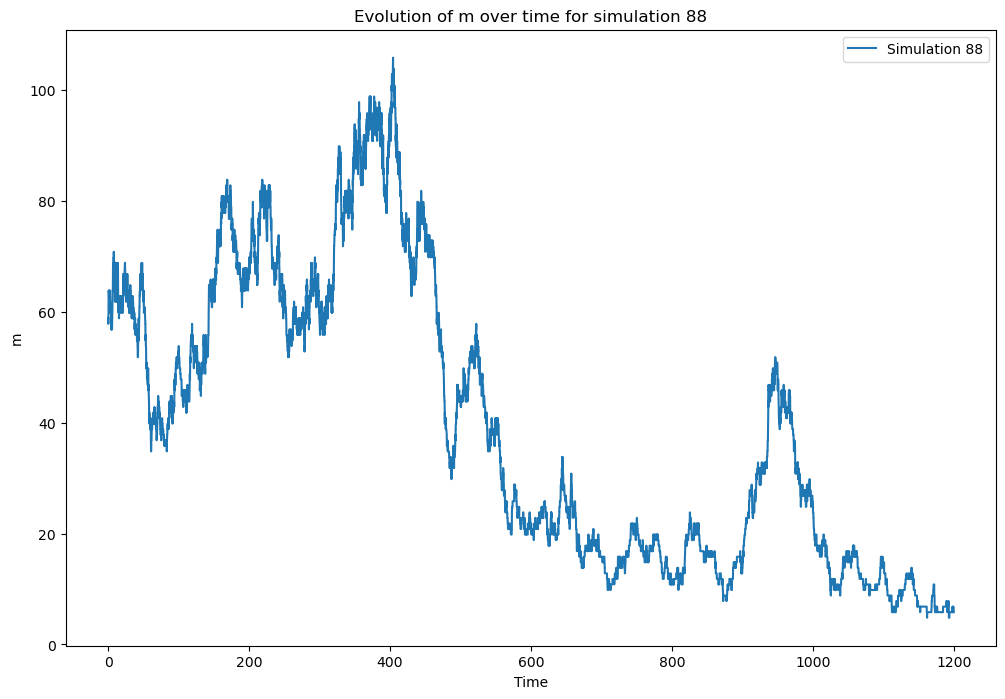

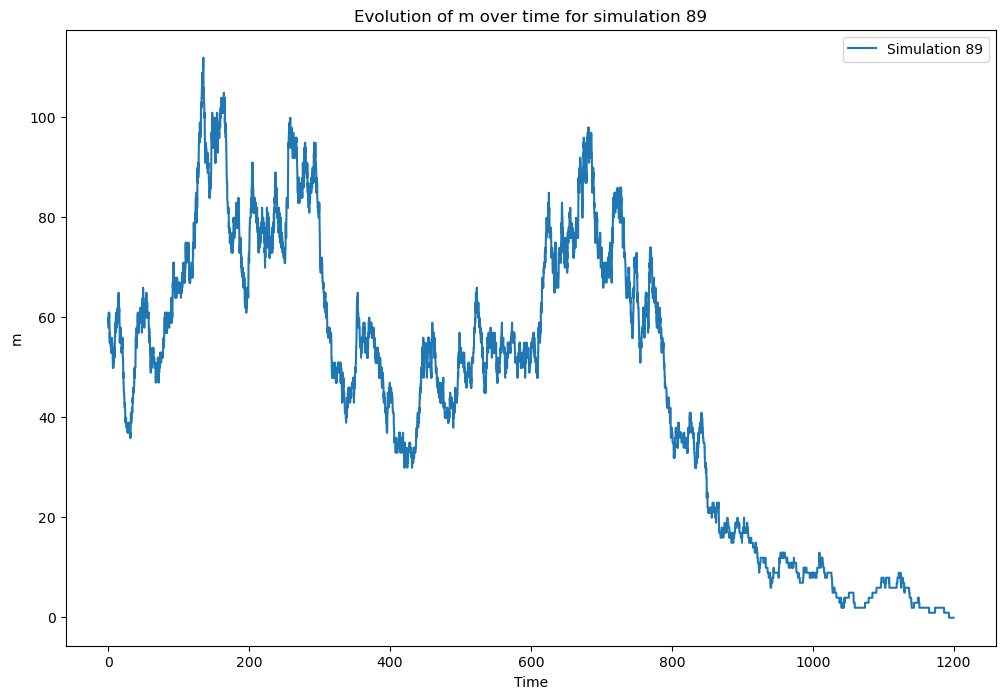

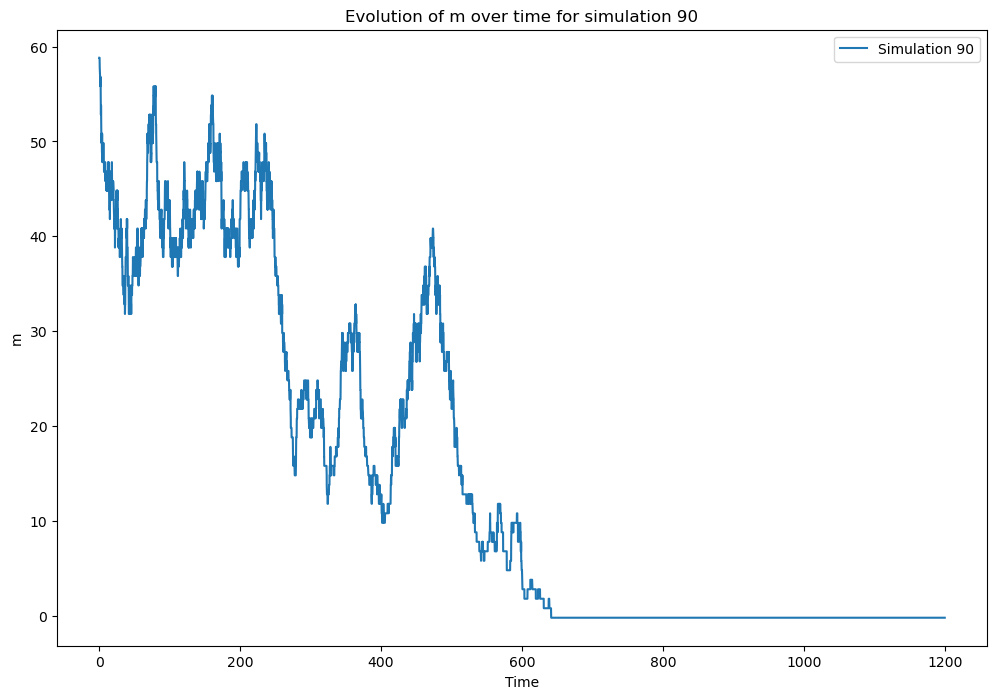

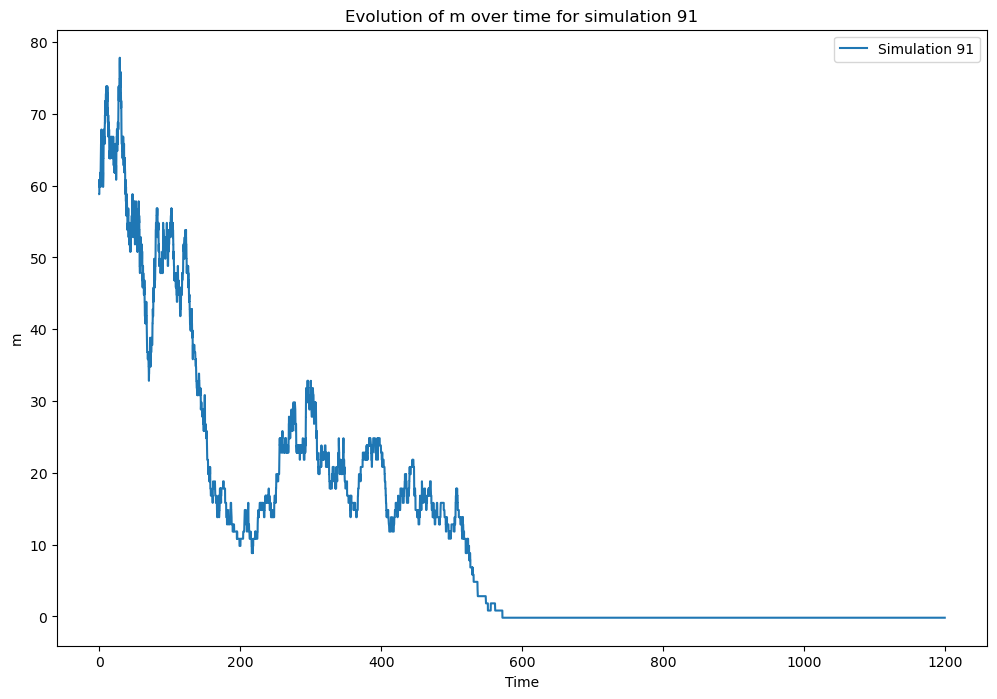

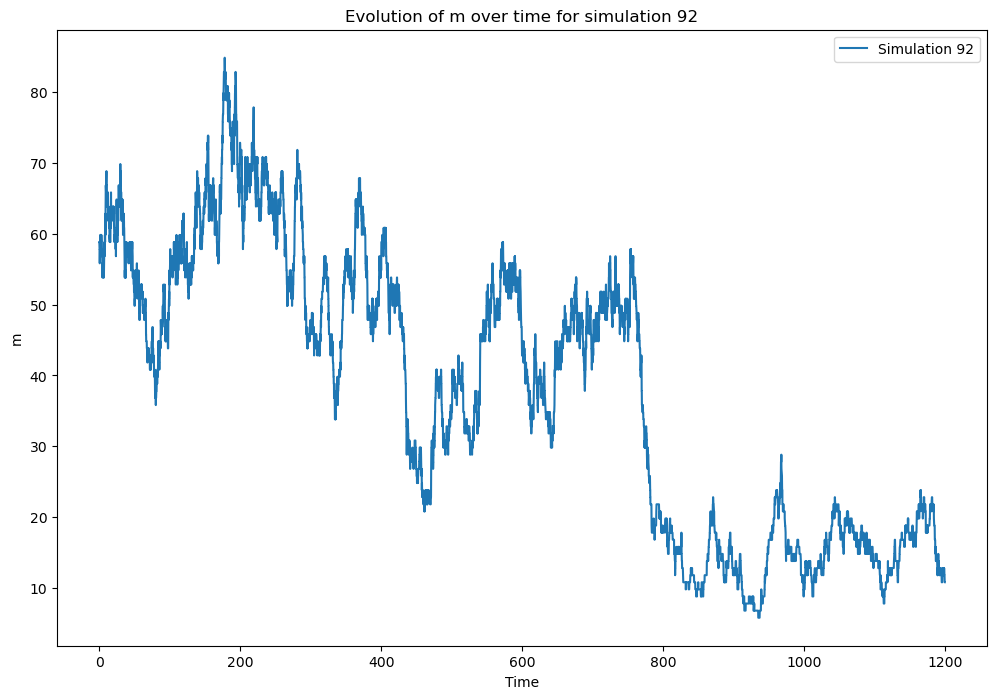

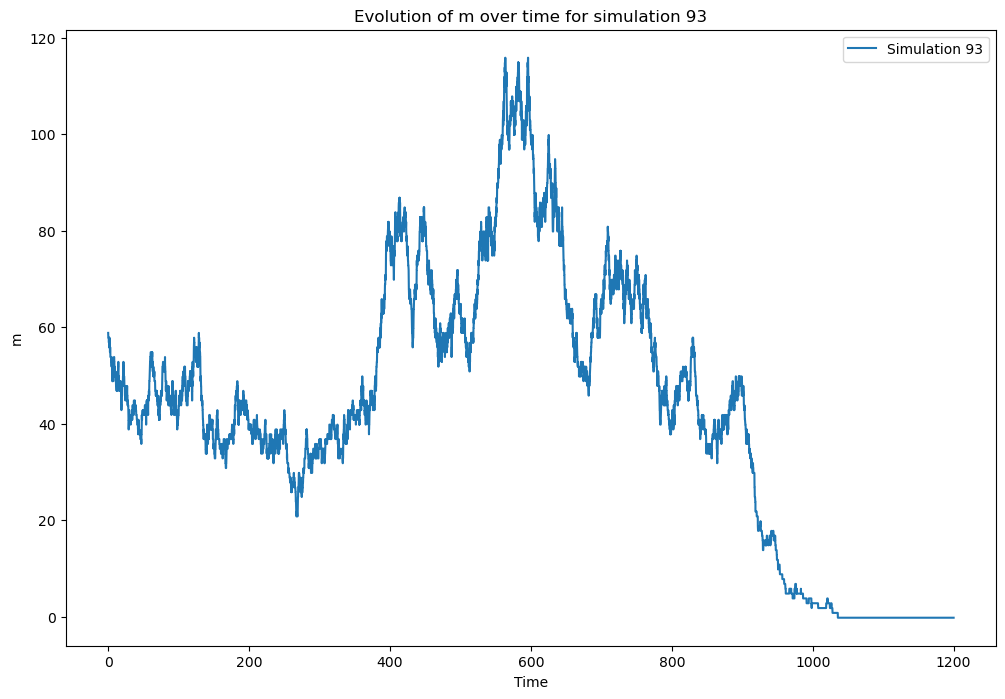

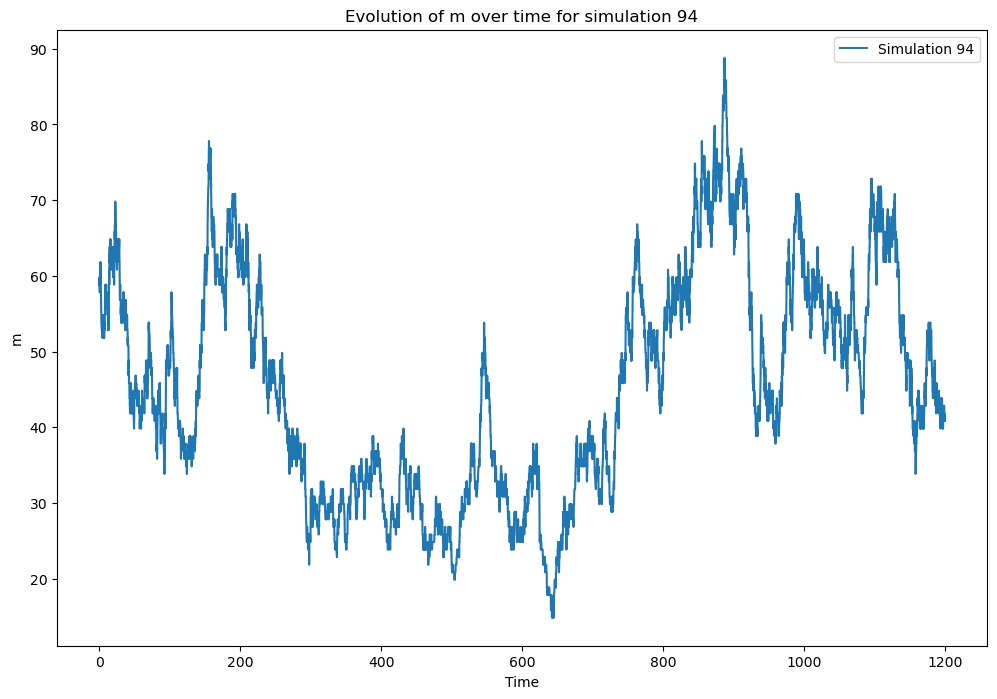

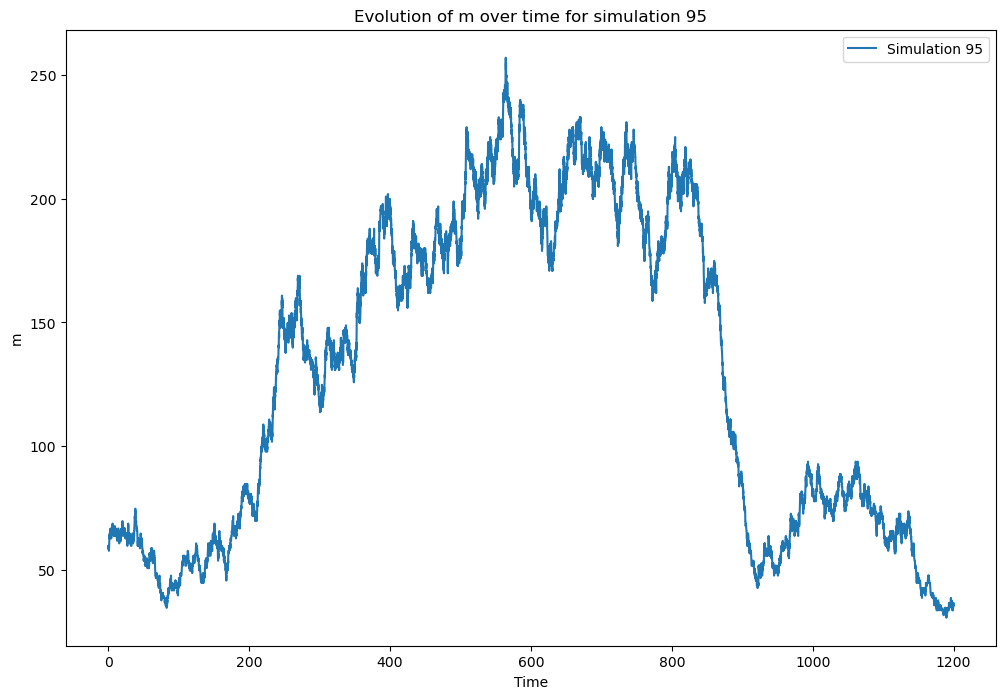

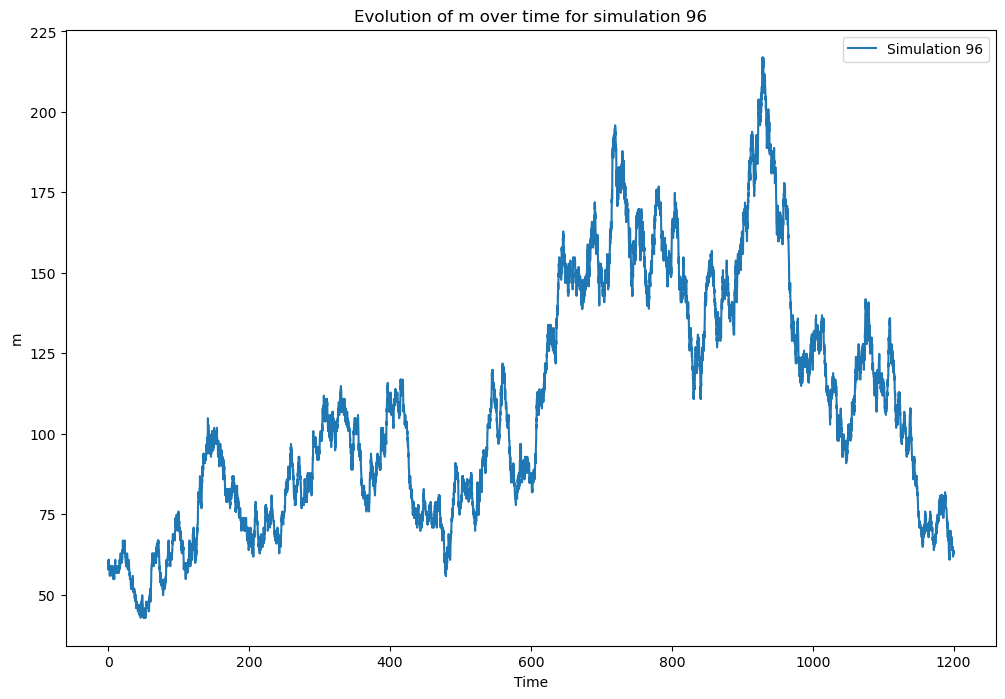

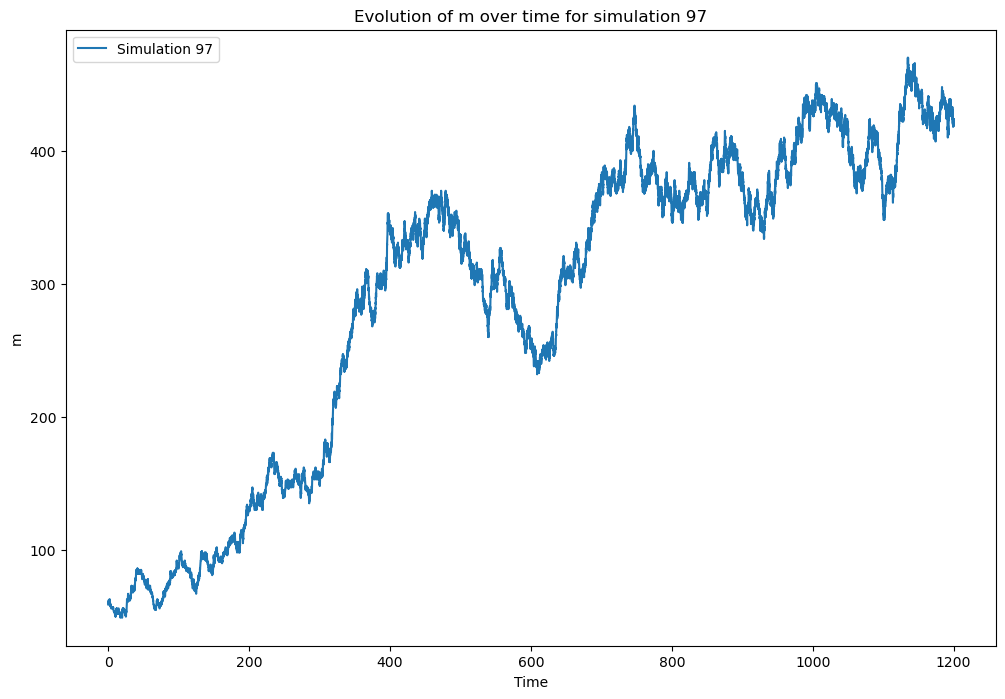

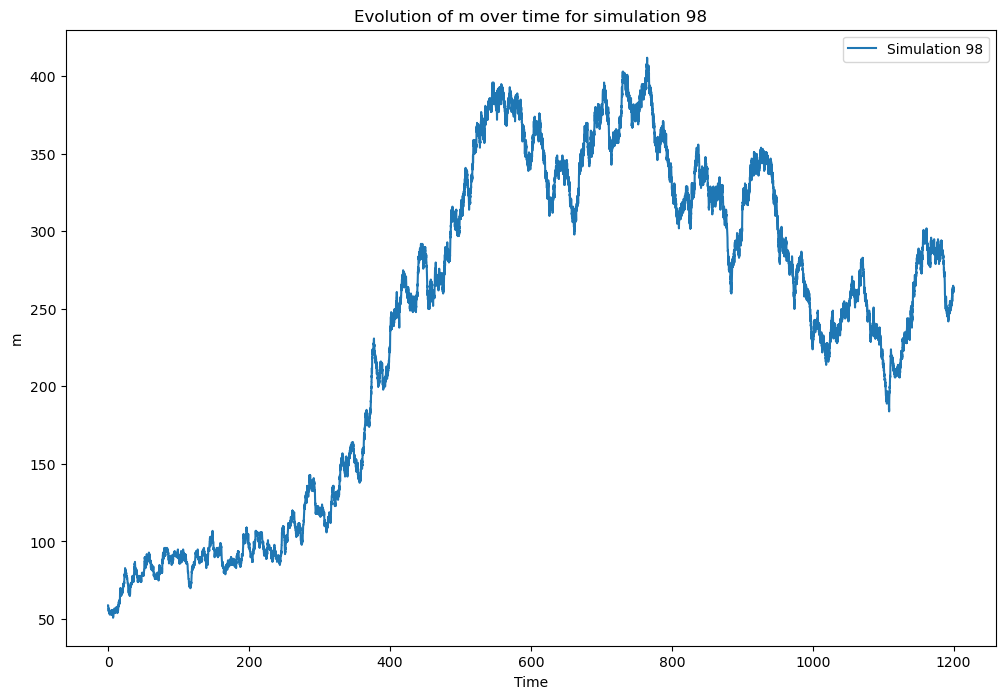

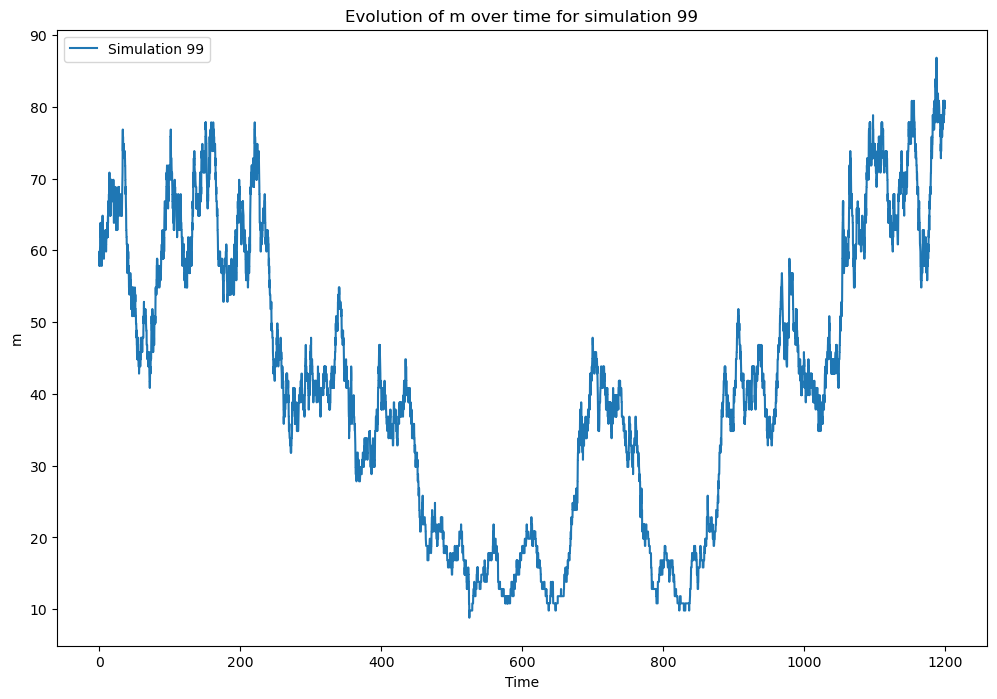

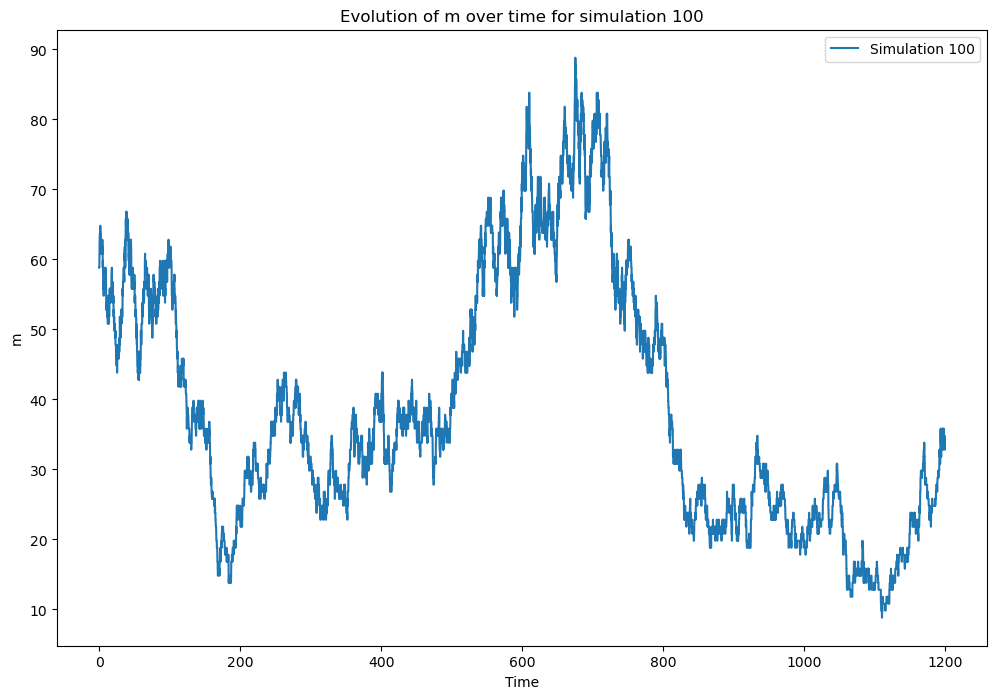

In [149]:
# Tracer chaque simulation sur un graphe séparé
for sim in range(sto_realisations):
    plt.figure(figsize=(12, 8))
    times = all_times[sim]
    populations = all_populations[sim]
    m_values = [pop[1] for pop in populations]  # Extraire les valeurs de m
    plt.plot(times, m_values, label=f'Simulation {sim+1}')
    plt.xlabel('Time')
    plt.ylabel('m')
    plt.title(f'Evolution of m over time for simulation {sim+1}')
    plt.legend()
    plt.show()